#  FEATURE ENGINEERING - PCA STRATEGY ANALYSIS

In this Notebook we investigate if it is reasonable to apply PCA to our problem.

The guidelines are the following:
- It is expected that, if the correlation between variables is low, it is not worth applying PCA. We take a reference value of $|0.5|$ for the Pearson's correlation coefficient, pair-wise (will also make the calculation with the Spearman's correlation coefficient).
- 90 per cent of the variance must be explained: depending on the number of eigenvectors that are taken, it will confirm or discard the intuition of the previous bullet.

**NOTE:** feature scaling does not affect correlation, so for the first bullet we can use the correlation matrices we calculated with the original _cesium_ values, before scaling. For the second bullet, though, we must use the scaled features, because PCA is affected by scaling.

References:
- Applied statistics and probability for engineers (Montgomery), page 143 (for the first bullet)
- Introduction to Machine Learning (Ethem Alpadyn), page 126 (for theg second bullet)


## Modules and configuration

### Modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

from scipy.stats import pearsonr

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

from IPython.display import display

### Configuration

In [2]:
S4_CORRELATION_IN = "../data/Cesium_Corr_S4.csv"
ML_CORRELATION_IN = "../data/Cesium_Corr_ML.csv"

ML_INPUT = "../data/DATASETS_ML/ML_00_DS_Initial.csv"
S4_INPUT = "../data/DATASETS_ML/S4_00_DS_Initial.csv"

ML_INPUT_SCALED = "../data/DATASETS_ML/ML_02_DS_AfterImputing.csv"
S4_INPUT_SCALED = "../data/DATASETS_ML/S4_02_DS_AfterImputing.csv"

IMPUTER_FILE = "../data/ML_MODELS/ML_pipeline_steps/imputer.pickle" # Will store the fitted imputer object

IMPUTED_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/imputed_features_list.pickle"
REL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle"
UNREL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Unreliable_features.pickle"

ML_OUTPUT = "../data/DATASETS_ML/ML_02_DS_AfterImputing.csv" # The scaled features of the ML subsample.
S4_OUTPUT = "../data/DATASETS_ML/S4_02_DS_AfterImputing.csv" # The scaled features of the S4 sample

ML_ADD_COLUMNS = ['Karmn'] # Only cesium features and this column will be kept.
S4_ADD_COLUMNS = ['ID', 'Pulsating', 'frequency', 'amplitudeRV',
                  'offsetRV', 'refepochRV', 'phase'] # Only cesium features and these columns will be kept.

IMAGE_FOLDER = './img/'

### Functions

In [3]:
def multi_compare_dist(d_list, d_labels, varname=None, fig_title=None, fig_filename=None,
                       kde=False, hist=False, hist_fill=True):
    '''Plots and saves multiple overlapped histograms.'''
    # Plots and saves the figure
    if kde == True:
        if hist == True:
            kind = 'hist'
            kde = True
        elif hist == False:
            kind = 'kde'
            hist_fill = False
    else:
        if hist == True:
            kind = 'hist'
            kde = False
        else:
            # None, defaulting to both.
            print("*WARNING: neither 'kde' nor 'hist' are set to 'True'. Defaulting to plotting both...")
            kind = 'hist'
            kde = True
        
    kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill},
                  kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill})
    plt.figure(figsize=(10,7))
    axes = []
    for i in range(0, len(d_list)):
        new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
        #new_axis = sns.displot(d_list[i], label=d_labels[i], kind=kind, kde=kde)
        axes.append(new_axis)
        #if kde == False:
        #    axes[i].get_lines()[0].remove()
    if varname is None:
        axes[0].set_xlabel("%s / %s" %(d1_label, d2_label), fontsize=12)
    else:
        axes[0].set_xlabel(varname, fontsize=12)
    #plt.xlim(0,100)
    if fig_title is None:
        plt.title("Comparison of distributions", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    #plt.grid(axis='x', alpha=0.75)
    plt.ylabel('Frequency of occurrence', fontsize=12)
    #plt.legend(loc='upper right');
    plt.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')

In [4]:
def draw_lineplot(x, y, xlabel=None, ylabel=None, fig_title=None, fig_filename=None):
    '''Plots and saves a lineplot.'''
    # Plots and saves the figure
    plt.figure(figsize=(10,7))
    ax = sns.lineplot(x=x, y=y)
    if xlabel is None:
        ax.set_xlabel("x", fontsize=12)
    else:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel is None:
        ax.set_ylabel("y", fontsize=12)
    else:
        ax.set_ylabel(ylabel, fontsize=12)
    if fig_title is None:
        plt.title("<Generic line plot>", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')

In [212]:
def multi_draw_lineplot(x_list, y_list, dlabel_list, 
                        xlabel=None, ylabel=None, fig_title=None, fig_filename=None):
    '''Plots and saves several lineplots.'''
    # Plots the figure
    plt.figure(figsize=(10,7))
    for i in range(0, len(y_list)):
        sns.lineplot(x=x_list[i], y=y_list[i], label=dlabel_list[i])
    if xlabel is None:
        plt.xlabel("x", fontsize=18)
    else:
        plt.xlabel(xlabel, fontsize=18)
    if ylabel is None:
        plt.ylabel("y", fontsize=18)
    else:
        plt.ylabel(ylabel, fontsize=18)
    if fig_title is None:
        plt.title("<Generic line plot>", fontsize=16)
    else:
        plt.title(fig_title, fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)    
    plt.legend(fontsize=18)
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')

In [214]:
def scatter_graph(data, var_x, var_y, fig_title=None, fig_filename=None):
    '''Plots a scatter plot of two columns of a dataframe.
    It also calculates and shows Pearson's correlation coefficient.'''
    #rv_x_var = var_x
    #tess_y_var = var_y
    #kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    if fig_title is None:
        plt.title(var_y + " vs " + var_x, fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    #plt.grid(axis='both', alpha=0.75)
    plt.xlabel(var_x, fontsize=12)
    plt.ylabel(var_y, fontsize=12)
    sns.scatterplot(data=data, x=var_x, y=var_y)
#    plt.xlim(0.0, 1.0)
    plt.ylim(-1.0, 1.0)    
    plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Calculate the Pearson correlation coefficient between the two results:
    corr, _ = pearsonr(data[var_x], data[var_y])
    print('Pearson\'s correlation value: %.3f' % corr)

In [215]:
def multi_scatter_graph(data_list, var_x_list, var_y_list, dlabel_list,
                        xlabel=None, ylabel=None,
                        fig_title=None, fig_filename=None):
    '''Plots several scatter plots from different datasets.
    It also calculates and shows Pearson's correlation coefficient.'''
    #rv_x_var = var_x
    #tess_y_var = var_y
    #kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    for i in range(0, len(data_list)):
        sns.scatterplot(data=data_list[i], x=var_x_list[i], y=var_y_list[i], label=dlabel_list[i])
    if xlabel is None:
        xlabel = "x"
    plt.xlabel(xlabel, fontsize=18)
    if ylabel is None:
        ylabel = "y"
    plt.ylabel(ylabel, fontsize=18)
    if fig_title is None:
        plt.title(ylabel + " vs " + xlabel, fontsize=16)
    else:
        plt.title(fig_title, fontsize=24)
    #plt.grid(axis='both', alpha=0.75)
    #plt.xlim(0.0, 1.0)
    #plt.ylim(-1.0, 1.0)    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)    
    plt.legend(fontsize=18)
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Calculate the Pearson correlation coefficient between the two results:
    for i in range(0, len(data_list)):
        corr, _ = pearsonr(data_list[i][var_x_list[i]],data_list[i][var_y_list[i]])
        print("Pearson\'s correlation value for '%s': %.3f" %(dlabel_list[i], corr))

## Load data

We load the data, which are the time series as previously featurized by _cesium_, scaled, and with `NaN` values imputed by a `KNNImputer`.

### Load the list of features to impute

In [8]:
impute_f_list = pickle.load(open(IMPUTED_FEATURES_IN, "rb"))
impute_f_list

['all_times_nhist_peak2_bin',
 'all_times_nhist_peak3_bin',
 'all_times_nhist_peak4_bin',
 'all_times_nhist_peak_1_to_2',
 'all_times_nhist_peak_1_to_3',
 'all_times_nhist_peak_1_to_4',
 'all_times_nhist_peak_2_to_3',
 'all_times_nhist_peak_2_to_4',
 'all_times_nhist_peak_3_to_4',
 'fold2P_slope_10percentile',
 'fold2P_slope_90percentile',
 'medperc90_2p_p']

### Load reliable features list

In [9]:
rel_features = pickle.load(open(REL_FEATURES_IN, 'rb'))
print(rel_features)

['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'med_double_to_single_step', 'n_epochs', 'std_double_to_single_step', 'total_time', 'percent_beyond_1_std', 'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4', 'freq2_rel_phase2', 'freq2_rel_phase3', 'freq2_rel_phase4', 'freq3_rel_phase2', 'freq3_rel_phase3', '

### Load unreliable features list

In [10]:
unrel_features = pickle.load(open(UNREL_FEATURES_IN, 'rb'))
print(unrel_features)

['avg_err', 'avgt', 'mean', 'med_err', 'std_err', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'max_slope', 'maximum', 'median', 'median_absolute_deviation', 'minimum', 'percent_amplitude', 'percent_close_to_median', 'percent_difference_flux_percentile', 'period_fast', 'qso_log_chi2_qsonu', 'qso_log_chi2nuNULL_chi2nu', 'skew', 'std', 'stetson_j', 'stetson_k', 'weighted_average', 'fold2P_slope_10percentile', 'fold2P_slope_90percentile', 'freq1_amplitude1', 'freq1_amplitude2', 'freq1_amplitude3', 'freq1_amplitude4', 'freq1_freq', 'freq1_lambda', 'freq1_signif', 'freq2_amplitude1', 'freq2_amplitude2', 'freq2_amplitude3', 'freq2_amplitude4', 'freq2_freq', 'freq3_amplitude1', 'freq3_amplitude2', 'freq3_amplitude3', 'freq3_amplitude4', 'freq3_freq', 'freq_amplitude_ratio_21', 'freq_amplitude_ratio_31', 'freq_frequency_ratio_21', 'freq_frequency_ratio_31', 'freq_model_max

###  Read the S4 sample data (scaled features)

In [11]:
s4_sc = pd.read_csv(S4_INPUT_SCALED, sep=',', decimal='.')
s4_sc

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00000       True      10.33         1.14       0.0  2.457582e+06   
1    Star-00001       True      14.92         1.30       0.0  2.457522e+06   
2    Star-00002      False       0.00         0.00       0.0  2.457549e+06   
3    Star-00003      False       0.00         0.00       0.0  2.457460e+06   
4    Star-00004       True      28.74         0.90       0.0  2.457451e+06   
..          ...        ...        ...          ...       ...           ...   
995  Star-00995      False       0.00         0.00       0.0  2.457504e+06   
996  Star-00996      False       0.00         0.00       0.0  2.457673e+06   
997  Star-00997      False       0.00         0.00       0.0  2.458634e+06   
998  Star-00998      False       0.00         0.00       0.0  2.457397e+06   
999  Star-00999      False       0.00         0.00       0.0  2.457406e+06   

     phase  all_times_nhist_numpeaks  all_times_nhist_peak1_bin  \
0     0.90                 -1.944263                   2.120058   
1     0.02                  1.231081                   0.171155   
2     0.00                  0.596012                  -0.664089   
3     0.00                  2.501218                  -0.664089   
4     0.29                 -0.039057                   1.076003   
..     ...                       ...                        ...   
995   0.00                  0.913546                  -0.037656   
996   0.00                 -1.626729                   1.632833   
997   0.00                 -0.356591                  -0.803296   
998   0.00                 -0.356591                  -0.037656   
999   0.00                 -0.356591                   0.936796   

     all_times_nhist_peak2_bin  ...  freq_signif_ratio_31  freq_varrat  \
0                     1.900503  ...              0.175639    -1.179443   
1                     0.089360  ...              0.281290     0.536314   
2                    -0.212498  ...             -0.307759     0.629682   
3                    -1.495391  ...             -0.076569     0.420813   
4                     0.391217  ...             -0.390230    -1.060328   
..                         ...  ...                   ...          ...   
995                   0.089360  ...              0.842777    -0.334041   
996                   2.051432  ...              1.724900    -0.463711   
997                  -0.514355  ...             -0.486141     1.825751   
998                  -0.891677  ...             -0.288419     1.285370   
999                  -0.665284  ...              0.503438    -1.374553   

     freq_y_offset  linear_trend  medperc90_2p_p  p2p_scatter_2praw  \
0         0.567705      0.100876       -0.114591          -0.216210   
1         0.053099      0.191840       -0.184775           1.237821   
2        -0.137934      0.052383       -0.134684          -0.332168   
3        -0.544527      0.065099       -0.073476           0.021419   
4         2.146213      0.010452       -0.401182          -0.849181   
..             ...           ...             ...                ...   
995      -1.827351     -0.257412       -0.616404          -1.315109   
996      -1.194149      0.021936        0.815043           0.401297   
997      -0.108959      0.070002       -0.285029           0.368291   
998       0.083736      0.024976       -0.290043           0.132179   
999      -0.091967      0.079211        0.831331           0.149720   

     p2p_scatter_over_mad  p2p_scatter_pfold_over_mad  p2p_ssqr_diff_over_var  \
0                0.045386                   -0.543694                1.459163   
1               -0.589916                   -0.372454               -1.663617   
2                0.316178                   -0.194267               -0.020196   
3               -0.521209                   -0.244714                0.081570   
4                0.067740                   -0.433568                0.438785   
..                    ...                  

#### Extract the _cesium_ feature list

In [12]:
cs_f_list = list(s4_sc.drop(columns=S4_ADD_COLUMNS).columns)
print(cs_f_list)

['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'mean', 'med_double_to_single_step', 'med_err', 'n_epochs', 'std_double_to_single_step', 'std_err', 'total_time', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65',

#### Extract pulsating stars in S4

In [13]:
s4p_sc = s4_sc[s4_sc['Pulsating'] == True].reset_index(drop=True).copy()
s4p_sc

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00000       True      10.33         1.14       0.0  2.457582e+06   
1    Star-00001       True      14.92         1.30       0.0  2.457522e+06   
2    Star-00004       True      28.74         0.90       0.0  2.457451e+06   
3    Star-00012       True      60.83         1.44       0.0  2.457407e+06   
4    Star-00015       True      17.00         0.13       0.0  2.457443e+06   
..          ...        ...        ...          ...       ...           ...   
99   Star-00956       True      32.26         1.44       0.0  2.457393e+06   
100  Star-00965       True      10.94         0.35       0.0  2.457660e+06   
101  Star-00980       True      38.48         0.63       0.0  2.457424e+06   
102  Star-00982       True      15.44         0.75       0.0  2.457472e+06   
103  Star-00991       True      29.49         0.75       0.0  2.457430e+06   

     phase  all_times_nhist_numpeaks  all_times_nhist_peak1_bin  \
0     0.90                 -1.944263                   2.120058   
1     0.02                  1.231081                   0.171155   
2     0.29                 -0.039057                   1.076003   
3     0.10                 -1.626729                  -0.246467   
4     0.11                 -0.039057                   1.424022   
..     ...                       ...                        ...   
99    0.62                  0.278478                  -1.151314   
100   0.45                 -0.674126                  -0.524881   
101   0.27                 -1.626729                   2.050455   
102   0.28                 -1.626729                   1.632833   
103   0.05                 -0.991660                   0.727985   

     all_times_nhist_peak2_bin  ...  freq_signif_ratio_31  freq_varrat  \
0                     1.900503  ...              0.175639    -1.179443   
1                     0.089360  ...              0.281290     0.536314   
2                     0.391217  ...             -0.390230    -1.060328   
3                     0.617610  ...              0.593441     0.834758   
4                     1.070396  ...             -0.328939    -1.027254   
..                         ...  ...                   ...          ...   
99                    1.749575  ...              0.241670     0.575085   
100                   0.013895  ...             -1.594071    -0.250322   
101                   0.013895  ...              1.632050    -1.502272   
102                   2.051432  ...              1.715191    -1.796097   
103                   0.391217  ...             -0.055913     1.123376   

     freq_y_offset  linear_trend  medperc90_2p_p  p2p_scatter_2praw  \
0         0.567705      0.100876       -0.114591          -0.216210   
1         0.053099      0.191840       -0.184775           1.237821   
2         2.146213      0.010452       -0.401182          -0.849181   
3        -1.236349     -0.041813       -0.294595          -0.085602   
4        -0.739347      0.072261        0.030767          -1.318103   
..             ...           ...             ...                ...   
99       -0.630874      0.070774       -0.146436          -0.167808   
100      -0.620724      0.142720        0.071652          -0.077026   
101       0.977323      2.281726        0.226891           1.313572   
102      -0.181552     -0.040223        1.783261           2.927030   
103       0.084003      0.110494       -0.426362          -0.314202   

     p2p_scatter_over_mad  p2p_scatter_pfold_over_mad  p2p_ssqr_diff_over_var  \
0                0.045386                   -0.543694                1.459163   
1               -0.589916                   -0.372454               -1.663617   
2                0.067740                   -0.433568                0.438785   
3               -0.123684                    0.223644                0.468292   
4                0.294349                    0.003801                0.381024   
..                    ...                  

#### Extract the non-pulsating stars in S4

In [14]:
s4np_sc = s4_sc[s4_sc['Pulsating'] == False].reset_index(drop=True).copy()
s4np_sc

ID  Pulsating  frequency  amplitudeRV  offsetRV    refepochRV  \
0    Star-00002      False        0.0          0.0       0.0  2.457549e+06   
1    Star-00003      False        0.0          0.0       0.0  2.457460e+06   
2    Star-00005      False        0.0          0.0       0.0  2.457419e+06   
3    Star-00006      False        0.0          0.0       0.0  2.457545e+06   
4    Star-00007      False        0.0          0.0       0.0  2.457574e+06   
..          ...        ...        ...          ...       ...           ...   
891  Star-00995      False        0.0          0.0       0.0  2.457504e+06   
892  Star-00996      False        0.0          0.0       0.0  2.457673e+06   
893  Star-00997      False        0.0          0.0       0.0  2.458634e+06   
894  Star-00998      False        0.0          0.0       0.0  2.457397e+06   
895  Star-00999      False        0.0          0.0       0.0  2.457406e+06   

     phase  all_times_nhist_numpeaks  all_times_nhist_peak1_bin  \
0      0.0                  0.596012                  -0.664089   
1      0.0                  2.501218                  -0.664089   
2      0.0                 -1.944263                   2.120058   
3      0.0                 -0.991660                   2.120058   
4      0.0                  0.596012                   0.310363   
..     ...                       ...                        ...   
891    0.0                  0.913546                  -0.037656   
892    0.0                 -1.626729                   1.632833   
893    0.0                 -0.356591                  -0.803296   
894    0.0                 -0.356591                  -0.037656   
895    0.0                 -0.356591                   0.936796   

     all_times_nhist_peak2_bin  ...  freq_signif_ratio_31  freq_varrat  \
0                    -0.212498  ...             -0.307759     0.629682   
1                    -1.495391  ...             -0.076569     0.420813   
2                     1.900503  ...              0.761835    -1.657903   
3                    -1.646320  ...              2.294150    -1.684878   
4                    -1.646320  ...             -0.485987    -1.200965   
..                         ...  ...                   ...          ...   
891                   0.089360  ...              0.842777    -0.334041   
892                   2.051432  ...              1.724900    -0.463711   
893                  -0.514355  ...             -0.486141     1.825751   
894                  -0.891677  ...             -0.288419     1.285370   
895                  -0.665284  ...              0.503438    -1.374553   

     freq_y_offset  linear_trend  medperc90_2p_p  p2p_scatter_2praw  \
0        -0.137934      0.052383       -0.134684          -0.332168   
1        -0.544527      0.065099       -0.073476           0.021419   
2         1.810843      0.043949        0.450072          -1.061806   
3         0.902167      0.220573        0.077265           1.460442   
4         1.720964      0.210894       -0.386803          -1.110683   
..             ...           ...             ...                ...   
891      -1.827351     -0.257412       -0.616404          -1.315109   
892      -1.194149      0.021936        0.815043           0.401297   
893      -0.108959      0.070002       -0.285029           0.368291   
894       0.083736      0.024976       -0.290043           0.132179   
895      -0.091967      0.079211        0.831331           0.149720   

     p2p_scatter_over_mad  p2p_scatter_pfold_over_mad  p2p_ssqr_diff_over_var  \
0                0.316178                   -0.194267               -0.020196   
1               -0.521209                   -0.244714                0.081570   
2               -0.530961                   -0.226461               -0.080477   
3               -0.490521                    0.082761                1.578450   
4                0.094357                   -0.201547               -0.168095   
..                    ...                  

###  Read the ML subsample data (scaled features)

In [15]:
ml_sc = pd.read_csv(ML_INPUT_SCALED, sep=',', decimal='.')
ml_sc

Karmn  all_times_nhist_numpeaks  all_times_nhist_peak1_bin  \
0     J23505-095                  0.278478                  -0.594485   
1     J23492+024                 -0.674126                  -0.733692   
2     J23431+365                  0.596012                  -0.107259   
3     J23419+441                  0.278478                   1.354418   
4     J23381-162                 -0.039057                  -0.385674   
..           ...                       ...                        ...   
228   J00184+440                  1.231081                  -0.803296   
229   J00183+440                  0.278478                  -0.594485   
230  J00162+198E                  1.548615                  -0.246467   
231   J00067-075                 -0.991660                   0.727985   
232   J00051+457                  0.913546                  -1.151314   

     all_times_nhist_peak2_bin  all_times_nhist_peak3_bin  \
0                     0.013895                  -0.956701   
1                    -0.438891                  -0.057745   
2                     0.542146                   1.740165   
3                     0.240288                   1.140862   
4                    -0.891677                  -0.657049   
..                         ...                        ...   
228                  -0.816212                  -1.181439   
229                  -0.212498                  -0.057745   
230                   0.089360                   0.691384   
231                   0.391217                  -0.657049   
232                   0.240288                  -0.207571   

     all_times_nhist_peak4_bin  all_times_nhist_peak_1_to_2  \
0                     0.396592                    -0.582246   
1                     0.473809                    -0.347436   
2                    -0.993314                    -0.573237   
3                    -0.993314                    -0.281692   
4                     1.477630                     0.003096   
..                         ...                          ...   
228                  -1.765484                    -0.692478   
229                   0.010507                     6.639601   
230                  -0.993314                    -0.692478   
231                   1.477630                    -0.286293   
232                  -1.533833                    -0.005709   

     all_times_nhist_peak_1_to_3  all_times_nhist_peak_1_to_4  \
0                      -0.695467                     0.903654   
1                      -0.322543                     1.312483   
2                      -0.710438                    -0.638376   
3                      -0.412485                    -0.559694   
4                       0.886923                     0.217009   
..                           ...                          ...   
228                    -0.643510                    -0.749558   
229                     3.850951                     2.650660   
230                    -0.657169                    -0.672852   
231                    -0.265547                    -0.370133   
232                    -0.205837                    -0.022504   

     all_times_nhist_peak_2_to_3  ...  freq_signif_ratio_31  freq_varrat  \
0                      -0.497556  ...             -1.344237     0.307975   
1                      -0.153626  ...             -2.251395     1.650742   
2                      -0.528719  ...              0.178298    -1.062289   
3                      -0.332839  ...             -2.029837     0.290144   
4                       0.990671  ...             -0.842653     0.846232   
..                           ...  ...                   ...          ...   
228                    -0.309658  ...             -2.597143     0.324707   
229                    -0.291142  ...             -2.880414     0.261581   
230                    -0.332839  ...             -0.452208    -1.089296   
231                    -0.131556  ...              0.509226     0.882068   
232                    -0.2

### Load S4 sample correlation matrix (original)

In [16]:
s4_corr = pd.read_csv(S4_CORRELATION_IN, sep=',', decimal='.', index_col=0)
s4_corr

all_times_nhist_numpeaks  \
all_times_nhist_numpeaks                    1.000000   
all_times_nhist_peak1_bin                  -0.397410   
all_times_nhist_peak2_bin                  -0.392406   
all_times_nhist_peak3_bin                  -0.244111   
all_times_nhist_peak4_bin                  -0.293384   
...                                              ...   
p2p_scatter_2praw                          -0.079441   
p2p_scatter_over_mad                       -0.119929   
p2p_scatter_pfold_over_mad                 -0.072286   
p2p_ssqr_diff_over_var                     -0.066943   
scatter_res_raw                             0.152771   

                            all_times_nhist_peak1_bin  \
all_times_nhist_numpeaks                    -0.427080   
all_times_nhist_peak1_bin                    1.000000   
all_times_nhist_peak2_bin                    0.142426   
all_times_nhist_peak3_bin                   -0.089263   
all_times_nhist_peak4_bin                    0.039765   
...                                               ...   
p2p_scatter_2praw                           -0.070271   
p2p_scatter_over_mad                         0.064863   
p2p_scatter_pfold_over_mad                  -0.023404   
p2p_ssqr_diff_over_var                       0.046038   
scatter_res_raw                             -0.164788   

                            all_times_nhist_peak2_bin  \
all_times_nhist_numpeaks                    -0.407424   
all_times_nhist_peak1_bin                    0.137242   
all_times_nhist_peak2_bin                    1.000000   
all_times_nhist_peak3_bin                    0.186449   
all_times_nhist_peak4_bin                    0.001382   
...                                               ...   
p2p_scatter_2praw                            0.006231   
p2p_scatter_over_mad                         0.082601   
p2p_scatter_pfold_over_mad                  -0.014224   
p2p_ssqr_diff_over_var                      -0.021504   
scatter_res_raw                             -0.214433   

                            all_times_nhist_peak3_bin  \
all_times_nhist_numpeaks                    -0.215594   
all_times_nhist_peak1_bin                   -0.136967   
all_times_nhist_peak2_bin                    0.179451   
all_times_nhist_peak3_bin                    1.000000   
all_times_nhist_peak4_bin                    0.127026   
...                                               ...   
p2p_scatter_2praw                           -0.064204   
p2p_scatter_over_mad                         0.030357   
p2p_scatter_pfold_over_mad                  -0.022877   
p2p_ssqr_diff_over_var                      -0.013362   
scatter_res_raw                             -0.023841   

                            all_times_nhist_peak4_bin  \
all_times_nhist_numpeaks                    -0.269108   
all_times_nhist_peak1_bin                    0.018468   
all_times_nhist_peak2_bin                    0.005723   
all_times_nhist_peak3_bin                    0.128629   
all_times_nhist_peak4_bin                    1.000000   
...                                               ...   
p2p_scatter_2praw                            0.061676   
p2p_scatter_over_mad                        -0.031397   
p2p_scatter_pfold_over_mad                   0.018322   
p2p_ssqr_diff_over_var                      -0.115346   
scatter_res_raw                              0.034768   

                            all_times_nhist_peak_1_to_2  \
all_times_nhist_numpeaks                      -0.173845   
all_times_nhist_peak1_bin                      0.123394   
all_times_nhist_peak2_bin                      0.038429   
all_times_nhist_peak3_bin                      0.057372   
all_times_nhist_peak4_bin                     -0.043422   
...                                                 ...   
p2p_scatter_2praw                             -0.129449   
p2p_scatter_over_mad                          -0.005929   
p2p_scatter_pfold_over_mad                    -0.060738   
p2p_ssqr_diff_over_var   

### Load the ML subsample correlation matrix (original)

In [17]:
ml_corr = pd.read_csv(ML_CORRELATION_IN, sep=',', decimal='.', index_col=0)
ml_corr

all_times_nhist_numpeaks  \
all_times_nhist_numpeaks                    1.000000   
all_times_nhist_peak1_bin                  -0.398145   
all_times_nhist_peak2_bin                  -0.412441   
all_times_nhist_peak3_bin                  -0.194598   
all_times_nhist_peak4_bin                  -0.301539   
...                                              ...   
p2p_scatter_2praw                          -0.010624   
p2p_scatter_over_mad                       -0.113196   
p2p_scatter_pfold_over_mad                 -0.135840   
p2p_ssqr_diff_over_var                     -0.051332   
scatter_res_raw                             0.057444   

                            all_times_nhist_peak1_bin  \
all_times_nhist_numpeaks                    -0.436957   
all_times_nhist_peak1_bin                    1.000000   
all_times_nhist_peak2_bin                    0.154512   
all_times_nhist_peak3_bin                   -0.043487   
all_times_nhist_peak4_bin                    0.026654   
...                                               ...   
p2p_scatter_2praw                           -0.063375   
p2p_scatter_over_mad                         0.007635   
p2p_scatter_pfold_over_mad                   0.024235   
p2p_ssqr_diff_over_var                      -0.004567   
scatter_res_raw                             -0.158962   

                            all_times_nhist_peak2_bin  \
all_times_nhist_numpeaks                    -0.424330   
all_times_nhist_peak1_bin                    0.159047   
all_times_nhist_peak2_bin                    1.000000   
all_times_nhist_peak3_bin                    0.185093   
all_times_nhist_peak4_bin                    0.038815   
...                                               ...   
p2p_scatter_2praw                           -0.172716   
p2p_scatter_over_mad                         0.205613   
p2p_scatter_pfold_over_mad                   0.025398   
p2p_ssqr_diff_over_var                       0.108195   
scatter_res_raw                             -0.088737   

                            all_times_nhist_peak3_bin  \
all_times_nhist_numpeaks                    -0.167239   
all_times_nhist_peak1_bin                   -0.108177   
all_times_nhist_peak2_bin                    0.174776   
all_times_nhist_peak3_bin                    1.000000   
all_times_nhist_peak4_bin                    0.117441   
...                                               ...   
p2p_scatter_2praw                           -0.149986   
p2p_scatter_over_mad                         0.069916   
p2p_scatter_pfold_over_mad                  -0.024350   
p2p_ssqr_diff_over_var                       0.049456   
scatter_res_raw                             -0.032378   

                            all_times_nhist_peak4_bin  \
all_times_nhist_numpeaks                    -0.270292   
all_times_nhist_peak1_bin                    0.007255   
all_times_nhist_peak2_bin                    0.035784   
all_times_nhist_peak3_bin                    0.113692   
all_times_nhist_peak4_bin                    1.000000   
...                                               ...   
p2p_scatter_2praw                            0.040321   
p2p_scatter_over_mad                         0.064924   
p2p_scatter_pfold_over_mad                   0.070208   
p2p_ssqr_diff_over_var                       0.077857   
scatter_res_raw                              0.111200   

                            all_times_nhist_peak_1_to_2  \
all_times_nhist_numpeaks                      -0.177550   
all_times_nhist_peak1_bin                      0.092195   
all_times_nhist_peak2_bin                      0.080958   
all_times_nhist_peak3_bin                      0.033300   
all_times_nhist_peak4_bin                     -0.016574   
...                                                 ...   
p2p_scatter_2praw                             -0.091622   
p2p_scatter_over_mad                          -0.138781   
p2p_scatter_pfold_over_mad                    -0.141466   
p2p_ssqr_diff_over_var   

## Correlation analysis for PCA

We first analyse the correlation values found in the datasets between pairs of features, to see if PCA would be worth applicating.

**NOTE:** we use the correlation matrices we calculated previously with the original feature values (i.e. before scaling and imputing), upon the understanding that the correlation has not changed a great deal with the scaling and imputing.

### Correlation in S4 sample (original features)

#### Combined (Pearson and Spearman)

In [18]:
s4_corr_comb_values = pd.Series(s4_corr.to_numpy().flatten(), name='S4 Pearson/Spearman correlation')
s4_corr_comb_values

0        1.000000
1       -0.427080
2       -0.407424
3       -0.215594
4       -0.269108
           ...   
12539    0.302636
12540    0.061823
12541    0.394221
12542   -0.001297
12543    1.000000
Name: S4 Pearson/Spearman correlation, Length: 12544, dtype: float64

In [19]:
s4_corr_comb_values.describe()

count    11884.000000
mean         0.029836
std          0.218421
min         -0.998250
25%         -0.039800
50%          0.002142
75%          0.053878
max          1.000000
Name: S4 Pearson/Spearman correlation, dtype: float64

#### Pearson correlation

Remember that Pearson's coefficients were above the diagonal.

In [20]:
s4_corr_p = np.triu(s4_corr, k=0) + np.triu(s4_corr, k=1).T
s4_corr_p

array([[ 1.        , -0.42708048, -0.40742383, ..., -0.12974437,
        -0.12536073,  0.11356149],
       [-0.42708048,  1.        ,  0.13724247, ...,  0.04558671,
         0.08804436, -0.19497789],
       [-0.40742383,  0.13724247,  1.        , ...,  0.06449748,
         0.03403616, -0.19583932],
       ...,
       [-0.12974437,  0.04558671,  0.06449748, ...,  1.        ,
         0.11670338,  0.34502954],
       [-0.12536073,  0.08804436,  0.03403616, ...,  0.11670338,
         1.        , -0.00632918],
       [ 0.11356149, -0.19497789, -0.19583932, ...,  0.34502954,
        -0.00632918,  1.        ]])

In [21]:
s4_corr_p_values = pd.Series(s4_corr_p.flatten(), name='S4 Pearson correlation')
s4_corr_p_values

0        1.000000
1       -0.427080
2       -0.407424
3       -0.215594
4       -0.269108
           ...   
12539    0.121328
12540    0.133360
12541    0.345030
12542   -0.006329
12543    1.000000
Name: S4 Pearson correlation, Length: 12544, dtype: float64

In [22]:
s4_corr_p_values.describe()

count    11884.000000
mean         0.024916
std          0.200048
min         -0.998250
25%         -0.039562
50%         -0.000834
75%          0.045792
max          1.000000
Name: S4 Pearson correlation, dtype: float64

#### Spearman correlation

Remember that Pearson's coefficients were above the diagonal.

In [23]:
s4_corr_s = np.tril(s4_corr, k=0) + np.tril(s4_corr, k=-1).T
s4_corr_s

array([[ 1.        , -0.39740973, -0.39240585, ..., -0.07228572,
        -0.06694341,  0.15277148],
       [-0.39740973,  1.        ,  0.1424262 , ..., -0.02340382,
         0.04603763, -0.16478804],
       [-0.39240585,  0.1424262 ,  1.        , ..., -0.01422391,
        -0.02150418, -0.2144328 ],
       ...,
       [-0.07228572, -0.02340382, -0.01422391, ...,  1.        ,
         0.01811377,  0.39422063],
       [-0.06694341,  0.04603763, -0.02150418, ...,  0.01811377,
         1.        , -0.00129658],
       [ 0.15277148, -0.16478804, -0.2144328 , ...,  0.39422063,
        -0.00129658,  1.        ]])

In [24]:
s4_corr_s_values = pd.Series(s4_corr_s.flatten(), name='S4 Spearman correlation')
s4_corr_s_values

0        1.000000
1       -0.397410
2       -0.392406
3       -0.244111
4       -0.293384
           ...   
12539    0.302636
12540    0.061823
12541    0.394221
12542   -0.001297
12543    1.000000
Name: S4 Spearman correlation, Length: 12544, dtype: float64

In [25]:
s4_corr_s_values.describe()

count    11884.000000
mean         0.034756
std          0.235262
min         -0.971323
25%         -0.040249
50%          0.005624
75%          0.071060
max          1.000000
Name: S4 Spearman correlation, dtype: float64

### Correlation in ML subsample (original features)

#### Combined (Pearson and Spearman)

In [26]:
ml_corr_comb_values = pd.Series(ml_corr.to_numpy().flatten(), name='ML Pearson/Spearman correlation')
ml_corr_comb_values

0        1.000000
1       -0.436957
2       -0.424330
3       -0.167239
4       -0.270292
           ...   
12539    0.341579
12540   -0.083150
12541    0.329025
12542   -0.216517
12543    1.000000
Name: ML Pearson/Spearman correlation, Length: 12544, dtype: float64

In [27]:
ml_corr_comb_values.describe()

count    11884.000000
mean         0.037870
std          0.245012
min         -0.998739
25%         -0.076044
50%          0.012621
75%          0.117508
max          1.000000
Name: ML Pearson/Spearman correlation, dtype: float64

#### Pearson correlation

Remember that Pearson's coefficients were above the diagonal.

In [28]:
ml_corr_p = np.triu(ml_corr, k=0) + np.triu(ml_corr, k=1).T
ml_corr_p

array([[ 1.        , -0.43695702, -0.42433024, ..., -0.2187446 ,
        -0.09121323,  0.01838618],
       [-0.43695702,  1.        ,  0.15904692, ...,  0.12327937,
         0.01405531, -0.16643324],
       [-0.42433024,  0.15904692,  1.        , ...,  0.04994221,
         0.10933299, -0.097836  ],
       ...,
       [-0.2187446 ,  0.12327937,  0.04994221, ...,  1.        ,
         0.2603213 ,  0.3541961 ],
       [-0.09121323,  0.01405531,  0.10933299, ...,  0.2603213 ,
         1.        , -0.14421876],
       [ 0.01838618, -0.16643324, -0.097836  , ...,  0.3541961 ,
        -0.14421876,  1.        ]])

In [29]:
ml_corr_p_values = pd.Series(ml_corr_p.flatten(), name='ML Pearson correlation')
ml_corr_p_values

0        1.000000
1       -0.436957
2       -0.424330
3       -0.167239
4       -0.270292
           ...   
12539    0.222549
12540    0.221924
12541    0.354196
12542   -0.144219
12543    1.000000
Name: ML Pearson correlation, Length: 12544, dtype: float64

In [30]:
ml_corr_p_values.describe()

count    11884.000000
mean         0.036191
std          0.226334
min         -0.998739
25%         -0.067097
50%          0.008354
75%          0.101037
max          1.000000
Name: ML Pearson correlation, dtype: float64

#### Spearman correlation

Remember that Pearson's coefficients were above the diagonal.

In [31]:
ml_corr_s = np.tril(ml_corr, k=0) + np.tril(ml_corr, k=-1).T
ml_corr_s

array([[ 1.        , -0.39814501, -0.41244124, ..., -0.13584007,
        -0.05133206,  0.057444  ],
       [-0.39814501,  1.        ,  0.15451237, ...,  0.02423466,
        -0.00456687, -0.15896238],
       [-0.41244124,  0.15451237,  1.        , ...,  0.02539751,
         0.10819522, -0.08873735],
       ...,
       [-0.13584007,  0.02423466,  0.02539751, ...,  1.        ,
        -0.0062006 ,  0.32902536],
       [-0.05133206, -0.00456687,  0.10819522, ..., -0.0062006 ,
         1.        , -0.21651715],
       [ 0.057444  , -0.15896238, -0.08873735, ...,  0.32902536,
        -0.21651715,  1.        ]])

In [32]:
ml_corr_s_values = pd.Series(ml_corr_s.flatten(), name='ML Spearman correlation')
ml_corr_s_values

0        1.000000
1       -0.398145
2       -0.412441
3       -0.194598
4       -0.301539
           ...   
12539    0.341579
12540   -0.083150
12541    0.329025
12542   -0.216517
12543    1.000000
Name: ML Spearman correlation, Length: 12544, dtype: float64

In [33]:
ml_corr_s_values.describe()

count    11884.000000
mean         0.039549
std          0.262352
min         -0.974343
25%         -0.086031
50%          0.018798
75%          0.137643
max          1.000000
Name: ML Spearman correlation, dtype: float64

### Correlation values distribution plots (original features)

We now plot the distribution of the correlation coefficients, separately for both samples, and for Pearson coefficient, for Spearman coefficient, and for the combination of both values.

#### Distribution for S4 sample (original features)

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

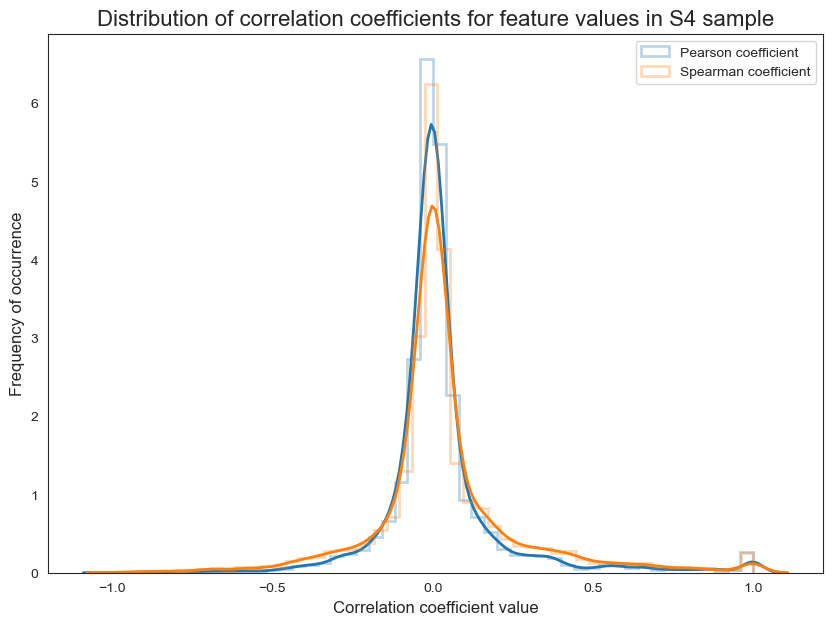

In [34]:
multi_compare_dist(d_list=[s4_corr_p, s4_corr_s],
                   d_labels=["Pearson coefficient", "Spearman coefficient"],
                   varname="Correlation coefficient value",
                   fig_title="Distribution of correlation coefficients for feature values in S4 sample",
                   fig_filename=IMAGE_FOLDER + "ML_20_01_S4_Correlation_distribution.jpg",
                   kde=True, hist=True, hist_fill=False)


#### Distribution for ML sample (original features)

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

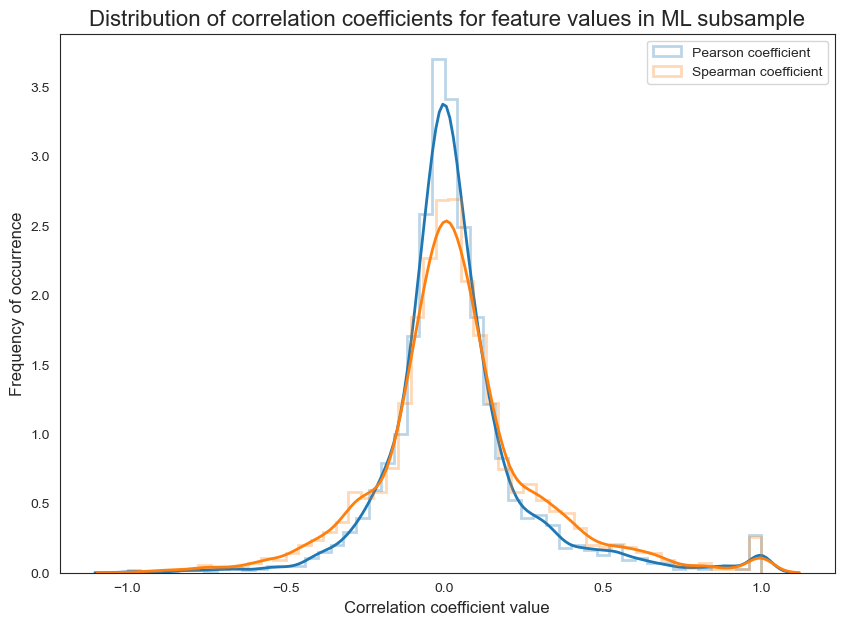

In [35]:
multi_compare_dist(d_list=[ml_corr_p, ml_corr_s],
                   d_labels=["Pearson coefficient", "Spearman coefficient"],
                   varname="Correlation coefficient value",
                   fig_title="Distribution of correlation coefficients for feature values in ML subsample",
                   fig_filename=IMAGE_FOLDER + "ML_20_02_ML_Correlation_distribution.jpg",
                   kde=True, hist=True, hist_fill=False)


**OBSERVATION:** we can clearly seen that many of the pair-wise correlation values, for both ML subsample and S4 sample, fall below the $\abs{0.5}$ value, which means low correlation of features in the samples. With this in mind, we will discourage the PCA analysis approach.

Anyway, we will try to carry out a PCA analysis to see which results we obtain.

## PCA calculation (all scaled features)

We now run a default PCA analysis to check if the results are as expected according to the correlation analysis.

At the moment, we won't be using the result of this PCA to feed the next step in ML pipeline, so we mostly leave the `PCA` parameters to their default values. The exception is `svd_solver`, which we set to `full` because our datasets are not very large.

In [36]:
np.set_printoptions(suppress=True)

### PCA analysis for S4 sample (scaled features)

#### PCA definition and application

In [37]:
pca_s4_sc = PCA(svd_solver='full')
pca_s4_sc

PCA(svd_solver='full')

In [38]:
pca_s4_sc.fit(s4_sc[cs_f_list])

PCA(svd_solver='full')

In [39]:
exp_var_s4_sc = pca_s4_sc.explained_variance_ratio_
exp_var_s4_sc

array([0.12206753, 0.091015  , 0.07336207, 0.05002302, 0.03591402,
       0.03217152, 0.03041591, 0.02391406, 0.02167947, 0.01908242,
       0.01784145, 0.01647364, 0.0160745 , 0.01570463, 0.01492793,
       0.01414358, 0.01397973, 0.0134902 , 0.01276683, 0.01201576,
       0.01184606, 0.01151694, 0.01118834, 0.01099806, 0.01042563,
       0.0103474 , 0.01007213, 0.00993639, 0.00955712, 0.00925297,
       0.00911043, 0.00876066, 0.00864107, 0.00848354, 0.0084604 ,
       0.00834051, 0.00802706, 0.00783901, 0.00742379, 0.00738863,
       0.00724634, 0.00704268, 0.00682294, 0.00662767, 0.00644484,
       0.00624972, 0.00612868, 0.00578625, 0.00568725, 0.00562103,
       0.00547554, 0.00525507, 0.00511893, 0.00498444, 0.00489984,
       0.00469331, 0.00457875, 0.0044229 , 0.00428602, 0.00423549,
       0.00406742, 0.00384508, 0.0036129 , 0.00308982, 0.00294036,
       0.00266427, 0.00247997, 0.00246825, 0.00229799, 0.00221379,
       0.00202891, 0.00188287, 0.00176043, 0.00158345, 0.00152

**OBSERVATION:** As we can see, we have to reach the $20^{th}$ value in the PCA components to see a component contributing to the variance a $10\%$ of the contributiion of the more important (i.e. $1^{st}$) component. According to this results, it would be not worth applying PCA to this problem.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [40]:
sv_s4_sc = pca_s4_sc.singular_values_
sv_s4_sc

array([115.17562872,  99.45279682,  89.28866063,  73.73020889,
        62.47302304,  59.12842082,  57.49245925,  50.97850976,
        48.53832573,  45.53834011,  44.03273127,  42.31119832,
        41.79546732,  41.31182913,  40.2772949 ,  39.2048867 ,
        38.97713786,  38.2886154 ,  37.24792127,  36.1356726 ,
        35.87959203,  35.37765806,  34.86931377,  34.57152833,
        33.65981024,  33.53328245,  33.08423573,  32.8605454 ,
        32.22730406,  31.71035423,  31.46515421,  30.85523458,
        30.64391272,  30.3633058 ,  30.32187484,  30.10626095,
        29.53511979,  29.18711076,  28.4035888 ,  28.3362466 ,
        28.06208924,  27.66493382,  27.22992442,  26.83742937,
        26.46467075,  26.06098749,  25.80739188,  25.07605939,
        24.86060431,  24.71545428,  24.3934906 ,  23.89734049,
        23.58576717,  23.2738776 ,  23.07552489,  22.58396778,
        22.30663141,  21.92370456,  21.58180681,  21.4542067 ,
        21.02422468,  20.44153184,  19.81474108,  18.32

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

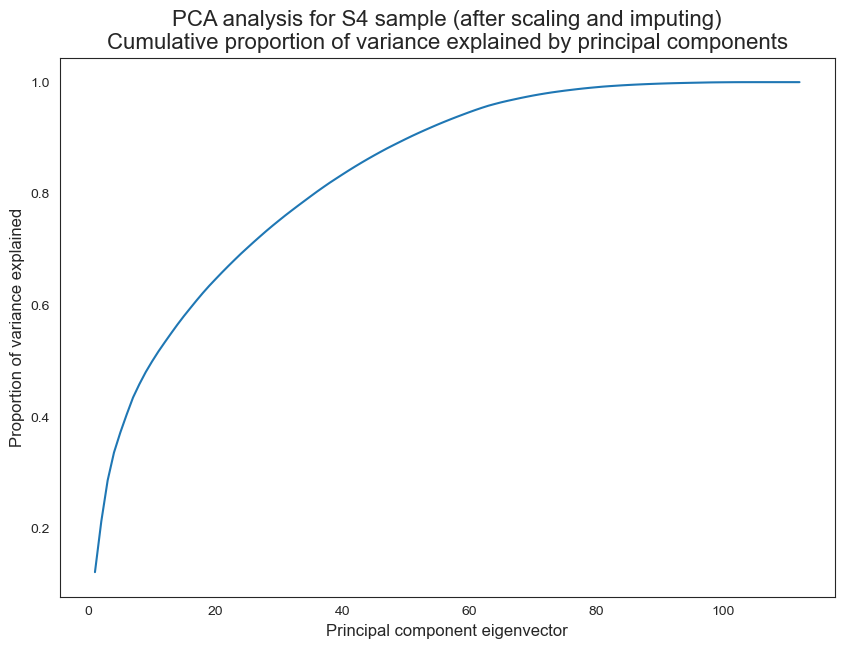

In [41]:
draw_lineplot(x=np.arange(1, len(exp_var_s4_sc) + 1),
              y=exp_var_s4_sc.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for S4 sample (after scaling and imputing)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_03_S4_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

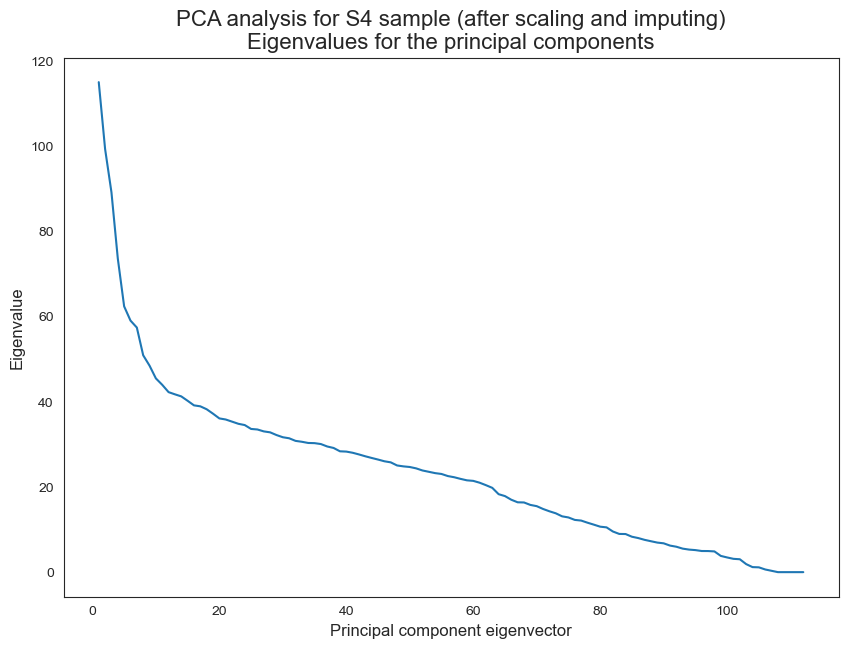

In [42]:
draw_lineplot(x=np.arange(1, len(sv_s4_sc) + 1),
              y=sv_s4_sc,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for S4 sample (after scaling and imputing)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_04_S4_PCA_Eigenvalues.jpg")

**OBSERVATION:** these plots clearly confirm that PCA will not greatly reduce the dimensions of the problem. In the plot for the proportion of variance explained, there is not an _elbow_, where adding another component does not significantly incrfease the variance explained: this only happens in the very last of the eigenvectors (between $60$ and $80$). Also, almost one third of the principal components (or eigenvectors) are needed to explain $80\%$ of the variance.

This confirms the intuition we had in view of the correlation coefficients.

### PCA analysis for pulsating stars in S4 sample (scaled features)

#### PCA definition and application

In [43]:
pca_s4p_sc = PCA(svd_solver='full')
pca_s4p_sc

PCA(svd_solver='full')

In [44]:
pca_s4p_sc.fit(s4p_sc[cs_f_list])

PCA(svd_solver='full')

In [45]:
exp_var_s4p_sc = pca_s4p_sc.explained_variance_ratio_
exp_var_s4p_sc

array([0.14878668, 0.08636727, 0.06499051, 0.04880781, 0.04048643,
       0.03624886, 0.03538913, 0.03225797, 0.02873914, 0.02732495,
       0.02426162, 0.02401015, 0.02337068, 0.02257094, 0.02140429,
       0.0192936 , 0.01793961, 0.01697825, 0.0168817 , 0.01575974,
       0.01398989, 0.01380285, 0.01328577, 0.01234257, 0.01194176,
       0.01158246, 0.01079871, 0.00995803, 0.00978046, 0.00965196,
       0.00919242, 0.0086388 , 0.0083397 , 0.00751356, 0.00728068,
       0.00683529, 0.00652831, 0.00647042, 0.00561296, 0.00532161,
       0.00485878, 0.00452074, 0.00435789, 0.0041643 , 0.00385817,
       0.00347166, 0.00326037, 0.00288883, 0.00279375, 0.00242882,
       0.00228806, 0.00193244, 0.00173588, 0.00165052, 0.00145955,
       0.00139562, 0.00127511, 0.00117131, 0.00100536, 0.00091251,
       0.00086517, 0.00073223, 0.00067917, 0.00062204, 0.00056441,
       0.0005308 , 0.00045635, 0.00040309, 0.00037255, 0.00034521,
       0.00028521, 0.00024129, 0.00021677, 0.00019901, 0.00017

**OBSERVATION:** As we can see, we have to reach the $21^{st}$ value in the PCA components to see a component contributing to the variance a $10\%$ of the contributiion of the more important (i.e. $1^{st}$) component. According to this results, it would be not worth applying PCA to this problem.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [46]:
sv_s4p_sc = pca_s4p_sc.singular_values_
sv_s4p_sc

array([36.16420468, 27.55316439, 23.90131944, 20.71292953, 18.86477567,
       17.850241  , 17.63728877, 16.83896535, 15.89402077, 15.49803191,
       14.6034947 , 14.52761417, 14.33284991, 14.08548072, 13.71662767,
       13.02277393, 12.55750439, 12.21640224, 12.18161759, 11.76986349,
       11.08929676, 11.01491673, 10.80663111, 10.41596833, 10.24545111,
       10.09014446,  9.7427786 ,  9.35585734,  9.27206599,  9.2109561 ,
        8.98900676,  8.71411952,  8.56193687,  8.12680588,  7.99986652,
        7.75131451,  7.57525802,  7.54159315,  7.02413376,  6.83940364,
        6.53522636,  6.30379191,  6.18920746,  6.05017461,  5.82354461,
        5.52415249,  5.35340494,  5.03915258,  4.95553712,  4.62055964,
        4.48467314,  4.1214475 ,  3.90622433,  3.80896898,  3.58183921,
        3.50251552,  3.34789081,  3.20872373,  2.97274396,  2.83215252,
        2.75770329,  2.53700291,  2.44335978,  2.33833214,  2.22737602,
        2.16003539,  2.00282987,  1.88234928,  1.80963396,  1.74

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

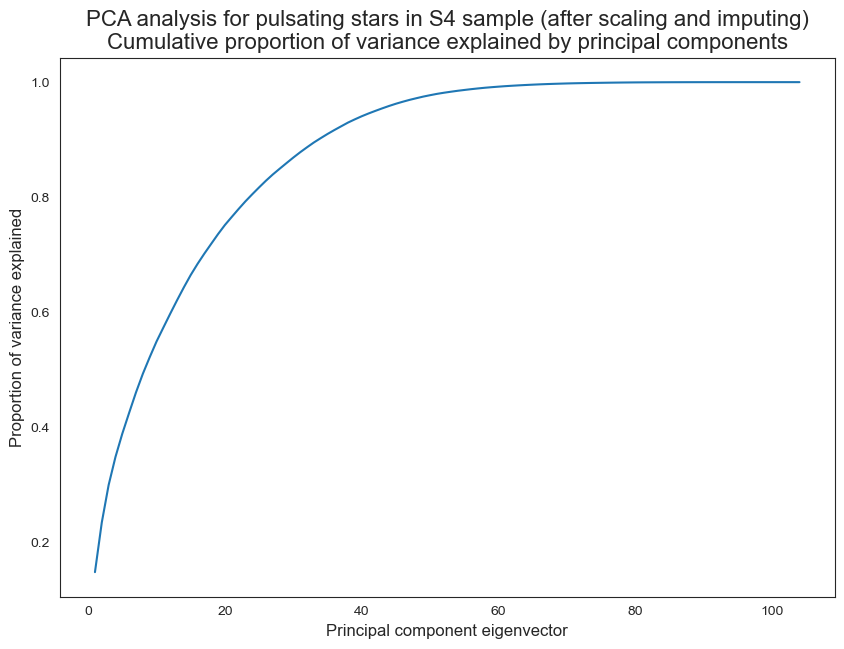

In [47]:
draw_lineplot(x=np.arange(1, len(exp_var_s4p_sc) + 1),
              y=exp_var_s4p_sc.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for pulsating stars in S4 sample (after scaling and imputing)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_03P_S4P_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

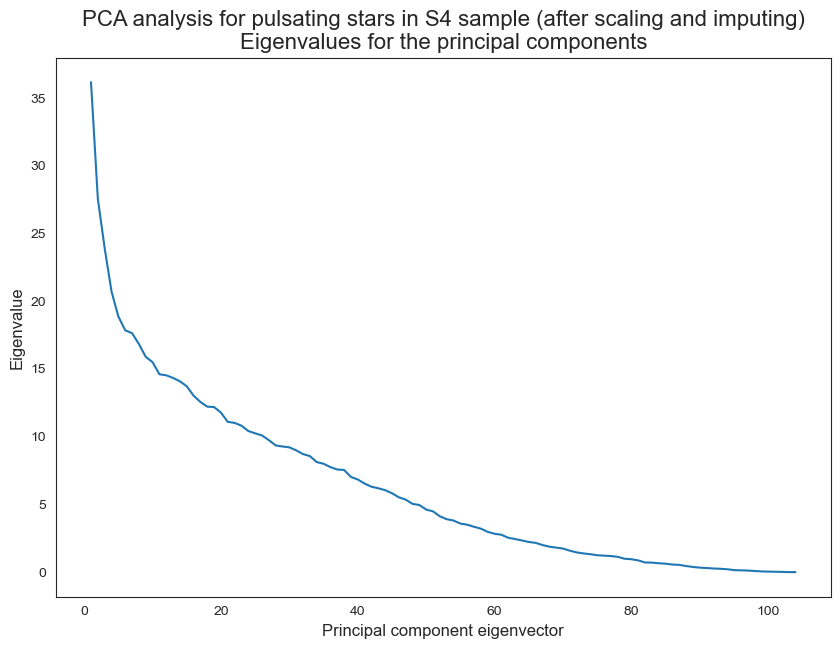

In [48]:
draw_lineplot(x=np.arange(1, len(sv_s4p_sc) + 1),
              y=sv_s4p_sc,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for pulsating stars in S4 sample (after scaling and imputing)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20P_04P_S4_PCA_Eigenvalues.jpg")

**OBSERVATION:** these plots clearly confirm that PCA will not greatly reduce the dimensions of the problem. In the plot for the proportion of variance explained, there is not an _elbow_, where adding another component does not significantly incrfease the variance explained: this only happens in the very last of the eigenvectors (between $60$ and $80$). Also, almost one third of the principal components (or eigenvectors) are needed to explain $80\%$ of the variance.

This confirms the intuition we had in view of the correlation coefficients.

### PCA analysis for non-pulsating stars in S4 sample (scaled features)

#### PCA definition and application

In [49]:
pca_s4np_sc = PCA(svd_solver='full')
pca_s4np_sc

PCA(svd_solver='full')

In [50]:
pca_s4np_sc.fit(s4np_sc[cs_f_list])

PCA(svd_solver='full')

In [51]:
exp_var_s4np_sc = pca_s4np_sc.explained_variance_ratio_
exp_var_s4np_sc

array([0.12272234, 0.09585734, 0.07585108, 0.0497966 , 0.03583949,
       0.03273766, 0.02977638, 0.02426538, 0.02181578, 0.01937296,
       0.01860296, 0.01719685, 0.01608248, 0.01598823, 0.01469385,
       0.01424061, 0.01396706, 0.01339043, 0.01249506, 0.01212767,
       0.01152482, 0.01134698, 0.01093678, 0.01080882, 0.01021801,
       0.01010507, 0.01002356, 0.00980382, 0.00930478, 0.0090184 ,
       0.0088776 , 0.00860857, 0.00852634, 0.00843334, 0.00821052,
       0.0080307 , 0.00794247, 0.00777861, 0.0074965 , 0.00717212,
       0.00707664, 0.00662401, 0.00654159, 0.00633368, 0.00615814,
       0.00594991, 0.00590811, 0.00557525, 0.0055008 , 0.00539886,
       0.00510473, 0.00505201, 0.00483885, 0.00476275, 0.00467691,
       0.00453263, 0.00437574, 0.00421179, 0.00415033, 0.00398108,
       0.00388545, 0.00364001, 0.00347214, 0.00303713, 0.00286196,
       0.00264175, 0.00255666, 0.00244816, 0.00230946, 0.00211236,
       0.00204484, 0.0018659 , 0.00172611, 0.00156686, 0.00148

**OBSERVATION:** Again, we have to reach the $21^{st}$ value in the PCA components to see a component contributing to the variance a $10\%$ of the contributiion of the more important (i.e. $1^{st}$) component. According to this results, it would be not worth applying PCA to this problem.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [52]:
sv_s4np_sc = pca_s4np_sc.singular_values_
sv_s4np_sc

array([110.62825124,  97.77254626,  86.97313486,  70.46996643,
        59.78402452,  57.13839939,  54.49293195,  49.19237644,
        46.64333978,  43.95438835,  43.07202226,  41.41223343,
        40.04799142,  39.93047167,  38.28001095,  37.6850055 ,
        37.32129906,  36.54277712,  35.29989146,  34.77706513,
        33.90169256,  33.63909883,  33.02546749,  32.83170711,
        31.92180144,  31.74489817,  31.61660071,  31.26812857,
        30.46191394,  29.98948633,  29.75445154,  29.30014693,
        29.15987496,  29.00040176,  28.61471791,  28.29963936,
        28.14375981,  27.8519298 ,  27.34220036,  26.74409407,
        26.5654856 ,  25.70187146,  25.54146528,  25.1323119 ,
        24.78158204,  24.3590023 ,  24.27328049,  23.5795965 ,
        23.42164037,  23.20359364,  22.5626786 ,  22.4458624 ,
        21.96721956,  21.79380861,  21.59652848,  21.26077893,
        20.88958444,  20.49451518,  20.34443919,  19.9252942 ,
        19.68453043,  19.05266755,  18.6081308 ,  17.40

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

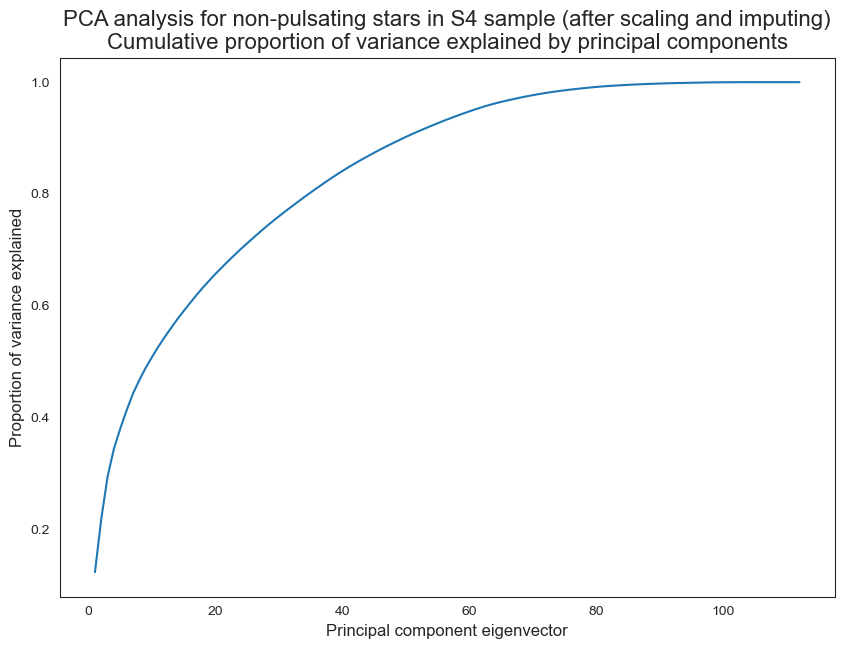

In [53]:
draw_lineplot(x=np.arange(1, len(exp_var_s4np_sc) + 1),
              y=exp_var_s4np_sc.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for non-pulsating stars in S4 sample (after scaling and imputing)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_03NP_S4NP_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

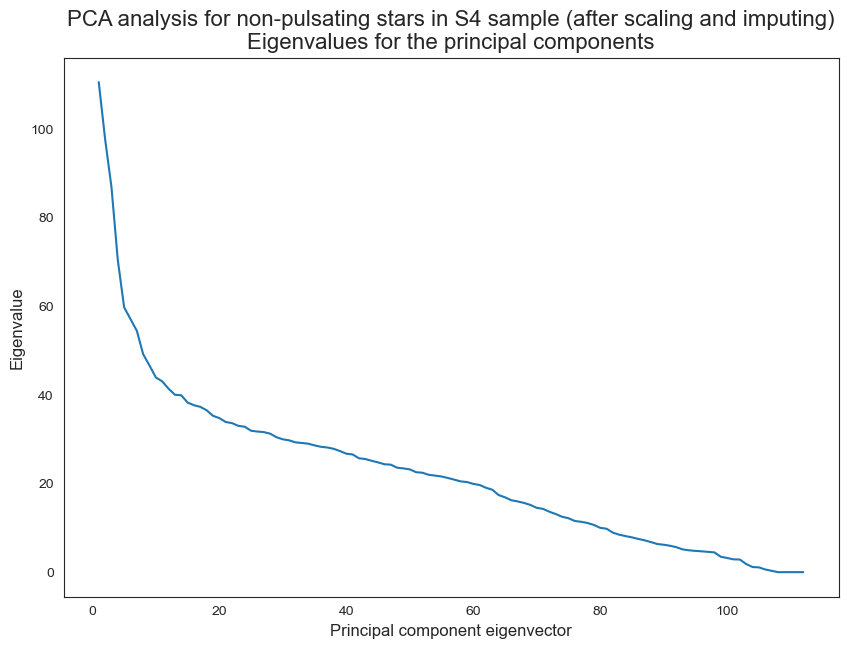

In [54]:
draw_lineplot(x=np.arange(1, len(sv_s4np_sc) + 1),
              y=sv_s4np_sc,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for non-pulsating stars in S4 sample (after scaling and imputing)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20NP_04NP_S4_PCA_Eigenvalues.jpg")

**OBSERVATION:** these plots clearly confirm that PCA will not greatly reduce the dimensions of the problem. In the plot for the proportion of variance explained, there is not an _elbow_, where adding another component does not significantly incrfease the variance explained: this only happens in the very last of the eigenvectors (between $60$ and $80$). Also, almost one third of the principal components (or eigenvectors) are needed to explain $80\%$ of the variance.

This confirms the intuition we had in view of the correlation coefficients.

### PCA analysis for ML subsample (scaled features)

#### PCA definition and application

In [55]:
pca_ml_sc = PCA(svd_solver='full')
pca_ml_sc

PCA(svd_solver='full')

In [56]:
pca_ml_sc.fit(ml_sc[cs_f_list])

PCA(svd_solver='full')

In [57]:
exp_var_ml_sc = pca_ml_sc.explained_variance_ratio_
exp_var_ml_sc

array([0.69758727, 0.30241273, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

**IMPORTANT OBSERVATION:** Well, now with just the first two components we explain $100\%$ of the variance. What's the reason for this.

Let's confirm with the eigenvalues.

In [58]:
sv_ml_sc = pca_ml_sc.singular_values_
sv_ml_sc

array([7.24488888e+08, 4.77015501e+08, 1.37813681e+02, 1.25360008e+02,
       1.15388196e+02, 7.82400116e+01, 7.61809566e+01, 7.01799223e+01,
       5.09098003e+01, 4.14837356e+01, 3.79917872e+01, 3.73815690e+01,
       3.63568030e+01, 3.42589266e+01, 3.31460955e+01, 3.14146417e+01,
       3.11316493e+01, 2.79373681e+01, 2.69837895e+01, 2.65040063e+01,
       2.50621941e+01, 2.43784443e+01, 2.39316427e+01, 2.22882095e+01,
       2.16561214e+01, 2.13190345e+01, 2.03339431e+01, 2.00391350e+01,
       1.95406266e+01, 1.89955078e+01, 1.83950377e+01, 1.80377046e+01,
       1.73224749e+01, 1.69216164e+01, 1.65350888e+01, 1.58433845e+01,
       1.54401413e+01, 1.52117821e+01, 1.50578039e+01, 1.46739943e+01,
       1.45729608e+01, 1.37773898e+01, 1.37064277e+01, 1.34556945e+01,
       1.33438006e+01, 1.30963445e+01, 1.25705948e+01, 1.22066414e+01,
       1.21788353e+01, 1.16831949e+01, 1.12232707e+01, 1.10802178e+01,
       1.09039915e+01, 1.08101012e+01, 1.01357308e+01, 9.93174719e+00,
      

**OBSERVATION:** as expected, the eigenvalues confirm the variance explained results: the first two values are much larger than the rest.

#### Cumulative variance explained plot

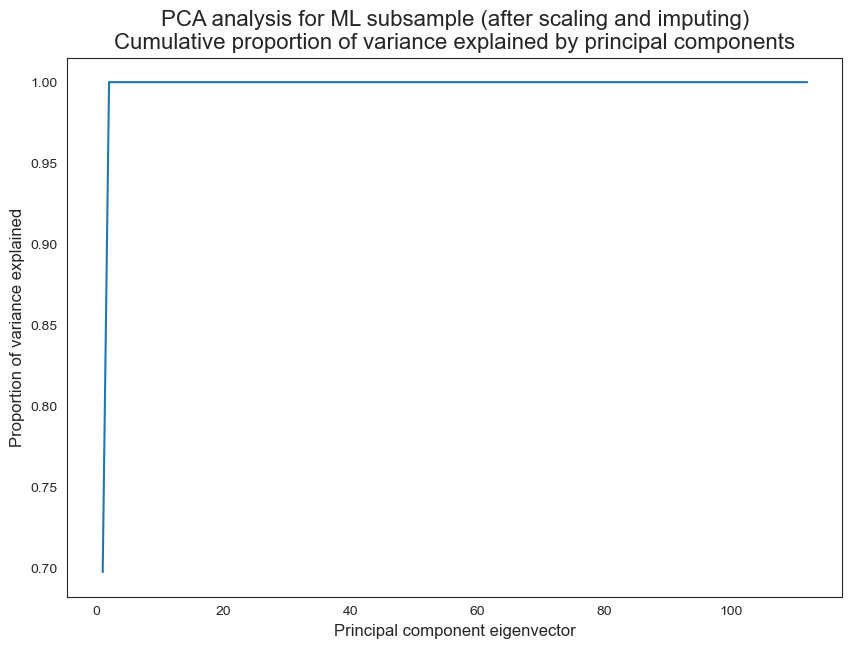

In [59]:
draw_lineplot(x=np.arange(1, len(exp_var_ml_sc) + 1),
              y=exp_var_ml_sc.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for ML subsample (after scaling and imputing)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_05_ML_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

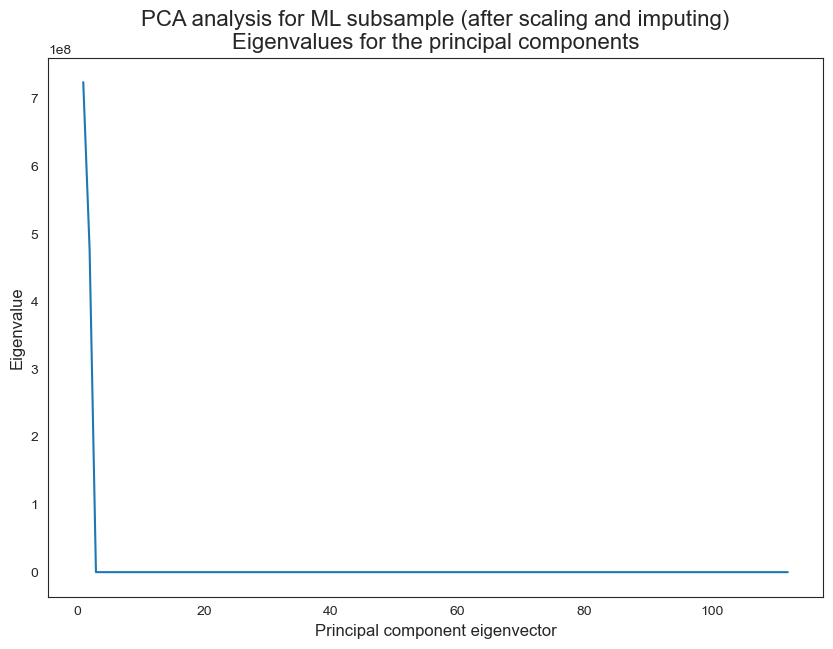

In [60]:
draw_lineplot(x=np.arange(1, len(sv_ml_sc) + 1),
              y=sv_ml_sc,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for ML subsample (after scaling and imputing)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_06_ML_PCA_Eigenvalues.jpg")

**IMPORTANT OBSERVATION:** the results of the PCA analysis for the ML subsample greatly differ from those obtained for the S4 sample.

Let's try to investigate the root cause for this. Our first intuition points to the scaling (remember that the scaler we applied to the ML subsample were trained with the S4 sample, and that originally many features showed very different distributions for ML sample and S4 sample).

#### Discrepancy analysis

##### Search for "offending" PCA components and features

Let's first see what are the original features that PCA says are the driving force for the variace of the data: the first two eigenvectors.

In [61]:
pca_ml_sc.components_

array([[ 0.        , -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [ 0.        , -0.        , -0.        , ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.00828603, -0.01240492, -0.00719442, ..., -0.01042031,
        -0.03047696,  0.01342438],
       ...,
       [-0.        , -0.        , -0.        , ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
        -0.        ,  0.        ]])

In [62]:
pca_ml_sc.components_[0:2]

array([[ 0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00000001,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        ,  0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.0

**OBSERVATION:** it seems clear that there are two very important components. Let's see what features build those components.

First eigenvector:

In [63]:
feat_idx_1 = list(np.where(np.logical_not(np.isclose(np.abs(pca_ml_sc.components_[0]), 0)))[0].flatten())
feat_idx_1

[68, 69, 70, 80, 96, 97, 98, 99]

In [64]:
original_features_1 = [cs_f_list[i] for i in feat_idx_1]
original_features_1

['freq1_amplitude2',
 'freq1_amplitude3',
 'freq1_amplitude4',
 'freq2_amplitude4',
 'freq_frequency_ratio_31',
 'freq_model_max_delta_mags',
 'freq_model_min_delta_mags',
 'freq_model_phi1_phi2']

Second eigenvector:

In [65]:
feat_idx_2 = list(np.where(np.logical_not(np.isclose(np.abs(pca_ml_sc.components_[1]), 0)))[0].flatten())
feat_idx_2

[68, 70, 97, 98, 99]

In [66]:
original_features_2 = [cs_f_list[i] for i in feat_idx_2]
original_features_2

['freq1_amplitude2',
 'freq1_amplitude4',
 'freq_model_max_delta_mags',
 'freq_model_min_delta_mags',
 'freq_model_phi1_phi2']

##### Check the statistics for the "offending" features

Let's check the statistics of these features in the scaled S4 sample and ML subsample (in order not to impact PCA so much, they should be not far from the general statistics of the other fetures):

In [67]:
s4_sc[original_features_1].describe().loc[['mean', 'std', 'min', 'max']]

freq1_amplitude2  freq1_amplitude3  freq1_amplitude4  freq2_amplitude4  \
mean     -1.953993e-16      2.131628e-17     -2.948752e-16      8.171241e-17   
std       1.000500e+00      1.000500e+00      1.000500e+00      1.000500e+00   
min      -1.416690e+00     -1.458625e+00     -1.477945e+00     -1.333309e+00   
max       5.024732e+00      5.741186e+00      3.928956e+00      6.143756e+00   

      freq_frequency_ratio_31  freq_model_max_delta_mags  \
mean             4.440892e-17              -7.105427e-18   
std              1.000500e+00               1.000500e+00   
min             -1.110932e-01              -8.413333e-01   
max              2.108317e+01               7.293880e+00   

      freq_model_min_delta_mags  freq_model_phi1_phi2  
mean               1.136868e-16         -1.413980e-15  
std                1.000500e+00          1.000500e+00  
min               -1.034562e+00         -2.881777e+00  
max                4.700691e+00          3.322138e+00

In [68]:
ml_sc[original_features_1].describe().loc[['mean', 'std', 'min', 'max']]

freq1_amplitude2  freq1_amplitude3  freq1_amplitude4  freq2_amplitude4  \
mean          2.346884          2.166728          2.444411          1.593917   
std           3.631161          3.717248          5.406896          2.451044   
min          -1.416690         -1.458625         -1.477945         -1.333309   
max          27.184592         36.367995         69.152318         18.385302   

      freq_frequency_ratio_31  freq_model_max_delta_mags  \
mean                 1.156931               2.501371e+06   
std                  8.731595               3.223083e+07   
min                 -0.111176              -8.413333e-01   
max                114.666926               4.826359e+08   

      freq_model_min_delta_mags  freq_model_phi1_phi2  
mean               4.390498e+06             -0.046275  
std                4.695101e+07              1.474827  
min               -1.034562e+00             -9.207093  
max                6.426181e+08              3.861548

**OBSERVATION:** Ok, this is pretty clear now. It seems that ML subsample have some outliers which completely distort the mean value (setting it far apart from 0.0) and, most importantly, greatly inflate the standard deviation, more specially in `freq_model_max_delta_mags` and `freq_model_min_delta_mags`, which are the features with the highest coefficients in the first two eigenvectors.

And for _"normal"_ features, we have instead:

In [69]:
normal_features_1 = [i for i in list(cs_f_list) if i not in original_features_1]
print(normal_features_1)

['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'mean', 'med_double_to_single_step', 'med_err', 'n_epochs', 'std_double_to_single_step', 'std_err', 'total_time', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65',

In [70]:
opt_backup = pd.get_option('display.max_columns')
pd.set_option('display.max_columns', None)
s4_sc[normal_features_1].describe().loc[['mean', 'std', 'min', 'max']]

all_times_nhist_numpeaks  all_times_nhist_peak1_bin  \
mean              2.042810e-16              -1.953993e-17   
std               1.000500e+00               1.000500e+00   
min              -2.261797e+00              -1.290522e+00   
max               2.818753e+00               2.120058e+00   

      all_times_nhist_peak2_bin  all_times_nhist_peak3_bin  \
mean                   0.013120                   0.008403   
std                    0.999531                   0.986335   
min                   -1.646320                  -1.855656   
max                    2.051432                   1.815078   

      all_times_nhist_peak4_bin  all_times_nhist_peak_1_to_2  \
mean                   0.008973                     0.010104   
std                    0.979915                     0.999016   
min                   -1.997135                    -0.692478   
max                    1.786498                     9.055207   

      all_times_nhist_peak_1_to_3  all_times_nhist_peak_1_to_4  \
mean                     0.008548                     0.009590   
std                      0.984756                     0.977878   
min                     -0.772586                    -0.845233   
max                      9.206710                     6.394783   

      all_times_nhist_peak_2_to_3  all_times_nhist_peak_2_to_4  \
mean                     0.004216                     0.003833   
std                      0.983474                     0.971437   
min                     -0.528719                    -0.775993   
max                     10.948373                     6.631195   

      all_times_nhist_peak_3_to_4  all_times_nhist_peak_val  \
mean                     0.007513              2.664535e-17   
std                      0.970463              1.000500e+00   
min                     -0.720581             -1.240216e-01   
max                      5.266898              1.390480e+01   

      avg_double_to_single_step       avg_err          avgt  cad_probs_1  \
mean              -4.973799e-17  9.414691e-17 -1.064322e-13          0.0   
std                1.000500e+00  1.000500e+00  1.000500e+00          0.0   
min               -2.229976e+01 -8.243156e-01 -8.640580e-01          0.0   
max                3.589349e-01  1.045553e+01  2.166482e+01          0.0   

      cad_probs_10  cad_probs_20  cad_probs_30  cad_probs_40  cad_probs_50  \
mean  5.684342e-17  1.172396e-16  6.039613e-17  5.329071e-17  2.842171e-17   
std   1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min  -8.780554e-02 -1.734011e-01 -1.922405e-01 -2.129366e-01 -2.180802e-01   
max   2.149941e+01  1.717244e+01  1.419127e+01  1.305016e+01  1.305408e+01   

      cad_probs_100  cad_probs_500  cad_probs_1000  cad_probs_5000  \
mean   1.207923e-16   6.217249e-17    6.572520e-17   -2.655653e-16   
std    1.000500e+00   1.000500e+00    1.000500e+00    1.000500e+00   
min   -2.447743e-01  -2.740509e-01   -2.759275e-01   -1.305583e+00   
max    1.241067e+01   1.007894e+01    1.007001e+01    2.682952e+00   

      cad_probs_10000  cad_probs_50000  cad_probs_100000  cad_probs_500000  \
mean    -2.522427e-16     3.161915e-16     -6.075140e-16     -1.947775e-15   
std      1.000500e+00     1.000500e+00      1.000500e+00      1.000500e+00   
min     -1.673191e+00    -4.274322e+00     -4.771597e+00     -4.073995e+00   
max      2.087630e+00     1.155035e+00      1.008356e+00      6.632089e-01   

      cad_probs_1000000  cad_probs_5000000  cad_probs_10000000      cads_avg  \
mean      -9.903189e-16                0.0                 0.0 -4.263256e-17   
std        1.000500e+00                0.0                 0.0  1.000500e+00   
min       -3.727433e+00                0.0                 0.0 -1.026829e+00   
max        4.459860e-01                0.0                 0.0  3.358258e+00   

          cads_med      cads_std          mean  med_double_to_single_step  \
mean  3.197442e-17 -1.163514e-16  3.552714e-18              -2.842171e-17   
std   1.000500e+00  1

In [71]:
pd.set_option('display.max_columns', opt_backup)

In [72]:
opt_backup = pd.get_option('display.max_columns')
pd.set_option('display.max_columns', None)
ml_sc[normal_features_1].describe().loc[['mean', 'std', 'min', 'max']]

all_times_nhist_numpeaks  all_times_nhist_peak1_bin  \
mean                  0.069968                  -0.034668   
std                   1.018428                   0.983767   
min                  -2.261797                  -1.290522   
max                   2.818753                   2.120058   

      all_times_nhist_peak2_bin  all_times_nhist_peak3_bin  \
mean                  -0.084020                  -0.011521   
std                    0.992167                   0.988653   
min                   -1.646320                  -1.855656   
max                    2.051432                   1.815078   

      all_times_nhist_peak4_bin  all_times_nhist_peak_1_to_2  \
mean                   0.011056                     0.019749   
std                    0.976004                     1.105752   
min                   -1.997135                    -0.692478   
max                    1.786498                     9.055207   

      all_times_nhist_peak_1_to_3  all_times_nhist_peak_1_to_4  \
mean                    -0.007724                    -0.026595   
std                      0.989249                     0.951964   
min                     -0.772586                    -0.845233   
max                      9.206710                     6.394783   

      all_times_nhist_peak_2_to_3  all_times_nhist_peak_2_to_4  \
mean                    -0.025644                    -0.043416   
std                      0.940549                     0.933208   
min                     -0.528719                    -0.775993   
max                     10.948373                     6.631195   

      all_times_nhist_peak_3_to_4  all_times_nhist_peak_val  \
mean                    -0.031832                 -0.014309   
std                      0.932827                  0.928232   
min                     -0.720581                 -0.124022   
max                      5.266898                 13.904796   

      avg_double_to_single_step    avg_err      avgt  cad_probs_1  \
mean                  -0.053577   0.052484 -0.038929          0.0   
std                    1.465831   1.308980  0.378797          0.0   
min                  -22.300347  -0.634695 -0.854863          0.0   
max                    0.358935  13.111248  1.057308          0.0   

      cad_probs_10  cad_probs_20  cad_probs_30  cad_probs_40  cad_probs_50  \
mean      0.052885      0.077958      0.077607      0.080227      0.078551   
std       1.440602      1.347996      1.297258      1.270818      1.270715   
min      -0.087806     -0.173401     -0.192240     -0.212937     -0.218080   
max      21.499412     17.172438     14.191265     13.050158     13.054085   

      cad_probs_100  cad_probs_500  cad_probs_1000  cad_probs_5000  \
mean       0.080503       0.079021        0.078536       -0.026776   
std        1.252224       1.181593        1.181552        0.997319   
min       -0.244774      -0.274051       -0.275928       -1.305583   
max       12.410675      10.078944       10.070014        2.682952   

      cad_probs_10000  cad_probs_50000  cad_probs_100000  cad_probs_500000  \
mean        -0.030954        -0.030382         -0.004951          0.029341   
std          1.002108         1.005192          0.982477          0.962328   
min         -1.673191        -4.274322         -4.771597         -4.073995   
max          2.087630         1.155035          1.008356          0.663209   

      cad_probs_1000000  cad_probs_5000000  cad_probs_10000000  cads_avg  \
mean           0.041161                0.0                 0.0 -0.015354   
std            0.937160                0.0                 0.0  0.959253   
min           -3.727433                0.0                 0.0 -1.026829   
max            0.445986                0.0                 0.0  3.358258   

      cads_med  cads_std      mean  med_double_to_single_step    med_err  \
mean  0.021084 -0.033920  0.196686                   0.011055   0.081867   
std   1.008110  0.964584  0.944332                   0.929944   1.493940   
mi

In [73]:
pd.set_option('display.max_columns', opt_backup)

For sure, there seems to be some variations, but no such extreme values as for the "offending" features (even if for some other features, the standard deviation goes the other way: it shrinks to values much lower than the desired value of 1.0).

In order to confirm this could be the problem, let's try the PCA analysis in two other scenarios: using only "reliable" features (i.e. those with similar distributions for ML subsample and S4 sample); and using only "unreliable" features (i.e. those for wichh the distributions for ML subsample and S4 sample greatly differ).

### Comparing results for ML subsample and S4 sample (scaled features)

We now compare the PCA results for both: eigenvectors and eigenvalues.

#### Eigenvectors

In [74]:
comp_diff_sc = pca_s4_sc.components_ - pca_ml_sc.components_
comp_diff_sc

array([[ 0.08052959, -0.04886881, -0.0839831 , ..., -0.00796017,
        -0.03158677,  0.17664388],
       [-0.01501614,  0.01104938,  0.01200135, ...,  0.00933157,
        -0.00477725, -0.04841774],
       [-0.08263026,  0.05388604,  0.05701193, ...,  0.08257646,
         0.06859604, -0.01544108],
       ...,
       [ 0.        , -0.        ,  0.        , ..., -0.        ,
         0.        , -0.        ],
       [-0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [-0.        ,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [75]:
pd.Series(comp_diff_sc.flatten()).describe()

count    12544.000000
mean         0.001650
std          0.133515
min         -0.973030
25%         -0.050229
50%          0.000000
75%          0.051965
max          1.035734
dtype: float64

#### Eigenvalues

In [76]:
sv_diff_sc = pca_s4_sc.singular_values_ - pca_ml_sc.singular_values_
sv_diff_sc

array([-7.24488773e+08, -4.77015401e+08, -4.85250203e+01, -5.16297995e+01,
       -5.29151731e+01, -1.91115908e+01, -1.86884973e+01, -1.92014125e+01,
       -2.37147461e+00,  4.05460454e+00,  6.04094405e+00,  4.92962930e+00,
        5.43866435e+00,  7.05290249e+00,  7.13119935e+00,  7.79024505e+00,
        7.84548859e+00,  1.03512473e+01,  1.02641317e+01,  9.63166629e+00,
        1.08173979e+01,  1.09992138e+01,  1.09376711e+01,  1.22833189e+01,
        1.20036888e+01,  1.22142480e+01,  1.27502926e+01,  1.28214104e+01,
        1.26866775e+01,  1.27148464e+01,  1.30701165e+01,  1.28175299e+01,
        1.33214379e+01,  1.34416894e+01,  1.37867860e+01,  1.42628765e+01,
        1.40949785e+01,  1.39753286e+01,  1.33457849e+01,  1.36622523e+01,
        1.34891284e+01,  1.38875440e+01,  1.35234968e+01,  1.33817348e+01,
        1.31208702e+01,  1.29646430e+01,  1.32367970e+01,  1.28694180e+01,
        1.26817690e+01,  1.30322594e+01,  1.31702199e+01,  1.28171227e+01,
        1.26817757e+01,  

In [77]:
pd.Series(sv_diff_sc.flatten()).describe()

count    1.120000e+02
mean    -1.072771e+07
std      8.162418e+07
min     -7.244888e+08
25%      3.705848e+00
50%      8.485062e+00
75%      1.265961e+01
max      1.426288e+01
dtype: float64

## PCA calculation (only "reliable" features)

In [78]:
np.set_printoptions(suppress=True)

### PCA analysis for S4 sample ("reliable", scaled features)

#### PCA definition and application

In [79]:
pca_s4_sc_rel = PCA(svd_solver='full')
pca_s4_sc_rel

PCA(svd_solver='full')

In [80]:
pca_s4_sc_rel.fit(s4_sc[rel_features])

PCA(svd_solver='full')

In [81]:
exp_var_s4_sc_rel = pca_s4_sc_rel.explained_variance_ratio_
exp_var_s4_sc_rel

array([0.20642854, 0.13385306, 0.08227808, 0.04264244, 0.03774002,
       0.03241131, 0.02918257, 0.02789309, 0.02692089, 0.0258458 ,
       0.02546122, 0.02393314, 0.02376479, 0.02328542, 0.02256333,
       0.02194312, 0.02121149, 0.02040272, 0.01972592, 0.01895208,
       0.0177369 , 0.01762816, 0.01675467, 0.01536809, 0.01400193,
       0.01135457, 0.0083963 , 0.00648969, 0.00576494, 0.00526013,
       0.00396114, 0.00252079, 0.00206112, 0.00172501, 0.00112587,
       0.00087777, 0.0007465 , 0.00064707, 0.00034316, 0.00028998,
       0.0002401 , 0.00022159, 0.00003358, 0.00000958, 0.00000234,
       0.        , 0.        , 0.        ])

**OBSERVATION:** As we can see, we have to reach the $18^{th}$ value in the PCA components to see a component contributing to the variance a $10\%$ of the contributiion of the more important (i.e. $1^{st}$) component. According to this results, it would be not worth applying PCA to this problem.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [82]:
sv_s4_sc_rel = pca_s4_sc_rel.singular_values_
sv_s4_sc_rel

array([96.05931196, 77.35150245, 60.6452341 , 43.6591853 , 41.07292578,
       38.06299084, 36.11738891, 35.31042141, 34.68960259, 33.98987734,
       33.73604503, 32.70803418, 32.59279253, 32.26239476, 31.75822205,
       31.3187043 , 30.79215907, 30.19942171, 29.69431171, 29.1060349 ,
       28.15746188, 28.07101016, 27.36671033, 26.20985031, 25.01777062,
       22.52889637, 19.37307746, 17.03203251, 16.05285064, 15.33391361,
       13.30652815, 10.61508211,  9.5985704 ,  8.78112638,  7.09411772,
        6.26390981,  5.77654637,  5.37812128,  3.91655018,  3.60030406,
        3.27606948,  3.14721807,  1.22507678,  0.6545052 ,  0.32361542,
        0.        ,  0.        ,  0.        ])

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

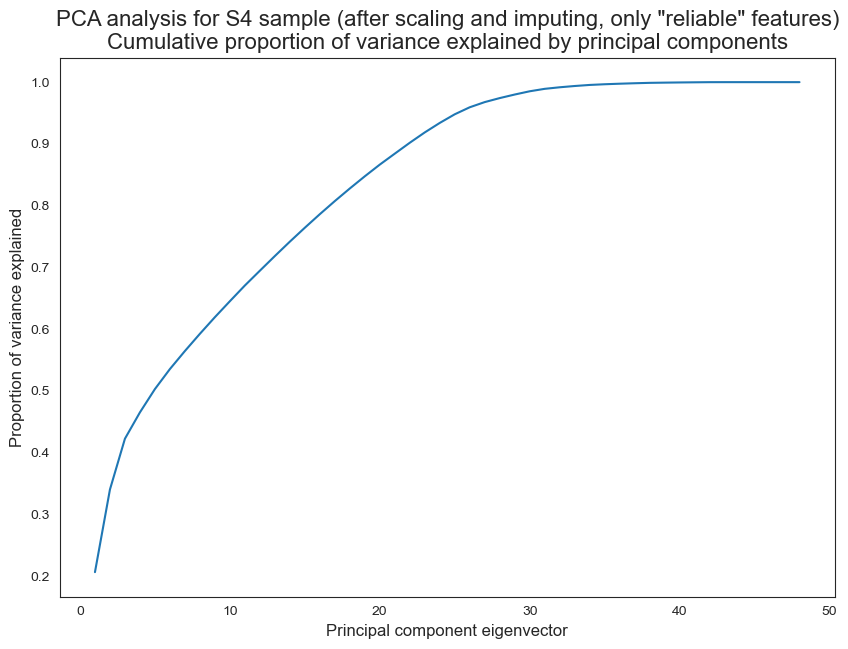

In [83]:
draw_lineplot(x=np.arange(1, len(exp_var_s4_sc_rel) + 1),
              y=exp_var_s4_sc_rel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for S4 sample (after scaling and imputing, only \"reliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_07_S4RelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

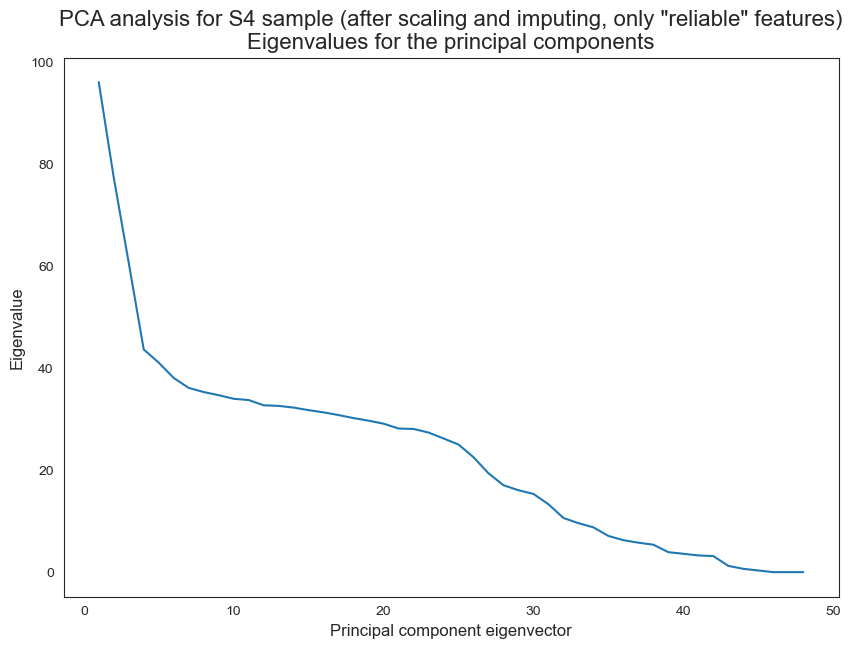

In [84]:
draw_lineplot(x=np.arange(1, len(sv_s4_sc_rel) + 1),
              y=sv_s4_sc_rel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for S4 sample (after scaling and imputing, only \"reliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_08_S4RelFeatures_PCA_Eigenvalues.jpg")

**OBSERVATION:** the _"elbow"_ is seen at $\sim30^{th}$ component, more than half. So PCA would not make too much sense here.

### PCA analysis for pulsating stars in S4 sample ("reliable", scaled features)

#### PCA definition and application

In [85]:
pca_s4p_sc_rel = PCA(svd_solver='full')
pca_s4p_sc_rel

PCA(svd_solver='full')

In [86]:
pca_s4p_sc_rel.fit(s4p_sc[rel_features])

PCA(svd_solver='full')

In [87]:
exp_var_s4p_sc_rel = pca_s4p_sc_rel.explained_variance_ratio_
exp_var_s4p_sc_rel

array([0.17968566, 0.11109076, 0.07795946, 0.06173916, 0.05286085,
       0.04580804, 0.04218575, 0.03970425, 0.03794956, 0.03594315,
       0.03499474, 0.03018483, 0.02729417, 0.02604679, 0.02454428,
       0.02161503, 0.02010527, 0.01811809, 0.01661789, 0.01633891,
       0.01482595, 0.01288853, 0.00947221, 0.00875801, 0.00747647,
       0.00640772, 0.00409216, 0.00306811, 0.00264259, 0.0024275 ,
       0.00183608, 0.00116615, 0.00112179, 0.00086673, 0.00059076,
       0.00056417, 0.00035942, 0.0003089 , 0.00017974, 0.00010178,
       0.00003227, 0.00001936, 0.00000576, 0.00000109, 0.0000001 ,
       0.        , 0.        , 0.        ])

**OBSERVATION:** As we can see, we have to reach the $19^{th}$ value in the PCA components to see a component contributing to the variance a $10\%$ of the contributiion of the more important (i.e. $1^{st}$) component. According to this results, it would be not worth applying PCA to this problem.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [88]:
sv_s4p_sc_rel = pca_s4p_sc_rel.singular_values_
sv_s4p_sc_rel

array([26.07029411, 20.49878812, 17.172109  , 15.28162604, 14.14022336,
       13.16315724, 12.63200001, 12.25484171, 11.98098686, 11.65996615,
       11.50510556, 10.685223  , 10.16071213,  9.92581755,  9.63528154,
        9.04205574,  8.72055497,  8.27838152,  7.92824683,  7.86141557,
        7.48859722,  6.98217785,  5.98570044,  5.75561766,  5.31786749,
        4.92312663,  3.93428085,  3.40662931,  3.16158056,  3.0301817 ,
        2.63533242,  2.10023098,  2.05989762,  1.81063117,  1.49484076,
        1.46081307,  1.1659832 ,  1.08093291,  0.82453006,  0.62046083,
        0.34936693,  0.27059217,  0.14765115,  0.06407733,  0.01984692,
        0.        ,  0.        ,  0.        ])

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

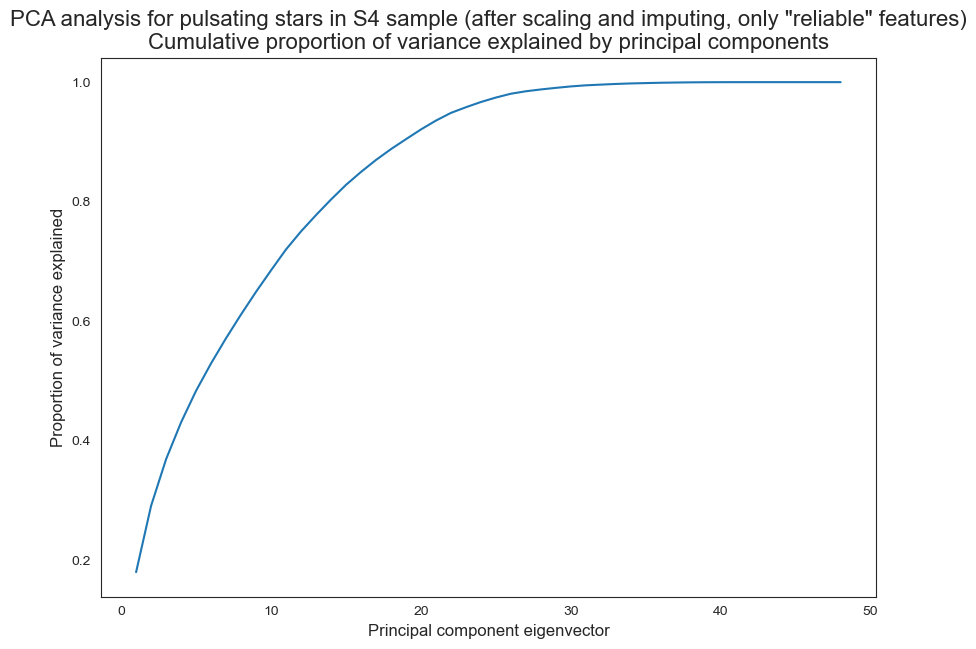

In [89]:
draw_lineplot(x=np.arange(1, len(exp_var_s4p_sc_rel) + 1),
              y=exp_var_s4p_sc_rel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for pulsating stars in S4 sample (after scaling and imputing, only \"reliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_07P_S4PRelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

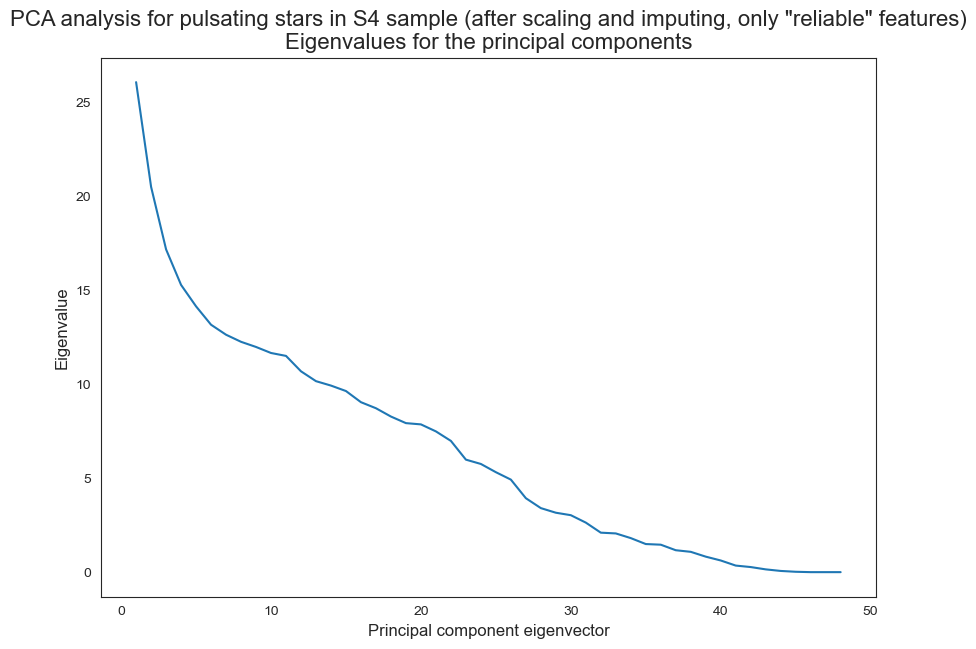

In [90]:
draw_lineplot(x=np.arange(1, len(sv_s4p_sc_rel) + 1),
              y=sv_s4p_sc_rel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for pulsating stars in S4 sample (after scaling and imputing, only \"reliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_08P_S4PRelFeatures_PCA_Eigenvalues.jpg")

**OBSERVATION:** the _"elbow"_ is seen at $\sim30^{th}$ component, more than half. So PCA would not make too much sense here.

### PCA analysis for non-pulsating stars in S4 sample ("reliable", scaled features)

#### PCA definition and application

In [91]:
pca_s4np_sc_rel = PCA(svd_solver='full')
pca_s4np_sc_rel

PCA(svd_solver='full')

In [92]:
pca_s4np_sc_rel.fit(s4np_sc[rel_features])

PCA(svd_solver='full')

In [93]:
exp_var_s4np_sc_rel = pca_s4np_sc_rel.explained_variance_ratio_
exp_var_s4np_sc_rel

array([0.21655727, 0.13566562, 0.08142783, 0.04211978, 0.0388713 ,
       0.03267396, 0.02798081, 0.02695467, 0.0263123 , 0.02557766,
       0.02482438, 0.02391843, 0.02324365, 0.02261622, 0.02208855,
       0.02134057, 0.02085892, 0.01953289, 0.0189602 , 0.01860275,
       0.01730653, 0.0166922 , 0.0165321 , 0.01496875, 0.01373797,
       0.01113854, 0.00812327, 0.00627544, 0.00564719, 0.00520386,
       0.00397354, 0.00243387, 0.00185527, 0.00174145, 0.00102492,
       0.0008678 , 0.00071052, 0.00055983, 0.0003155 , 0.00027331,
       0.00022676, 0.00021586, 0.00003556, 0.00000977, 0.00000239,
       0.        , 0.        , 0.        ])

**OBSERVATION:** As we can see, we have to reach the $19^{th}$ value in the PCA components to see a component contributing to the variance a $10\%$ of the contributiion of the more important (i.e. $1^{st}$) component. According to this results, it would be not worth applying PCA to this problem.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [94]:
sv_s4np_sc_rel = pca_s4np_sc_rel.singular_values_
sv_s4np_sc_rel

array([94.09513666, 74.47588779, 57.69885974, 41.49768287, 39.86532875,
       36.54952044, 33.82290405, 33.19692086, 32.79897205, 32.3378563 ,
       31.85811052, 31.27138826, 30.82711744, 30.4082065 , 30.05138132,
       29.53818545, 29.20294789, 28.25947277, 27.84211994, 27.57841908,
       26.6002519 , 26.12387324, 25.99828944, 24.73851371, 23.69966081,
       21.34002621, 18.22410731, 16.01780143, 15.19487327, 14.58624114,
       12.7458659 ,  9.97537778,  8.70933162,  8.43793725,  6.47331156,
        5.95650475,  5.38973839,  4.78421622,  3.59152459,  3.34280978,
        3.04486377,  2.97076373,  1.20568959,  0.63202953,  0.31273837,
        0.        ,  0.        ,  0.        ])

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

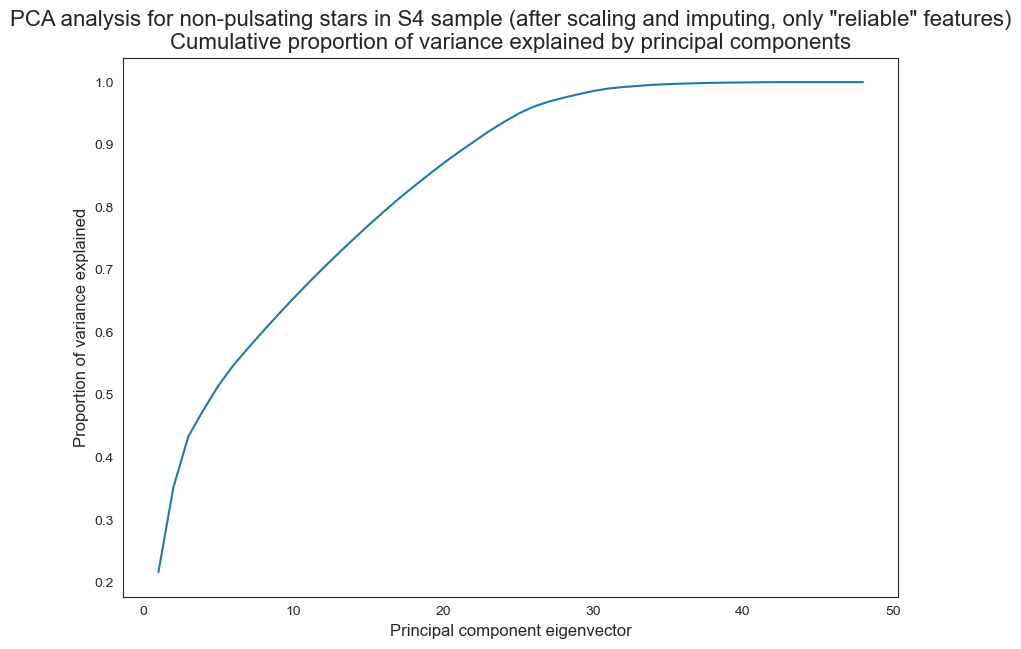

In [95]:
draw_lineplot(x=np.arange(1, len(exp_var_s4np_sc_rel) + 1),
              y=exp_var_s4np_sc_rel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for non-pulsating stars in S4 sample (after scaling and imputing, only \"reliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_07NP_S4NPRelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

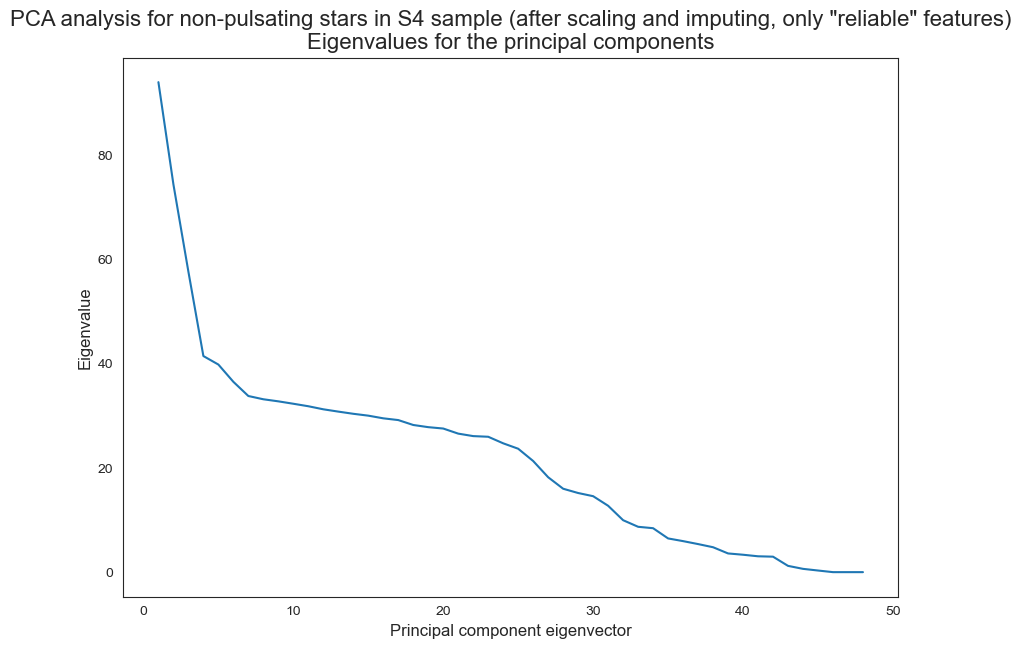

In [96]:
draw_lineplot(x=np.arange(1, len(sv_s4np_sc_rel) + 1),
              y=sv_s4np_sc_rel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for non-pulsating stars in S4 sample (after scaling and imputing, only \"reliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_08NP_S4NPRelFeatures_PCA_Eigenvalues.jpg")

**OBSERVATION:** the _"elbow"_ is seen at $\sim30^{th}$ component, more than half. So PCA would not make too much sense here.

### PCA analysis for ML subsample ("reliable", scaled features)

#### PCA definition and application

In [97]:
pca_ml_sc_rel = PCA(svd_solver='full')
pca_ml_sc_rel

PCA(svd_solver='full')

In [98]:
pca_ml_sc_rel.fit(ml_sc[rel_features])

PCA(svd_solver='full')

In [99]:
exp_var_ml_sc_rel = pca_ml_sc_rel.explained_variance_ratio_
exp_var_ml_sc_rel

array([0.3019192 , 0.115825  , 0.0698917 , 0.04918498, 0.03853382,
       0.03379539, 0.03017774, 0.02706799, 0.02445688, 0.02375231,
       0.02327929, 0.02155758, 0.02099728, 0.02061283, 0.01947907,
       0.01762775, 0.01626434, 0.0152065 , 0.01514404, 0.01431105,
       0.01340677, 0.01201951, 0.01170621, 0.01034873, 0.00986975,
       0.0089288 , 0.00705725, 0.00605575, 0.00466869, 0.0040061 ,
       0.0032602 , 0.00224778, 0.00197533, 0.00124092, 0.00097125,
       0.00081639, 0.00062523, 0.00054248, 0.00039184, 0.00031023,
       0.00022102, 0.00019636, 0.00004191, 0.00000516, 0.0000016 ,
       0.        , 0.        , 0.        ])

**IMPORTANT OBSERVATION:** Much better aspect now. Have to go up to the $8^{th}$ component to observe a contribution to variance of $10\%$ of the contribution of the first component. Maybe PCA feature reduction could make sense here.

In [100]:
sv_ml_sc_rel = pca_ml_sc_rel.singular_values_
sv_ml_sc_rel

array([60.6844291 , 37.58660134, 29.19743626, 24.49334804, 21.6796823 ,
       20.30301871, 19.18559444, 18.17020672, 17.27159376, 17.0209921 ,
       16.85065442, 16.21555654, 16.00344291, 15.85625876, 15.41402214,
       14.66325271, 14.08478301, 13.61903955, 13.59104063, 13.21197377,
       12.78774446, 12.10807922, 11.94923512, 11.23506099, 10.97197912,
       10.43586754,  9.27789917,  8.59440682,  7.54621899,  6.99025128,
        6.30599704,  5.236109  ,  4.90853544,  3.89048455,  3.4418853 ,
        3.15559345,  2.76153523,  2.57231899,  2.1861944 ,  1.94523607,
        1.64190968,  1.54761085,  0.71497413,  0.25096881,  0.1397327 ,
        0.        ,  0.        ,  0.        ])

**OBSERVATION:** the eigenvalues confirm that the situation seems more normal now.

#### Cumulative variance explained plot

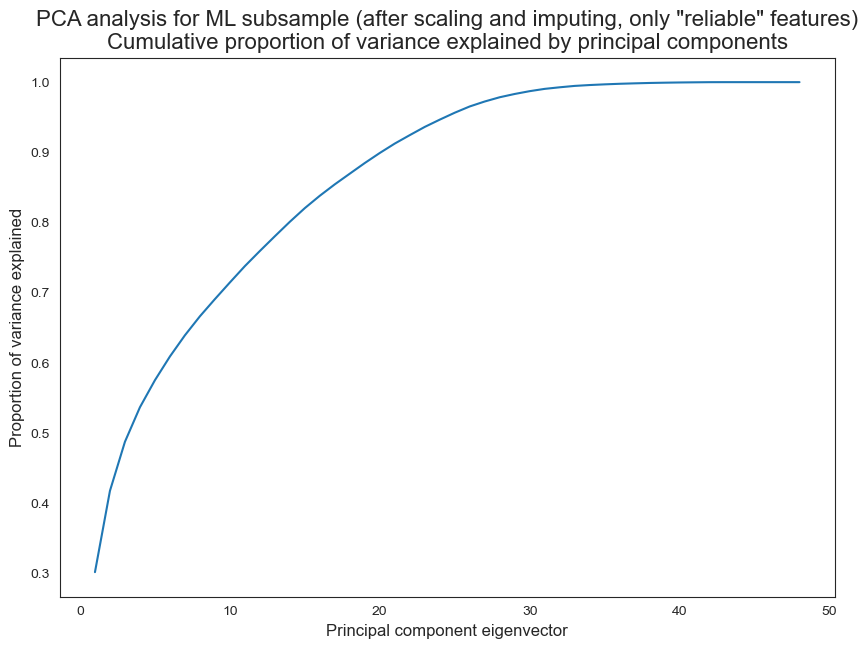

In [101]:
draw_lineplot(x=np.arange(1, len(exp_var_ml_sc_rel) + 1),
              y=exp_var_ml_sc_rel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for ML subsample (after scaling and imputing, only \"reliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_09_MLRelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

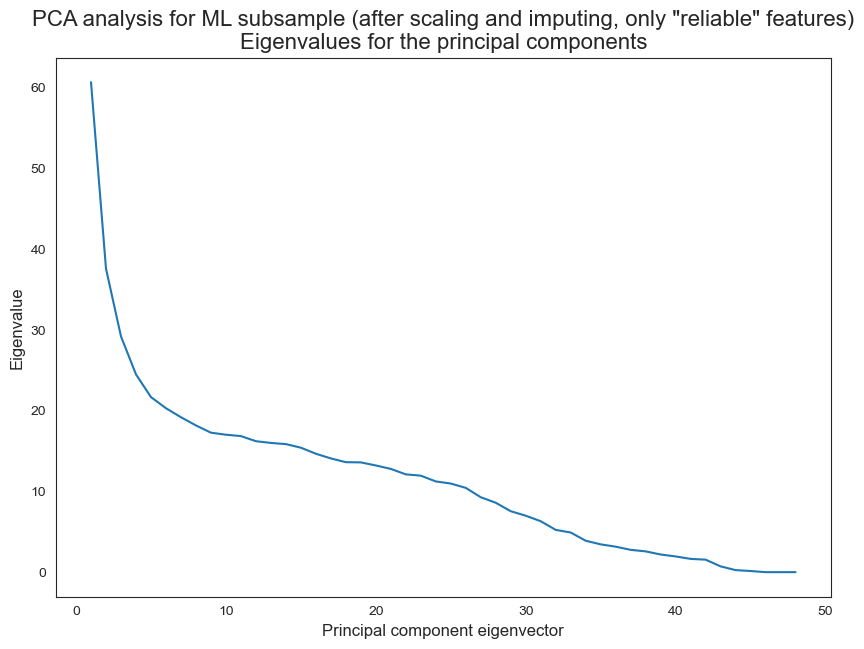

In [102]:
draw_lineplot(x=np.arange(1, len(sv_ml_sc_rel) + 1),
              y=sv_ml_sc_rel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for ML subsample (after scaling and imputing, only \"reliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_10_MLRelFeatures_PCA_Eigenvalues.jpg")

**IMPORTANT OBSERVATION:** now, with only the "reliable" features, the results of the PCA analysis for the ML subsample are much more similar to the results from those obtained for the S4 sample.

Next, let's do the same analysis with only the "unreliable" features.

### Comparing results for ML subsample and S4 sample ("reliable", scaled features)

We now compare the PCA results for both: eigenvectors and eigenvalues.

#### Eigenvectors

In [103]:
comp_diff_sc_rel = pca_s4_sc_rel.components_ - pca_ml_sc_rel.components_
comp_diff_sc_rel

array([[ 0.03762604, -0.01028597, -0.05123726, ..., -0.01403524,
         0.01659089,  0.08677587],
       [ 0.01492457, -0.00849823,  0.00123725, ..., -0.03000755,
         0.03538459,  0.03840266],
       [ 0.0311258 , -0.01330144, -0.02261471, ..., -0.04610446,
         0.04566844,  0.03444507],
       ...,
       [ 0.        ,  0.        , -0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ]])

In [104]:
pd.Series(comp_diff_sc_rel.flatten()).describe()

count    2.304000e+03
mean     1.445749e-03
std      1.798504e-01
min     -1.861839e+00
25%     -3.609925e-02
50%     -3.546484e-17
75%      3.404839e-02
max      1.872744e+00
dtype: float64

#### Eigenvalues

In [105]:
sv_diff_sc_rel = pca_s4_sc_rel.singular_values_ - pca_ml_sc_rel.singular_values_
sv_diff_sc_rel

array([35.37488286, 39.76490111, 31.44779784, 19.16583725, 19.39324349,
       17.75997212, 16.93179447, 17.14021469, 17.41800882, 16.96888524,
       16.88539061, 16.49247764, 16.58934962, 16.406136  , 16.34419991,
       16.65545159, 16.70737606, 16.58038215, 16.10327108, 15.89406113,
       15.36971742, 15.96293094, 15.41747521, 14.97478932, 14.04579149,
       12.09302884, 10.09517829,  8.4376257 ,  8.50663165,  8.34366233,
        7.00053111,  5.37897311,  4.69003495,  4.89064183,  3.65223242,
        3.10831636,  3.01501115,  2.8058023 ,  1.73035578,  1.65506799,
        1.6341598 ,  1.59960722,  0.51010265,  0.40353638,  0.18388272,
        0.        ,  0.        ,  0.        ])

In [106]:
pd.Series(sv_diff_sc_rel.flatten()).describe()

count    4.800000e+01
mean     1.169852e+01
std      9.204565e+00
min      1.835626e-15
25%      3.084990e+00
50%      1.451029e+01
75%      1.666843e+01
max      3.976490e+01
dtype: float64

## PCA calculation (only "unreliable" features)

In [107]:
np.set_printoptions(suppress=True)

### PCA analysis for S4 sample ("unreliable", scaled features)

#### PCA definition and application

In [108]:
pca_s4_sc_unrel = PCA(svd_solver='full')
pca_s4_sc_unrel

PCA(svd_solver='full')

In [109]:
pca_s4_sc_unrel.fit(s4_sc[unrel_features])

PCA(svd_solver='full')

In [110]:
exp_var_s4_sc_unrel = pca_s4_sc_unrel.explained_variance_ratio_
exp_var_s4_sc_unrel

array([0.17241716, 0.10150801, 0.06377557, 0.05028245, 0.04771011,
       0.03752006, 0.03256099, 0.02898929, 0.02697813, 0.02622813,
       0.02358756, 0.02256745, 0.01951872, 0.01861688, 0.01729135,
       0.01629684, 0.01563865, 0.01520981, 0.01504056, 0.01456111,
       0.0137273 , 0.012881  , 0.01258577, 0.01190364, 0.01145896,
       0.01121098, 0.01071732, 0.00989962, 0.00983903, 0.00940563,
       0.00926205, 0.00898561, 0.00842216, 0.00837949, 0.00810784,
       0.00800918, 0.00776719, 0.00746034, 0.00714897, 0.00567221,
       0.00513922, 0.00438023, 0.0041801 , 0.00359005, 0.00331528,
       0.00281525, 0.00257139, 0.00250671, 0.00207412, 0.00170167,
       0.0015027 , 0.00131954, 0.00109044, 0.00103799, 0.00084191,
       0.00073681, 0.00059902, 0.00050471, 0.00044258, 0.00042524,
       0.00005906, 0.00002283, 0.        , 0.        ])

**OBSERVATION:** WE have to reach the $17^{th}$ component to observe drop of the contribution to the $10\%$ of the contribution of the first component, i.e. the result for S4 is very similar to the case where we used all the features. This is somehow expected, as the scaling was carried out using the S4 sample.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [111]:
sv_s4_sc_unrel = pca_s4_sc_unrel.singular_values_
sv_s4_sc_unrel

array([105.02373678,  80.583734  ,  63.87404137,  56.71598221,
        55.24620481,  48.99243216,  45.64004053,  43.06416496,
        41.54350661,  40.96197634,  38.84532154,  37.99605336,
        35.33644605,  34.51045333,  33.25918601,  32.28857514,
        31.62983348,  31.19314629,  31.01910559,  30.52070181,
        29.63396501,  28.7059572 ,  28.37508431,  27.59542118,
        27.07508959,  26.78052551,  26.18426638,  25.16554912,
        25.0884293 ,  24.52964556,  24.34169521,  23.9756826 ,
        23.21180649,  23.1529285 ,  22.77455304,  22.635558  ,
        22.29097931,  21.84623385,  21.38547574,  19.04905692,
        18.13201256,  16.73962202,  16.35273213,  15.1547101 ,
        14.56322155,  13.42009348,  12.8256921 ,  12.66337856,
        11.51898701,  10.43363072,   9.80467335,   9.18775146,
         8.35215018,   8.14881265,   7.33890388,   6.86552282,
         6.19037716,   5.6822068 ,   5.32097251,   5.21571845,
         1.94368418,   1.20862749,   0.        ,   0.  

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

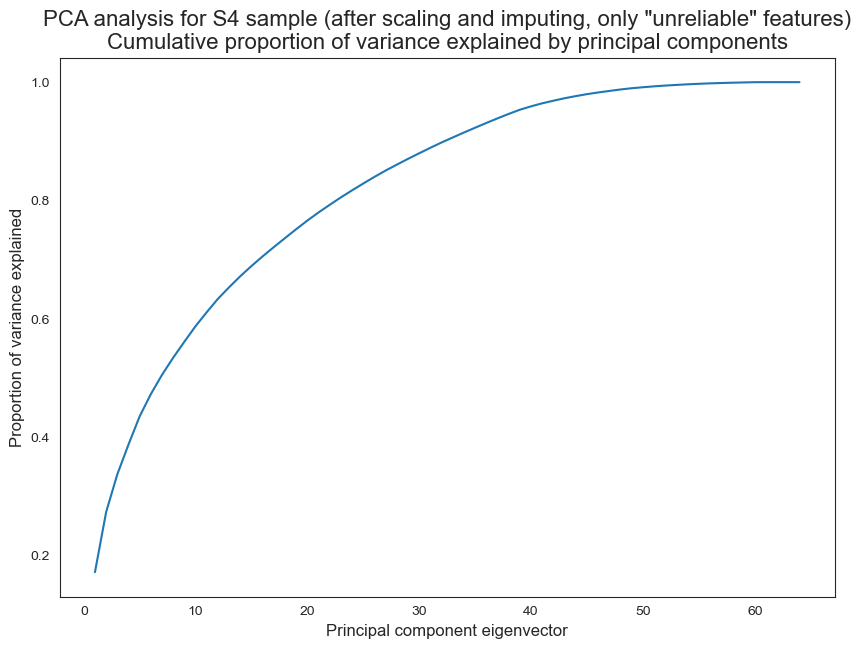

In [112]:
draw_lineplot(x=np.arange(1, len(exp_var_s4_sc_unrel) + 1),
              y=exp_var_s4_sc_unrel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for S4 sample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_11_S4UnrelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

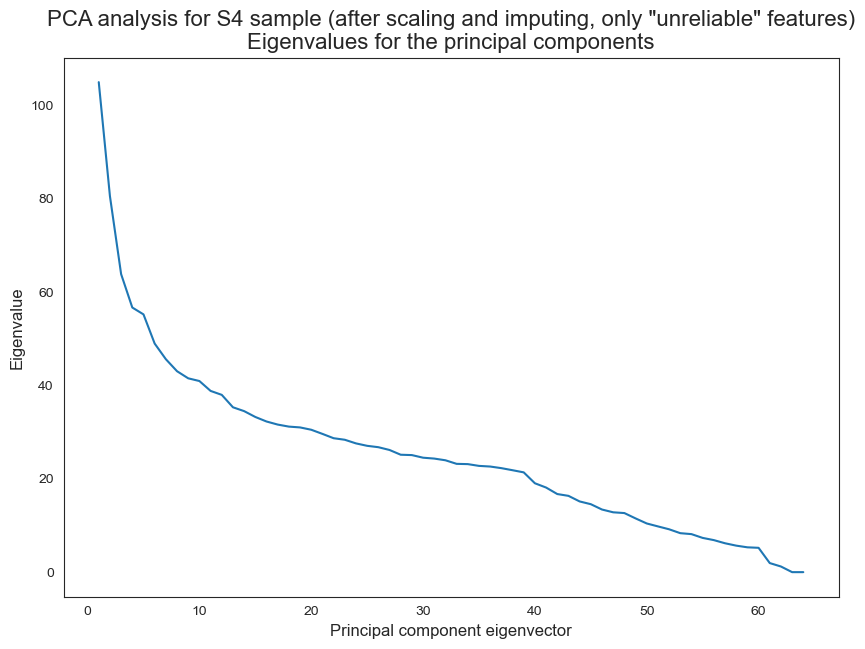

In [113]:
draw_lineplot(x=np.arange(1, len(sv_s4_sc_unrel) + 1),
              y=sv_s4_sc_unrel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for S4 sample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_12_S4UnrelFeatures_PCA_Eigenvalues.jpg")

**OBSERVATION:** again, very similar results to the case of using all features in S4 sample.

### PCA analysis for pulsating stars in S4 sample ("unreliable", scaled features)

#### PCA definition and application

In [114]:
pca_s4p_sc_unrel = PCA(svd_solver='full')
pca_s4p_sc_unrel

PCA(svd_solver='full')

In [115]:
pca_s4p_sc_unrel.fit(s4p_sc[unrel_features])

PCA(svd_solver='full')

In [116]:
exp_var_s4p_sc_unrel = pca_s4p_sc_unrel.explained_variance_ratio_
exp_var_s4p_sc_unrel

array([0.20802291, 0.10701747, 0.07221505, 0.06202263, 0.04992164,
       0.04535244, 0.04007443, 0.03715419, 0.0319914 , 0.02879876,
       0.02734546, 0.02361991, 0.02175663, 0.02114789, 0.02014738,
       0.01781329, 0.01725327, 0.01579904, 0.01490553, 0.01390775,
       0.01372243, 0.01191104, 0.01045784, 0.00927016, 0.00904548,
       0.0080273 , 0.00724495, 0.00637222, 0.00612797, 0.00576616,
       0.004816  , 0.00438884, 0.00385759, 0.00293207, 0.00286156,
       0.00241798, 0.00220763, 0.00188351, 0.00174153, 0.00149274,
       0.00118226, 0.0010267 , 0.00096755, 0.00066318, 0.00055694,
       0.00050569, 0.00046663, 0.00042667, 0.00029874, 0.0002894 ,
       0.00024184, 0.00020963, 0.00016406, 0.00009115, 0.00004701,
       0.00003238, 0.00001018, 0.00000674, 0.00000119, 0.        ,
       0.        , 0.        , 0.        , 0.        ])

**OBSERVATION:** WE have to reach the $20^{th}$ component to observe drop of the contribution to the $10\%$ of the contribution of the first component, i.e. the result for S4 is very similar to the case where we used all the features. This is somehow expected, as the scaling was carried out using the S4 sample.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [117]:
sv_s4p_sc_unrel = pca_s4p_sc_unrel.singular_values_
sv_s4p_sc_unrel

array([32.27531961, 23.14953666, 19.01642327, 17.62341403, 15.81100232,
       15.07007104, 14.1660456 , 13.64014207, 12.65702355, 12.00886223,
       11.70193146, 10.87562109, 10.43784459, 10.29078417, 10.04440481,
        9.44467435,  9.29502844,  8.89468121,  8.63950113,  8.34532789,
        8.28954004,  7.72306768,  7.23662329,  6.81331731,  6.73024431,
        6.34015356,  6.02327435,  5.64885577,  5.53953309,  5.37351215,
        4.9108683 ,  4.68802308,  4.39514543,  3.83179444,  3.78543852,
        3.47969508,  3.32489266,  3.07113771,  2.95311323,  2.73405358,
        2.4331596 ,  2.26744459,  2.20116152,  1.82233915,  1.67001302,
        1.59132377,  1.52862639,  1.46171477,  1.22309236,  1.20383768,
        1.10047019,  1.02456711,  0.90638716,  0.67559727,  0.48521133,
        0.40268361,  0.2257853 ,  0.18373268,  0.07710623,  0.00000002,
        0.        ,  0.        ,  0.        ,  0.        ])

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

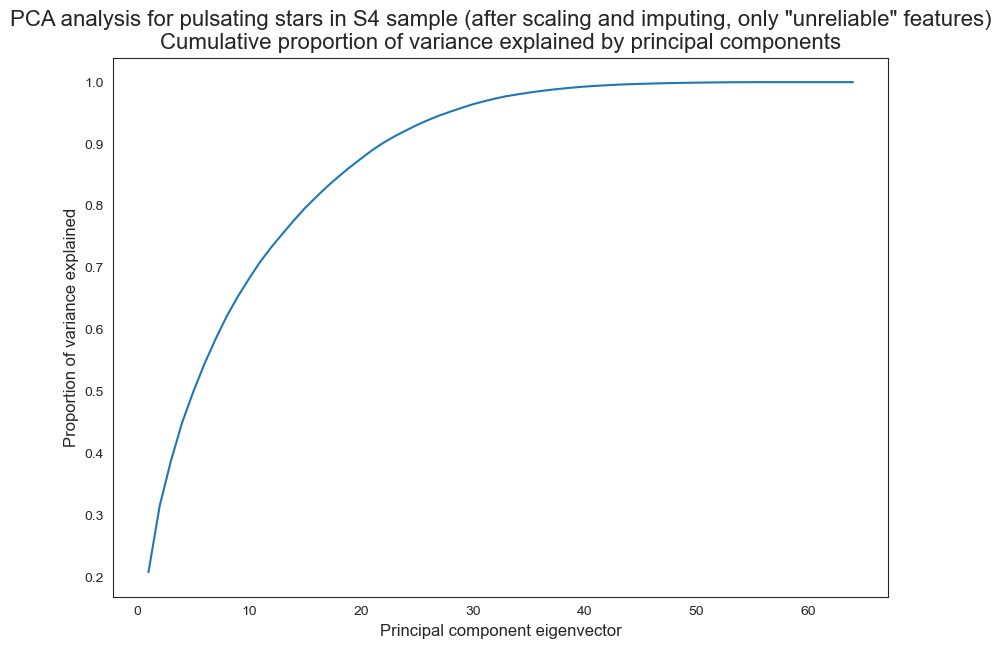

In [118]:
draw_lineplot(x=np.arange(1, len(exp_var_s4p_sc_unrel) + 1),
              y=exp_var_s4p_sc_unrel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for pulsating stars in S4 sample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_11P_S4PUnrelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

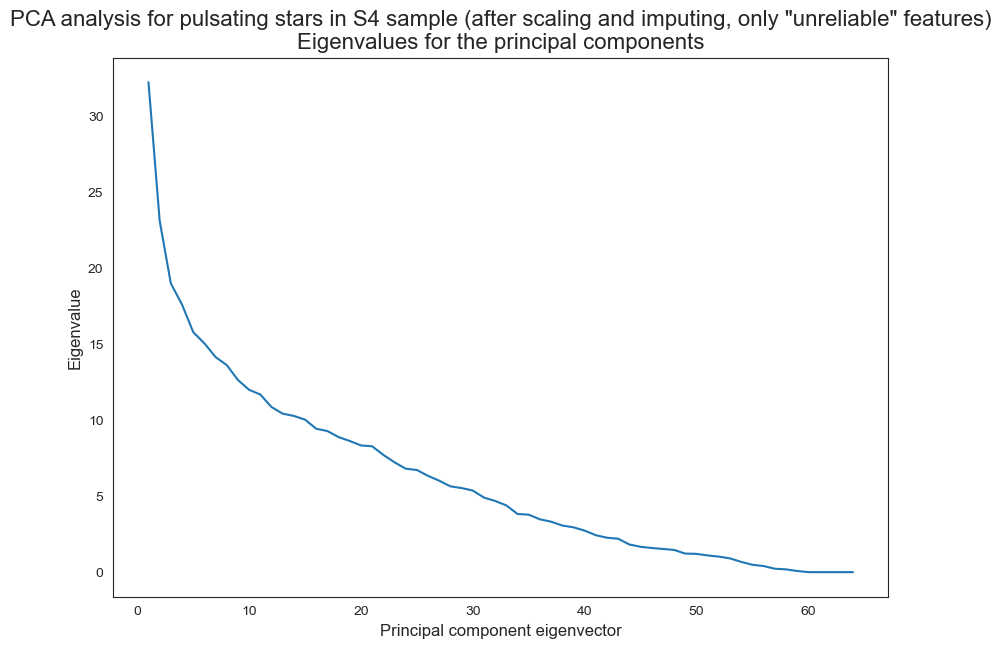

In [119]:
draw_lineplot(x=np.arange(1, len(sv_s4p_sc_unrel) + 1),
              y=sv_s4p_sc_unrel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for pulsating stars in S4 sample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_12P_S4PUnrelFeatures_PCA_Eigenvalues.jpg")

**OBSERVATION:** again, very similar results to the case of using all features in S4 sample.

### PCA analysis for non-pulsating stars in S4 sample ("unreliable", scaled features)

#### PCA definition and application

In [120]:
pca_s4np_sc_unrel = PCA(svd_solver='full')
pca_s4np_sc_unrel

PCA(svd_solver='full')

In [121]:
pca_s4np_sc_unrel.fit(s4np_sc[unrel_features])

PCA(svd_solver='full')

In [122]:
exp_var_s4np_sc_unrel = pca_s4np_sc_unrel.explained_variance_ratio_
exp_var_s4np_sc_unrel

array([0.17679116, 0.10095394, 0.06347859, 0.05194926, 0.0460971 ,
       0.03773689, 0.0330195 , 0.03078249, 0.02741252, 0.02627269,
       0.02295125, 0.02259178, 0.01993704, 0.01869657, 0.01815883,
       0.01620975, 0.0155935 , 0.0152579 , 0.01475624, 0.01439168,
       0.01342859, 0.01272528, 0.01238478, 0.01152696, 0.01132316,
       0.01105944, 0.01031509, 0.00970788, 0.00934804, 0.00903347,
       0.00883589, 0.00856934, 0.00819358, 0.00805985, 0.0079305 ,
       0.00772728, 0.00734028, 0.00706198, 0.00631148, 0.00546844,
       0.00506466, 0.00453612, 0.00431084, 0.003625  , 0.00329916,
       0.00278065, 0.00250412, 0.00244765, 0.00198326, 0.00171483,
       0.00149186, 0.00130555, 0.00104038, 0.00098823, 0.00078965,
       0.00071077, 0.00058463, 0.00049442, 0.00044066, 0.00041386,
       0.00006076, 0.00002296, 0.        , 0.        ])

**OBSERVATION:** WE have to reach the $16^{th}$ component to observe drop of the contribution to the $10\%$ of the contribution of the first component, i.e. the result for S4 is very similar to the case where we used all the features. This is somehow expected, as the scaling was carried out using the S4 sample.

Let's see now the eigenvalues and then plot the scree graph and the cumulative variance explained.

In [123]:
sv_s4np_sc_unrel = pca_s4np_sc_unrel.singular_values_
sv_s4np_sc_unrel

array([101.99319298,  77.07305255,  61.11594603,  55.28796524,
        52.08080648,  47.12203078,  44.07843386,  42.55913751,
        40.16200787,  39.3181582 ,  36.74887967,  36.45995462,
        34.25084643,  33.16819768,  32.68773328,  30.88368603,
        30.29093373,  29.96320255,  29.46651512,  29.10024671,
        28.10969915,  27.36368208,  26.99510488,  26.04344272,
        25.81218597,  25.50982868,  24.63641137,  23.90028559,
        23.45314498,  23.05516777,  22.80163551,  22.45508247,
        21.95724537,  21.77732185,  21.60186706,  21.32328581,
        20.78246735,  20.38468741,  19.27109768,  17.93794584,
        17.26298533,  16.33740778,  15.92654777,  14.60477589,
        13.93292879,  12.79127409,  12.13860704,  12.00095338,
        10.8026683 ,  10.04504702,   9.3692404 ,   8.76469782,
         7.82414183,   7.62553837,   6.81646618,   6.46705546,
         5.86517574,   5.39372832,   5.09205099,   4.93474898,
         1.89075895,   1.16235638,   0.        ,   0.  

Again, the eigenvalues are of similar orders of magnitude up to a high rank order.

#### Cumulative variance explained plot

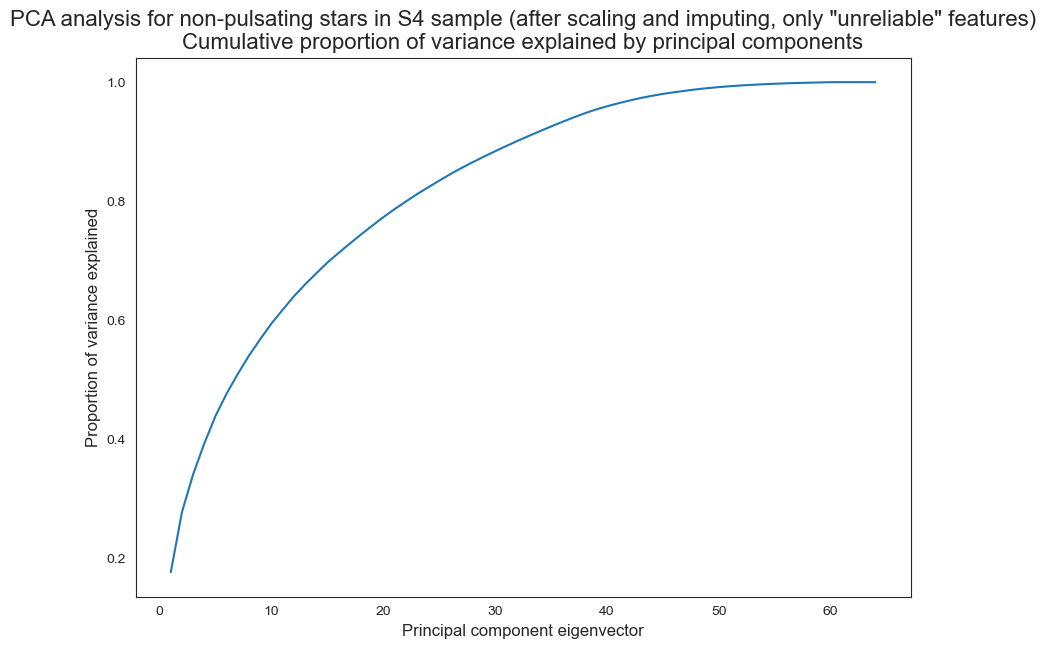

In [124]:
draw_lineplot(x=np.arange(1, len(exp_var_s4np_sc_unrel) + 1),
              y=exp_var_s4np_sc_unrel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for non-pulsating stars in S4 sample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_11NP_S4NPUnrelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

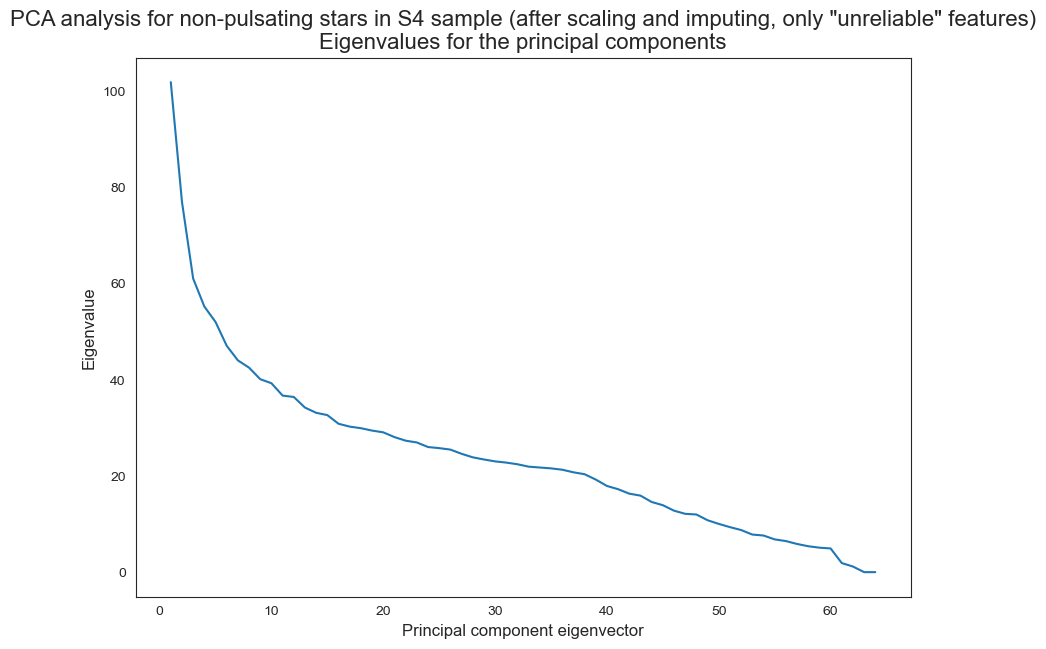

In [125]:
draw_lineplot(x=np.arange(1, len(sv_s4np_sc_unrel) + 1),
              y=sv_s4np_sc_unrel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for non-pulsating stars in S4 sample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_12NP_S4NPUnrelFeatures_PCA_Eigenvalues.jpg")

**OBSERVATION:** again, very similar results to the case of using all features in S4 sample.

### PCA analysis for ML subsample ("unreliable", scaled features)

#### PCA definition and application

In [126]:
pca_ml_sc_unrel = PCA(svd_solver='full')
pca_ml_sc_unrel

PCA(svd_solver='full')

In [127]:
pca_ml_sc_unrel.fit(ml_sc[unrel_features])

PCA(svd_solver='full')

In [128]:
exp_var_ml_sc_unrel = pca_ml_sc_unrel.explained_variance_ratio_
exp_var_ml_sc_unrel

array([0.69758727, 0.30241273, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

**IMPORTANT OBSERVATION:** Here it is: here is where the problem of excessive variance appears.

In [129]:
sv_ml_sc_unrel = pca_ml_sc_unrel.singular_values_
sv_ml_sc_unrel

array([7.24488888e+08, 4.77015501e+08, 1.37494389e+02, 1.24511070e+02,
       1.07670883e+02, 7.43792018e+01, 7.15463729e+01, 6.75775273e+01,
       4.58651387e+01, 4.09708328e+01, 3.73012810e+01, 3.59618601e+01,
       3.52048592e+01, 3.33241423e+01, 2.92608437e+01, 2.81060273e+01,
       2.60796607e+01, 2.57109121e+01, 2.44853610e+01, 2.35544395e+01,
       2.24722540e+01, 2.15331884e+01, 2.00385696e+01, 1.97884650e+01,
       1.77927905e+01, 1.71962825e+01, 1.65110415e+01, 1.57645239e+01,
       1.45527588e+01, 1.42183500e+01, 1.29976886e+01, 1.21219664e+01,
       1.20578009e+01, 1.17679153e+01, 1.06961833e+01, 1.03725571e+01,
       9.88550740e+00, 9.07526252e+00, 8.78133495e+00, 8.39505244e+00,
       7.97220536e+00, 6.98284185e+00, 6.15933847e+00, 5.98284224e+00,
       5.68484795e+00, 5.47559904e+00, 5.30950880e+00, 4.55906160e+00,
       4.33133745e+00, 3.99649519e+00, 3.76696410e+00, 3.55637042e+00,
       3.02179801e+00, 2.71304134e+00, 2.13254367e+00, 1.78918838e+00,
      

**OBSERVATION:** the eigenvalues confirm the conclusion: the first two eigenvalue are much higher than the rest.

#### Cumulative variance explained plot

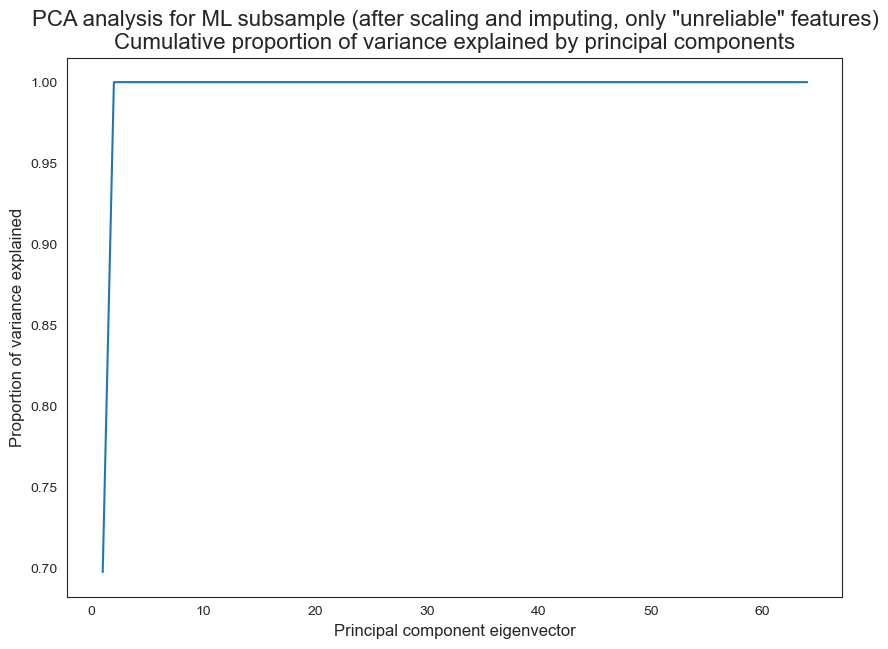

In [130]:
draw_lineplot(x=np.arange(1, len(exp_var_ml_sc_unrel) + 1),
              y=exp_var_ml_sc_unrel.cumsum(),
              xlabel="Principal component eigenvector",
              ylabel="Proportion of variance explained",
              fig_title="PCA analysis for ML subsample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Cumulative proportion of variance explained by principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_13_MLUnrelFeatures_PCA_CumVarianceExplained.jpg")

#### Scree plot (eigenvalues)

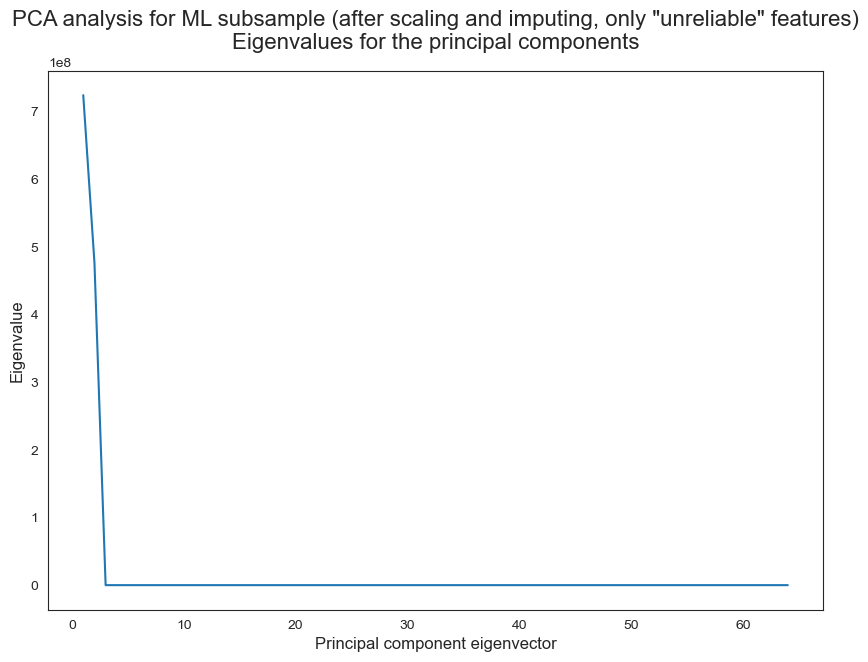

In [131]:
draw_lineplot(x=np.arange(1, len(sv_ml_sc_unrel) + 1),
              y=sv_ml_sc_unrel,
              xlabel="Principal component eigenvector",
              ylabel="Eigenvalue",
              fig_title="PCA analysis for ML subsample (after scaling and imputing, only \"unreliable\" features)\n" \
                "Eigenvalues for the principal components",
              fig_filename=IMAGE_FOLDER + "ML_20_14_MLUnrelFeatures_PCA_Eigenvalues.jpg")

**IMPORTANT OBSERVATION:** now, with only the "unreliable" features, the same discrepancy of results appears.

### Comparing results for ML subsample and S4 sample ("unreliable", scaled features)

We now compare the PCA results for both: eigenvectors and eigenvalues.

#### Eigenvectors

In [132]:
comp_diff_sc_unrel = pca_s4_sc_unrel.components_ - pca_ml_sc_unrel.components_
comp_diff_sc_unrel

array([[ 0.22862164,  0.01476937, -0.09409833, ...,  0.00601706,
        -0.02411107,  0.11114057],
       [ 0.1681072 , -0.04941028, -0.1734152 , ...,  0.13445745,
         0.0591435 , -0.02492147],
       [ 0.09966438,  0.01605911, -0.11302043, ..., -0.18037596,
         0.03112648, -0.35913556],
       ...,
       [ 0.2299425 ,  0.00127271, -0.01318481, ..., -0.00823589,
        -0.00084356,  0.01018527],
       [ 0.        , -0.        , -0.        , ...,  0.        ,
         0.        , -0.        ],
       [-0.        ,  0.        , -0.        , ..., -0.        ,
         0.        ,  0.        ]])

In [133]:
pd.Series(comp_diff_sc_unrel.flatten()).describe()

count    4.096000e+03
mean     3.159269e-03
std      1.755064e-01
min     -1.707102e+00
25%     -6.767516e-02
50%      9.639415e-16
75%      7.298425e-02
max      9.719836e-01
dtype: float64

#### Eigenvalues

In [134]:
sv_diff_sc_unrel = pca_s4_sc_unrel.singular_values_ - pca_ml_sc_unrel.singular_values_
sv_diff_sc_unrel

array([-7.24488783e+08, -4.77015420e+08, -7.36203472e+01, -6.77950878e+01,
       -5.24246781e+01, -2.53867696e+01, -2.59063324e+01, -2.45133623e+01,
       -4.32163205e+00, -8.85648162e-03,  1.54404055e+00,  2.03419324e+00,
        1.31586814e-01,  1.18631106e+00,  3.99834234e+00,  4.18254781e+00,
        5.55017274e+00,  5.48223417e+00,  6.53374461e+00,  6.96626231e+00,
        7.16171098e+00,  7.17276878e+00,  8.33651467e+00,  7.80695617e+00,
        9.28229907e+00,  9.58424299e+00,  9.67322483e+00,  9.40102518e+00,
        1.05356705e+01,  1.03112956e+01,  1.13440066e+01,  1.18537162e+01,
        1.11540056e+01,  1.13850132e+01,  1.20783698e+01,  1.22630009e+01,
        1.24054719e+01,  1.27709713e+01,  1.26041408e+01,  1.06540045e+01,
        1.01598072e+01,  9.75678017e+00,  1.01933937e+01,  9.17186786e+00,
        8.87837361e+00,  7.94449444e+00,  7.51618330e+00,  8.10431696e+00,
        7.18764957e+00,  6.43713553e+00,  6.03770925e+00,  5.63138104e+00,
        5.33035217e+00,  

In [135]:
pd.Series(sv_diff_sc_unrel.flatten()).describe()

count    6.400000e+01
mean    -1.877350e+07
std      1.076348e+08
min     -7.244888e+08
25%      1.843773e+00
50%      6.237422e+00
75%      9.606488e+00
max      1.277097e+01
dtype: float64

### Discrepancy analysis

#### Search for "offending" PCA components and features

Let's first see what are the original features that PCA says are the driving force for the variace of the data: the first two eigenvectors.

In [136]:
pca_ml_sc_unrel.components_

array([[-0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [-0.        ,  0.        , -0.        , ...,  0.        ,
        -0.        ,  0.        ],
       [-0.00786307,  0.00103318, -0.00225731, ..., -0.00919601,
        -0.02793925,  0.01187735],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
         0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
        -0.        , -0.        ]])

In [137]:
pca_ml_sc_unrel.components_[0:2]

array([[-0.        ,  0.        , -0.        , -0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        , -0.        ,
         0.        , -0.        , -0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.        ,  0.        ,
         0.00000003,  0.00000003,  0.00000004, -0.        , -0.        ,
         0.00000001,  0.        ,  0.        ,  0.        ,  0.00000001,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.00000001,
        -0.        , -0.        , -0.        , -0.        ,  0.00000001,
         0.21279367,  0.97709716,  0.        , -0.00000001, -0.        ,
         0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -0.        , -0.        , -0.        ,  0.        ],
       [-0.        ,  0.        , -0.        , -0.        , -0.

**OBSERVATION:** it seems clear that there are two very important components. Let's see what features build those components.

First eigenvector:

In [138]:
feat_idx_1_unrel = list(np.where(np.logical_not(np.isclose(np.abs(pca_ml_sc_unrel.components_[0]), 0)))[0].flatten())
feat_idx_1_unrel

[30, 31, 32, 39, 49, 50, 51]

In [139]:
original_features_1_unrel = [unrel_features[i] for i in feat_idx_1_unrel]
sorted(original_features_1_unrel)

['freq1_amplitude2',
 'freq1_amplitude3',
 'freq1_amplitude4',
 'freq2_amplitude4',
 'freq_frequency_ratio_31',
 'freq_model_max_delta_mags',
 'freq_model_min_delta_mags']

Second eigenvector:

In [140]:
feat_idx_2_unrel = list(np.where(np.logical_not(np.isclose(np.abs(pca_ml_sc_unrel.components_[1]), 0)))[0].flatten())
feat_idx_2_unrel

[30, 32, 50, 51]

In [141]:
original_features_2_unrel = [unrel_features[i] for i in feat_idx_2_unrel]
sorted(original_features_2_unrel)

['freq1_amplitude2',
 'freq1_amplitude4',
 'freq_model_max_delta_mags',
 'freq_model_min_delta_mags']

Let's recall what we had with the full feature set:

In [142]:
sorted(original_features_1)

['freq1_amplitude2',
 'freq1_amplitude3',
 'freq1_amplitude4',
 'freq2_amplitude4',
 'freq_frequency_ratio_31',
 'freq_model_max_delta_mags',
 'freq_model_min_delta_mags',
 'freq_model_phi1_phi2']

In [143]:
sorted(original_features_2)

['freq1_amplitude2',
 'freq1_amplitude4',
 'freq_model_max_delta_mags',
 'freq_model_min_delta_mags',
 'freq_model_phi1_phi2']

In [144]:
"freq_model_phi1_phi2" in unrel_features

False

**IMPORTANT OBSERVATION:** ok, save for the feature `freq_model_phi1_phi2` (which, by the way, is suposed to be a "reliable" feature), the "offending" features are exactly the same in both cases.

Hence, it seems pretty clear that the discrepancies in the PCA analysis are caused by the "offending" features and, more specifically, by the features `freq1_amplitude2`, `freq1_amplitude3`, `freq1_amplitude4`, `freq2_amplitude4`, `freq_frequency_ratio_31`, `freq_model_max_delta_mags` and `freq_model_min_delta_mags`. The "reliable" feature `freq_model_phi1_phi2` remains suspicious, as it appeared in the case of taking all the features.

## PCA ML vs S4 comparison: summary of eigenvectors / eigenvalues results

We just recall here the differences between the PCA results in ML subsample and S4 sample for the cases where we take all the features ($112$), only "unreliable" features ($64$), and only "reliable" features ($48$).

### Summary for eigenvalues similarity

Let's recall the similarity (array difference) for the eigenvalues:

In [145]:
print("All features - Differences in eigenvalues:")
pd.Series(sv_diff_sc.flatten()).describe()

All features - Differences in eigenvalues:


count    1.120000e+02
mean    -1.072771e+07
std      8.162418e+07
min     -7.244888e+08
25%      3.705848e+00
50%      8.485062e+00
75%      1.265961e+01
max      1.426288e+01
dtype: float64

In [146]:
print("Only 'unreliable' features - Differences in eigenvalues:")
pd.Series(sv_diff_sc_unrel.flatten()).describe()

Only 'unreliable' features - Differences in eigenvalues:


count    6.400000e+01
mean    -1.877350e+07
std      1.076348e+08
min     -7.244888e+08
25%      1.843773e+00
50%      6.237422e+00
75%      9.606488e+00
max      1.277097e+01
dtype: float64

In [147]:
print("Only 'reliable' features - Differences in eigenvalues:")
pd.Series(sv_diff_sc_rel.flatten()).describe()

Only 'reliable' features - Differences in eigenvalues:


count    4.800000e+01
mean     1.169852e+01
std      9.204565e+00
min      1.835626e-15
25%      3.084990e+00
50%      1.451029e+01
75%      1.666843e+01
max      3.976490e+01
dtype: float64

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

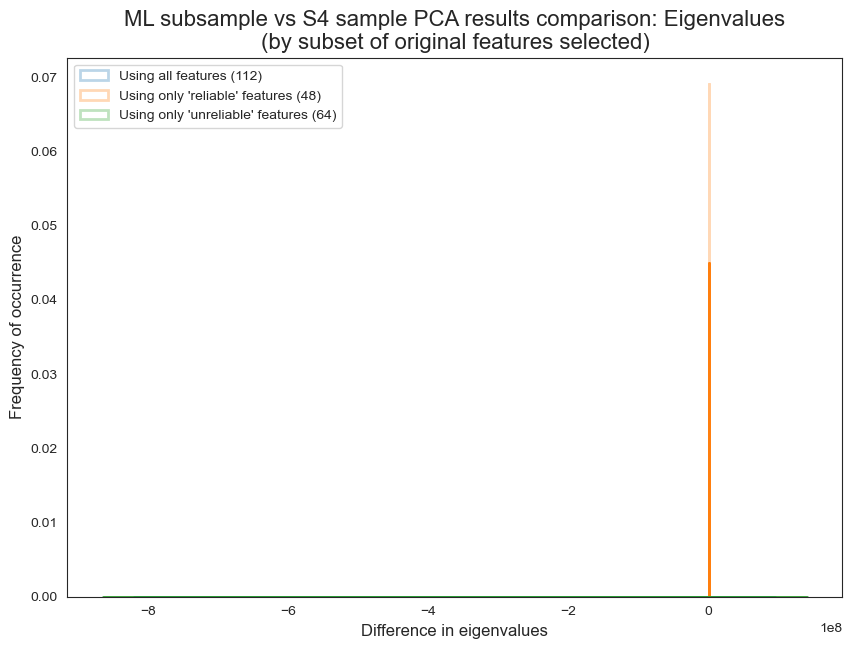

In [148]:
d_list = [sv_diff_sc.flatten(), sv_diff_sc_rel.flatten(),
          sv_diff_sc_unrel.flatten()]
d_labels = ["Using all features (%d)" %len(cs_f_list),"Using only 'reliable' features (%d)" %len(rel_features),
            "Using only 'unreliable' features (%d)" %len(unrel_features)]
varname = "Difference in eigenvalues"
fig_title = "ML subsample vs S4 sample PCA results comparison: Eigenvalues\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20_15_Dist_PCA_ResultComp_Eigenvalues.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

### Summary for eigenvectors similarity

#### Differences in coefficients

Let's recall the similarity (array difference) for the eigenvectors coefficients:

In [149]:
print("All features - Differences in eigenvector coefficients:")
pd.Series(comp_diff_sc.flatten()).describe()

All features - Differences in eigenvector coefficients:


count    12544.000000
mean         0.001650
std          0.133515
min         -0.973030
25%         -0.050229
50%          0.000000
75%          0.051965
max          1.035734
dtype: float64

In [150]:
print("Only 'unreliable' features - Differences in eigenvector coefficients:")
pd.Series(comp_diff_sc_unrel.flatten()).describe()

Only 'unreliable' features - Differences in eigenvector coefficients:


count    4.096000e+03
mean     3.159269e-03
std      1.755064e-01
min     -1.707102e+00
25%     -6.767516e-02
50%      9.639415e-16
75%      7.298425e-02
max      9.719836e-01
dtype: float64

In [151]:
print("Only 'reliable' features - Differences in eigenvector coefficients:")
pd.Series(comp_diff_sc_rel.flatten()).describe()

Only 'reliable' features - Differences in eigenvector coefficients:


count    2.304000e+03
mean     1.445749e-03
std      1.798504e-01
min     -1.861839e+00
25%     -3.609925e-02
50%     -3.546484e-17
75%      3.404839e-02
max      1.872744e+00
dtype: float64

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

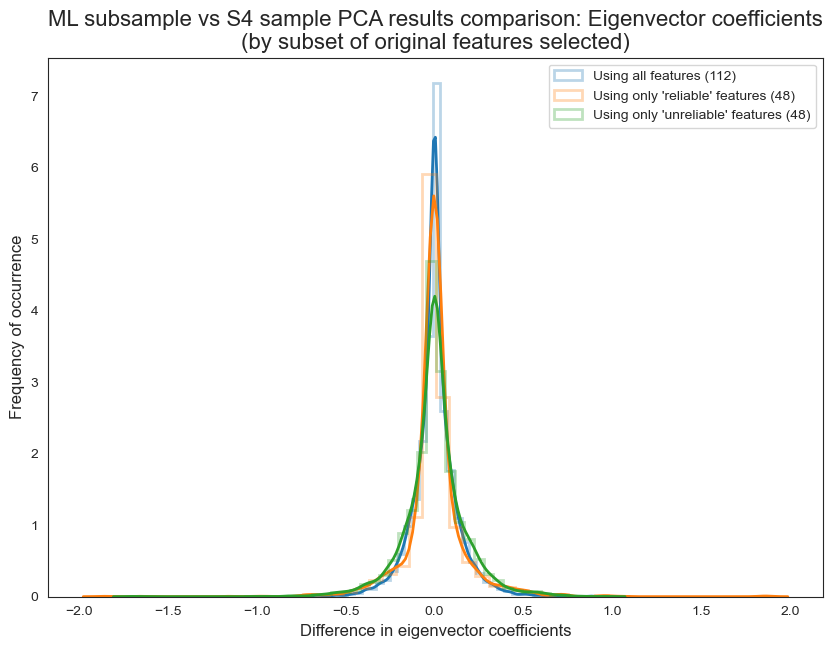

In [152]:
d_list = [comp_diff_sc.flatten(), comp_diff_sc_rel.flatten(),
          comp_diff_sc_unrel.flatten()]
d_labels = ["Using all features (112)", "Using only 'reliable' features (48)",
            "Using only 'unreliable' features (48)"]
varname = "Difference in eigenvector coefficients"
fig_title = "ML subsample vs S4 sample PCA results comparison: Eigenvector coefficients\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20_16_Dist_PCA_ResultComp_EigenvectorCoef.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

#### Dot products, component-wise

##### Calculations

In [153]:
dot_sc = np.dot(pca_ml_sc.components_, pca_s4_sc.components_.T)
dot_sc

array([[ 0.00405124,  0.07640397, -0.02411624, ..., -0.        ,
        -0.        , -0.        ],
       [-0.00050952,  0.03570579, -0.01366121, ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.10071611, -0.03744768, -0.03347296, ...,  0.        ,
         0.        , -0.        ],
       ...,
       [-0.01081092, -0.054515  , -0.07557948, ...,  0.07804677,
        -0.0043603 , -0.02146108],
       [ 0.01391417,  0.07016343,  0.09727443, ...,  0.44337217,
         0.21097227,  0.57646715],
       [ 0.02135609,  0.10769   ,  0.14930119, ...,  0.08057982,
        -0.37050601, -0.04604605]])

In [154]:
dot_sc_cw = np.diag(dot_sc)
dot_sc_cw

array([ 0.00405124,  0.03570579, -0.03347296, -0.23285826,  0.1055455 ,
       -0.06654974,  0.25660559,  0.19567823,  0.10140097,  0.02467751,
        0.04559951, -0.08695997, -0.02089592,  0.06439344, -0.13627104,
       -0.16421969, -0.06312096,  0.05625661, -0.18231924, -0.22693465,
       -0.03941784, -0.10746352,  0.10275741, -0.17186694,  0.04312193,
        0.01187598,  0.1009871 , -0.07271958,  0.07672865, -0.00281693,
       -0.08287852,  0.20088909,  0.15723485,  0.19529106, -0.24053315,
       -0.04736905, -0.15531421, -0.04543009, -0.11821661,  0.24029642,
       -0.10671961,  0.0478885 ,  0.08493554,  0.10188816, -0.06423515,
        0.08727273,  0.09968282, -0.12074823,  0.13681188,  0.2492139 ,
       -0.18260078,  0.11645623,  0.13700796,  0.1814485 , -0.26020736,
        0.18027608, -0.11277951,  0.05544108, -0.12589992,  0.15101522,
       -0.26172513,  0.18149023, -0.05030981, -0.00531301,  0.16462527,
        0.19297891, -0.08169883, -0.12393129, -0.14584523, -0.06

In [155]:
dot_sc_unrel = np.dot(pca_ml_sc_unrel.components_, pca_s4_sc_unrel.components_.T)
dot_sc_unrel

array([[ 0.04940276, -0.05163896,  0.17229438, ...,  0.0000226 ,
        -0.        ,  0.        ],
       [ 0.02148031, -0.03036892,  0.08856205, ...,  0.00367121,
         0.        , -0.        ],
       [ 0.02844859, -0.0649689 , -0.00085821, ...,  0.0009348 ,
         0.        ,  0.        ],
       ...,
       [-0.09940943, -0.20488365, -0.11518079, ...,  0.02058576,
        -0.70141549,  0.03516799],
       [ 0.1003926 ,  0.20706923,  0.11703207, ..., -0.02012975,
        -0.70708915,  0.00264791],
       [-0.00744612,  0.05192714, -0.02648737, ...,  0.0004438 ,
         0.03207953,  0.90023058]])

In [156]:
dot_sc_cw_unrel = np.diag(dot_sc_unrel)
dot_sc_cw_unrel

array([ 0.04940276, -0.03036892, -0.00085821,  0.00176611,  0.13590599,
       -0.03492094, -0.20150935, -0.11597331,  0.04969473,  0.01075939,
        0.24643795, -0.04740488,  0.04723118, -0.32120423, -0.16726205,
       -0.10481729, -0.28531511, -0.01637858, -0.06396739, -0.00733506,
        0.12185617,  0.01259445, -0.05165968,  0.10440311,  0.11348789,
       -0.18116628,  0.13180591,  0.22307568,  0.12434703,  0.11859324,
       -0.10013813,  0.02326865, -0.18445153, -0.14280155,  0.03703331,
       -0.08624402, -0.08899484, -0.12901561,  0.17042464,  0.0243487 ,
       -0.06186739,  0.32063974,  0.12610606,  0.26161095, -0.19218833,
        0.20894353,  0.28787712,  0.09084536,  0.0265798 ,  0.23058843,
        0.03360286, -0.15534767, -0.24416665,  0.39000489, -0.255354  ,
        0.14299612,  0.12867681, -0.1069042 ,  0.06568588,  0.0057954 ,
        0.00892754,  0.02058576, -0.70708915,  0.90023058])

In [157]:
dot_sc_rel = np.dot(pca_ml_sc_rel.components_, pca_s4_sc_rel.components_.T)
dot_sc_rel

array([[ 0.93404609,  0.32230151, -0.01014749, ..., -0.        ,
         0.        ,  0.        ],
       [-0.33621046,  0.92655889, -0.01430178, ..., -0.        ,
         0.        ,  0.        ],
       [-0.00242039, -0.01638817,  0.97467448, ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [-0.        ,  0.        ,  0.        , ..., -0.89910497,
         0.43706369,  0.02419876],
       [-0.        , -0.        ,  0.        , ..., -0.36542728,
        -0.77987506,  0.50819071],
       [-0.        , -0.        ,  0.        , ..., -0.24098371,
        -0.4480739 , -0.86090454]])

In [158]:
dot_sc_cw_rel = np.diag(dot_sc_rel)
dot_sc_cw_rel

array([ 0.93404609,  0.92655889,  0.97467448,  0.22440423,  0.3845693 ,
        0.08115242, -0.53139519, -0.09367508, -0.2424877 ,  0.20569781,
        0.37283438, -0.35762015,  0.15619187,  0.01359901, -0.41162531,
       -0.03503642, -0.01943231,  0.13011466,  0.05829137, -0.24522715,
        0.66429876,  0.38196877,  0.27491532,  0.68776058,  0.58387631,
        0.80295274, -0.9074156 ,  0.91999723,  0.94767093, -0.96147954,
       -0.963869  ,  0.22883736, -0.24131369,  0.98461755,  0.98345868,
        0.96164163,  0.93176675,  0.9456977 , -0.93226657,  0.92770159,
        0.29259866,  0.25396513,  0.99931058,  0.99914151,  0.99941221,
       -0.89910497, -0.77987506, -0.86090454])

##### All dot products

In [159]:
print("All features - Dot products, all vectors")
pd.Series(dot_sc.flatten()).describe()

All features - Dot products, all vectors


count    1.254400e+04
mean     1.874081e-03
std      9.447630e-02
min     -8.502704e-01
25%     -3.466874e-02
50%     -9.591822e-17
75%      3.494669e-02
max      9.978680e-01
dtype: float64

In [160]:
print("Only 'unreliable' features - Dot products, all vectors")
pd.Series(dot_sc_unrel.flatten()).describe()

Only 'unreliable' features - Dot products, all vectors


count    4.096000e+03
mean     2.436372e-03
std      1.249915e-01
min     -8.527552e-01
25%     -4.752397e-02
50%      5.394517e-11
75%      5.280175e-02
max      9.002306e-01
dtype: float64

In [161]:
print("Only 'reliable' features - Dot products, all vectors")
pd.Series(dot_sc_rel.flatten()).describe()

Only 'reliable' features - Dot products, all vectors


count    2.304000e+03
mean     7.494065e-03
std      1.441742e-01
min     -9.638690e-01
25%     -1.013582e-02
50%      3.124143e-17
75%      1.262605e-02
max      9.994122e-01
dtype: float64

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

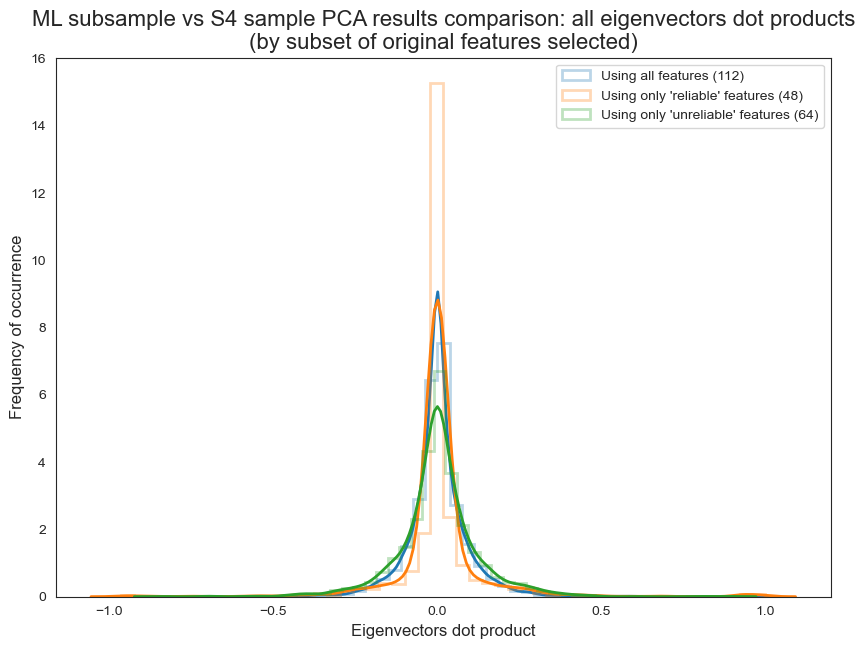

In [162]:
d_list = [dot_sc.flatten(), dot_sc_rel.flatten(),
          dot_sc_unrel.flatten()]
d_labels = ["Using all features (112)", "Using only 'reliable' features (48)",
            "Using only 'unreliable' features (64)"]
varname = "Eigenvectors dot product"
fig_title = "ML subsample vs S4 sample PCA results comparison: all eigenvectors dot products\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20_17_Dist_PCA_ResultComp_AllDotProducts.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

##### Only vector to vector (first with first, second with second, etc)

In [163]:
print("All features - Dot products, vector-wise")
pd.Series(dot_sc_cw.flatten()).describe()

All features - Dot products, vector-wise


count    112.000000
mean       0.001651
std        0.154678
min       -0.441891
25%       -0.088907
50%        0.004128
75%        0.101523
max        0.597440
dtype: float64

In [164]:
print("Only 'unreliable' features - Dot products, vector-wise")
pd.Series(dot_sc_cw_unrel.flatten()).describe()

Only 'unreliable' features - Dot products, vector-wise


count    64.000000
mean      0.014241
std       0.208595
min      -0.707089
25%      -0.101308
50%       0.011677
75%       0.122479
max       0.900231
dtype: float64

In [165]:
print("Only 'reliable' features - Dot products, vector-wise")
pd.Series(dot_sc_cw_rel.flatten()).describe()

Only 'reliable' features - Dot products, vector-wise


count    48.000000
mean      0.223979
std       0.647807
min      -0.963869
25%      -0.241607
50%       0.241401
75%       0.926845
max       0.999412
dtype: float64

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

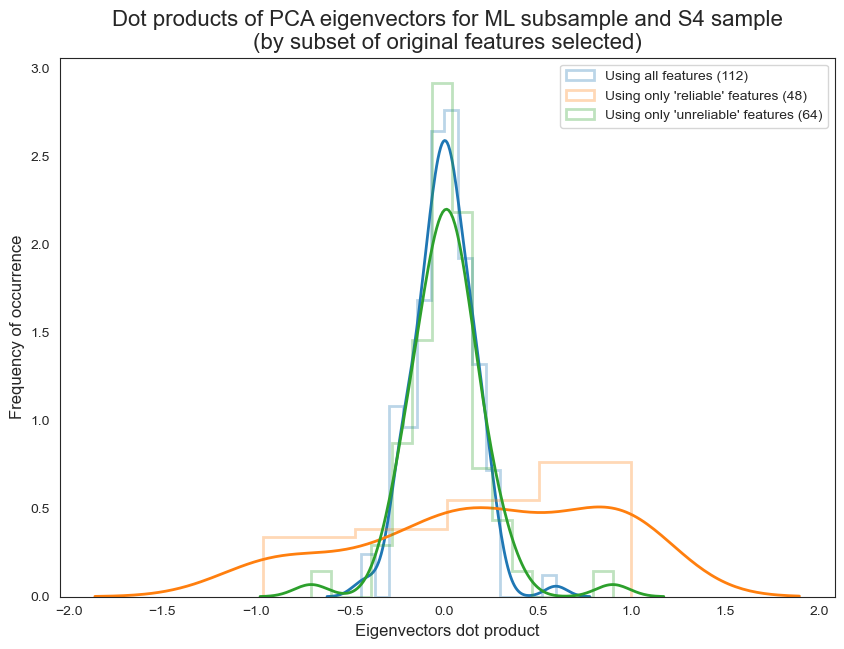

In [166]:
d_list = [dot_sc_cw.flatten(), dot_sc_cw_rel.flatten(),
          dot_sc_cw_unrel.flatten()]
d_labels = ["Using all features (112)", "Using only 'reliable' features (48)",
            "Using only 'unreliable' features (64)"]
varname = "Eigenvectors dot product"
fig_title = "Dot products of PCA eigenvectors for ML subsample and S4 sample\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20_18_Dist_PCA_ResultComp_DiagonalDotProducts.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

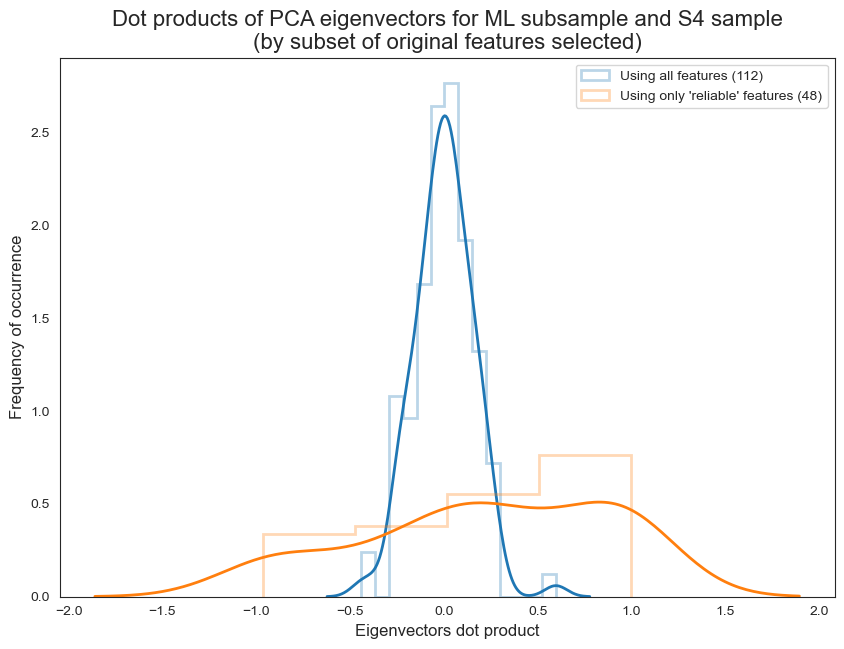

In [167]:
d_list = [dot_sc_cw.flatten(), dot_sc_cw_rel.flatten()]
d_labels = ["Using all features (%d)" %len(cs_f_list),
            "Using only 'reliable' features (%d)" %len(rel_features)]
varname = "Eigenvectors dot product"
fig_title = "Dot products of PCA eigenvectors for ML subsample and S4 sample\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20_18B_Dist_PCA_ResultComp_DiagonalDotProducts.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

**OBSERVATION:** this is apparently a good result. However, the left part of the orange curve could be a bad result if the eigenvectors provoking such "extreme" negative values (between $-1.0$ and $0.5$) have a high rank in the PCA.

Let's see this issue, by setting the rank and drawing a scatter plot of dot product values against vector ranking in the S4 sample:

In [168]:
dot_sc_cw_rel.flatten()

array([ 0.93404609,  0.92655889,  0.97467448,  0.22440423,  0.3845693 ,
        0.08115242, -0.53139519, -0.09367508, -0.2424877 ,  0.20569781,
        0.37283438, -0.35762015,  0.15619187,  0.01359901, -0.41162531,
       -0.03503642, -0.01943231,  0.13011466,  0.05829137, -0.24522715,
        0.66429876,  0.38196877,  0.27491532,  0.68776058,  0.58387631,
        0.80295274, -0.9074156 ,  0.91999723,  0.94767093, -0.96147954,
       -0.963869  ,  0.22883736, -0.24131369,  0.98461755,  0.98345868,
        0.96164163,  0.93176675,  0.9456977 , -0.93226657,  0.92770159,
        0.29259866,  0.25396513,  0.99931058,  0.99914151,  0.99941221,
       -0.89910497, -0.77987506, -0.86090454])

In [169]:
dp_rank_rel = pd.DataFrame(data={'PCA component rank': pd.Series([i + 1 for i in range(0, len(dot_sc_cw_rel.flatten()))]),
                             'ML and S4 eigenvectors dot product': dot_sc_cw_rel.flatten()})
dp_rank_rel

PCA component rank  ML and S4 eigenvectors dot product
0                    1                            0.934046
1                    2                            0.926559
2                    3                            0.974674
3                    4                            0.224404
4                    5                            0.384569
5                    6                            0.081152
6                    7                           -0.531395
7                    8                           -0.093675
8                    9                           -0.242488
9                   10                            0.205698
10                  11                            0.372834
11                  12                           -0.357620
12                  13                            0.156192
13                  14                            0.013599
14                  15                           -0.411625
15                  16                           -0.035036
16                  17                           -0.019432
17                  18                            0.130115
18                  19                            0.058291
19                  20                           -0.245227
20                  21                            0.664299
21                  22                            0.381969
22                  23                            0.274915
23                  24                            0.687761
24                  25                            0.583876
25                  26                            0.802953
26                  27                           -0.907416
27                  28                            0.919997
28                  29                            0.947671
29                  30                           -0.961480
30                  31                           -0.963869
31                  32                            0.228837
32                  33                           -0.241314
33                  34                            0.984618
34                  35                            0.983459
35                  36                            0.961642
36                  37                            0.931767
37                  38                            0.945698
38                  39                           -0.932267
39                  40                            0.927702
40                  41                            0.292599
41                  42                            0.253965
42                  43                            0.999311
43                  44                            0.999142
44                  45                            0.999412
45                  46                           -0.899105
46                  47                           -0.779875
47                  48                           -0.860905

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.015


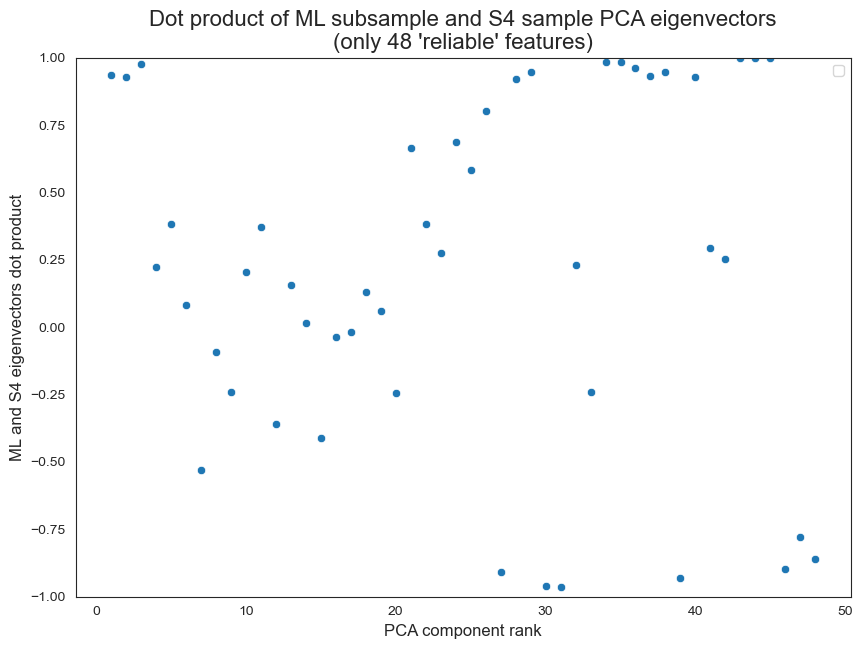

In [170]:
fig_title = "Dot product of ML subsample and S4 sample PCA eigenvectors\n(only %d 'reliable' features)" %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_19_PCA_Eigenvectors_Rank_vs_DotProduct_RelFeatures.jpg"
scatter_graph(data=dp_rank_rel, var_x='PCA component rank', var_y='ML and S4 eigenvectors dot product',
              fig_title=fig_title, fig_filename=fig_filename)

Let's see with all features:

In [171]:
dp_rank = pd.DataFrame(data={'PCA component rank': pd.Series([i + 1 for i in range(0, len(dot_sc_cw.flatten()))]),
                             'ML and S4 eigenvectors dot product': dot_sc_cw.flatten()})
dp_rank

PCA component rank  ML and S4 eigenvectors dot product
0                     1                            0.004051
1                     2                            0.035706
2                     3                           -0.033473
3                     4                           -0.232858
4                     5                            0.105546
..                  ...                                 ...
107                 108                           -0.198814
108                 109                            0.597440
109                 110                            0.078047
110                 111                            0.210972
111                 112                           -0.046046

[112 rows x 2 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.035


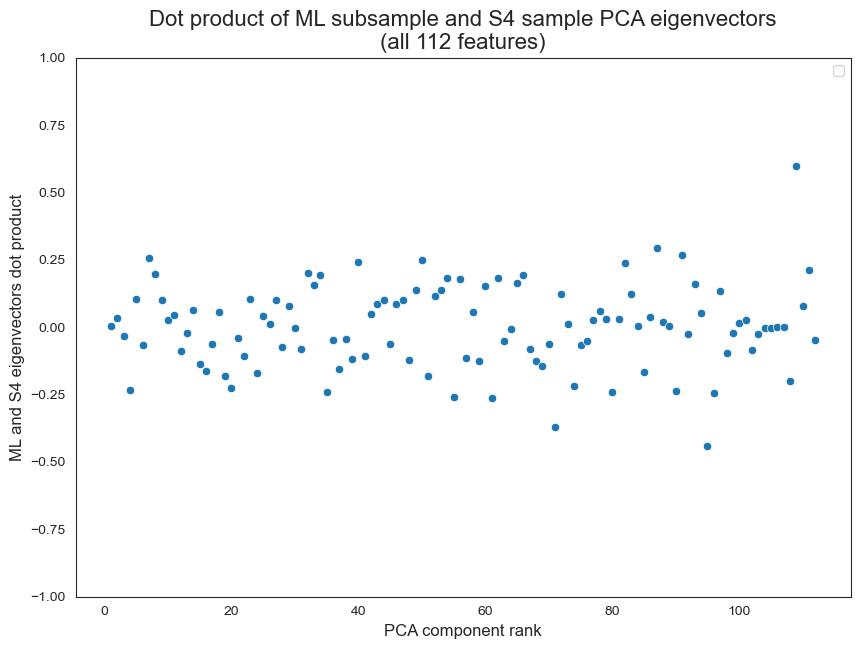

In [172]:
fig_title = "Dot product of ML subsample and S4 sample PCA eigenvectors\n(all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_20_PCA_Eigenvectors_Rank_vs_DotProduct_AllFeatures.jpg"
scatter_graph(data=dp_rank, var_x='PCA component rank', var_y='ML and S4 eigenvectors dot product',
              fig_title=fig_title, fig_filename=fig_filename)

**IMPORTANT CHECK:** Ensure that returned PCA components are normalized.

In [173]:
np.linalg.norm(pca_ml_sc.components_, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [174]:
np.linalg.norm(pca_ml_sc_rel.components_, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [175]:
np.linalg.norm(pca_ml_sc_unrel.components_, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Pulsating vs non-pulsating comparison: summary of eigenvectors / eigenvalues results

We just recall here the differences between the PCA results in pulsating and non-pulsating stars for the cases where we take all the features ($112$), only "unreliable" features ($64$), and only "reliable" features ($48$).

### Dot products, component-wise

#### Calculations

In [176]:
dot_sc_pnp = np.dot(pca_s4p_sc.components_, pca_s4np_sc.components_.T)
dot_sc_pnp

array([[-0.81875294, -0.10386733,  0.42336023, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20225663,  0.51315039,  0.04613802, ...,  0.        ,
        -0.        , -0.        ],
       [ 0.33187425,  0.04645674,  0.36178328, ...,  0.        ,
        -0.        ,  0.        ],
       ...,
       [-0.01478174,  0.07050229, -0.00487544, ...,  0.        ,
         0.        , -0.        ],
       [-0.04343747,  0.05735977, -0.09028289, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00343227,  0.03951763,  0.02476536, ..., -0.66270135,
        -0.2031572 ,  0.42244114]])

In [177]:
dot_sc_cw_pnp = np.diag(dot_sc_pnp)
dot_sc_cw_pnp

array([-0.81875294,  0.51315039,  0.36178328,  0.22932213, -0.12619485,
        0.03704764,  0.23495003, -0.09739742,  0.09249786, -0.03834388,
        0.0923903 , -0.06143149,  0.22845359,  0.25405942,  0.06467178,
       -0.04230682, -0.05293069,  0.16537902,  0.15269179, -0.06023512,
       -0.02219607, -0.06472025,  0.0330898 ,  0.03450049,  0.05960727,
       -0.12538832, -0.25674926, -0.07699004, -0.08324974,  0.05717162,
        0.14717637, -0.21498056, -0.06703158,  0.0282479 , -0.09625982,
        0.06488733, -0.19276911,  0.22999098,  0.01701337,  0.05636021,
        0.10887639, -0.2170893 , -0.10328446,  0.1368112 ,  0.05931866,
       -0.07518071, -0.05289742, -0.02493901,  0.23701817,  0.26732781,
        0.19830671, -0.11324252,  0.21281605, -0.00400973, -0.18375276,
        0.12345169, -0.22469973,  0.09138523,  0.15261555, -0.0234721 ,
        0.15157096,  0.08277223, -0.07877751, -0.04485843,  0.07065253,
       -0.05693044,  0.1321112 ,  0.18559124, -0.00680754,  0.00

In [178]:
dot_sc_pnp_unrel = np.dot(pca_s4p_sc_unrel.components_, pca_s4np_sc_unrel.components_.T)
dot_sc_pnp_unrel

array([[-0.6873332 ,  0.64445803,  0.05364391, ...,  0.00029138,
         0.        , -0.        ],
       [ 0.30053656,  0.32800147,  0.51470309, ...,  0.00275584,
        -0.        , -0.        ],
       [-0.14989753, -0.08150321, -0.61481405, ...,  0.00027918,
        -0.        , -0.        ],
       ...,
       [ 0.10559881,  0.20068181, -0.09442655, ..., -0.0184385 ,
        -0.56370696, -0.52282854],
       [ 0.12579064,  0.23905472, -0.1124821 , ..., -0.02196418,
         0.3720886 ,  0.53042209],
       [ 0.01725145,  0.03278495, -0.01542626, ..., -0.00301226,
         0.73741747, -0.66731007]])

In [179]:
dot_sc_cw_pnp_unrel = np.diag(dot_sc_pnp_unrel)
dot_sc_cw_pnp_unrel

array([-0.6873332 ,  0.32800147, -0.61481405,  0.01563875,  0.1320628 ,
        0.27541347,  0.44208823, -0.12895266, -0.10169327,  0.09756802,
        0.05788923, -0.23965391,  0.00416148, -0.26404561,  0.10226878,
        0.16135451, -0.0646689 ,  0.30467448,  0.15008542, -0.20203813,
        0.11671108, -0.1177701 ,  0.14611178, -0.09986858, -0.12679054,
        0.16557479, -0.10903445,  0.15509941, -0.12574525,  0.12312595,
       -0.20522678,  0.02614713, -0.04919255,  0.01405418, -0.15425761,
        0.01133702, -0.02154796, -0.10216962,  0.06202038, -0.1155299 ,
        0.08940669,  0.04706635, -0.094352  ,  0.18023597,  0.02165886,
       -0.1737572 , -0.05436104, -0.29275702, -0.0553913 ,  0.13929065,
        0.05748412, -0.07602098,  0.0897177 , -0.01353544, -0.11477403,
       -0.00509391,  0.02370396, -0.11778005, -0.03019152,  0.01012393,
       -0.00597103, -0.0184385 ,  0.3720886 , -0.66731007])

In [180]:
dot_sc_pnp_rel = np.dot(pca_s4p_sc_rel.components_, pca_s4np_sc_rel.components_.T)
dot_sc_pnp_rel

array([[-0.62398329,  0.71581569,  0.16746419, ...,  0.        ,
        -0.        ,  0.        ],
       [-0.09774067, -0.278955  ,  0.73814506, ...,  0.        ,
        -0.        , -0.        ],
       [ 0.46042656,  0.37035305,  0.43971185, ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [-0.        , -0.        ,  0.        , ...,  0.97409415,
        -0.01279023,  0.22578087],
       [ 0.        ,  0.        , -0.        , ..., -0.07168032,
        -0.96438046,  0.2546218 ],
       [-0.        , -0.        ,  0.        , ..., -0.21448199,
         0.26420965,  0.94031417]])

In [181]:
dot_sc_cw_pnp_rel = np.diag(dot_sc_pnp_rel)
dot_sc_cw_pnp_rel

array([-0.62398329, -0.278955  ,  0.43971185,  0.43646981,  0.06099819,
        0.30108573,  0.22833432, -0.23070816,  0.21882043,  0.00389271,
       -0.30477075, -0.22711726, -0.37532383,  0.14282373, -0.2557796 ,
        0.14100444, -0.29897385, -0.08911226,  0.00421875, -0.15514965,
        0.03568492,  0.13621952, -0.18163946, -0.20023228, -0.3726078 ,
        0.32868138,  0.23145015,  0.1802781 ,  0.35291951, -0.035121  ,
       -0.40366858, -0.14207936,  0.08618441,  0.64212045,  0.11352086,
        0.30561612, -0.46731725, -0.23676345, -0.13919938,  0.23104092,
       -0.20355696,  0.04723308,  0.03803916,  0.09520315, -0.951319  ,
        0.97409415, -0.96438046,  0.94031417])

##### All dot products

In [182]:
print("All features - Dot products, all vectors")
pd.Series(dot_sc_pnp.flatten()).describe()

All features - Dot products, all vectors


count    1.164800e+04
mean    -1.585517e-03
std      9.448187e-02
min     -8.187529e-01
25%     -4.199993e-02
50%     -4.450583e-17
75%      3.971188e-02
max      5.822948e-01
dtype: float64

In [183]:
print("Only 'unreliable' features - Dot products, all vectors")
pd.Series(dot_sc_pnp_unrel.flatten()).describe()

Only 'unreliable' features - Dot products, all vectors


count    4.096000e+03
mean    -1.646179e-03
std      1.250044e-01
min     -9.332017e-01
25%     -5.304035e-02
50%     -1.256125e-16
75%      4.950116e-02
max      8.135559e-01
dtype: float64

In [184]:
print("Only 'reliable' features - Dot products, all vectors")
pd.Series(dot_sc_pnp_rel.flatten()).describe()

Only 'reliable' features - Dot products, all vectors


count    2.304000e+03
mean    -1.274180e-03
std      1.443633e-01
min     -9.643805e-01
25%     -3.494728e-02
50%      2.385172e-17
75%      3.947851e-02
max      9.740941e-01
dtype: float64

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

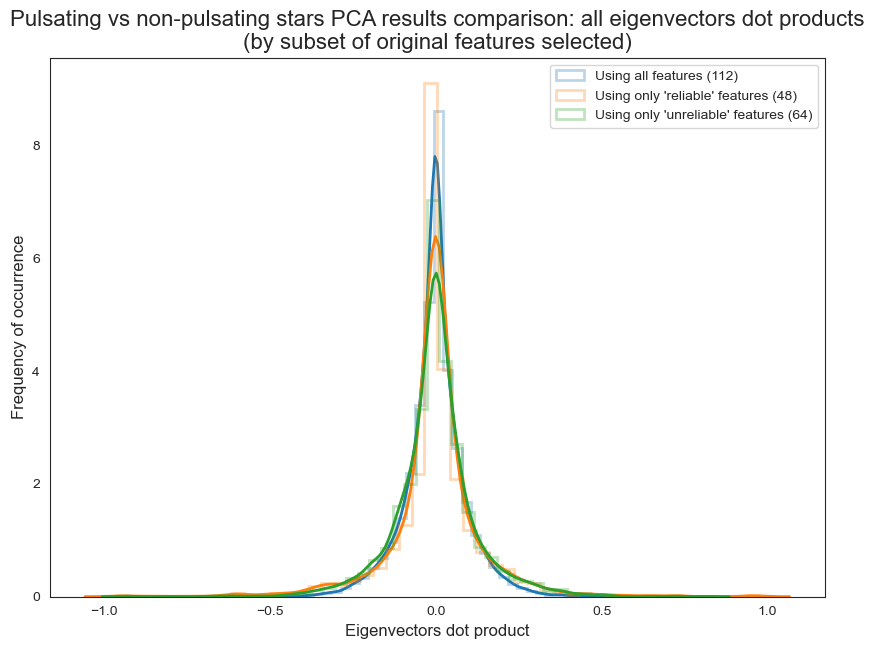

In [185]:
d_list = [dot_sc_pnp.flatten(), dot_sc_pnp_rel.flatten(),
          dot_sc_pnp_unrel.flatten()]
d_labels = ["Using all features (112)", "Using only 'reliable' features (48)",
            "Using only 'unreliable' features (64)"]
varname = "Eigenvectors dot product"
fig_title = "Pulsating vs non-pulsating stars PCA results comparison: all eigenvectors dot products\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20_17PNP_Dist_PCA_ResultComp_AllDotProducts.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

##### Only vector to vector (first with first, second with second, etc)

In [186]:
print("All features - Dot products, vector-wise")
pd.Series(dot_sc_cw_pnp.flatten()).describe()

All features - Dot products, vector-wise


count    104.000000
mean       0.004940
std        0.172903
min       -0.818753
25%       -0.096308
50%        0.003075
75%        0.097158
max        0.513150
dtype: float64

In [187]:
print("Only 'unreliable' features - Dot products, vector-wise")
pd.Series(dot_sc_cw_pnp_unrel.flatten()).describe()

Only 'unreliable' features - Dot products, vector-wise


count    64.000000
mean     -0.020748
std       0.205999
min      -0.687333
25%      -0.114963
50%      -0.005532
75%       0.098743
max       0.442088
dtype: float64

In [188]:
print("Only 'reliable' features - Dot products, vector-wise")
pd.Series(dot_sc_cw_pnp_rel.flatten()).describe()

Only 'reliable' features - Dot products, vector-wise


count    48.000000
mean     -0.008787
std       0.384201
min      -0.964380
25%      -0.232222
50%       0.019952
75%       0.221199
max       0.974094
dtype: float64

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

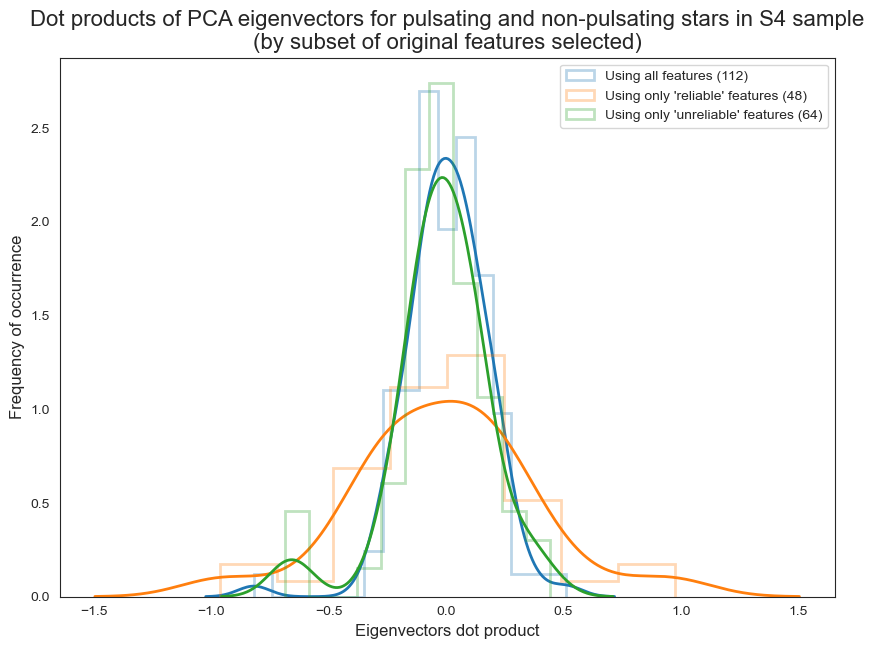

In [189]:
d_list = [dot_sc_cw_pnp.flatten(), dot_sc_cw_pnp_rel.flatten(),
          dot_sc_cw_pnp_unrel.flatten()]
d_labels = ["Using all features (112)", "Using only 'reliable' features (48)",
            "Using only 'unreliable' features (64)"]
varname = "Eigenvectors dot product"
fig_title = "Dot products of PCA eigenvectors for pulsating and non-pulsating stars in S4 sample\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20_18PNP_Dist_PCA_ResultComp_DiagonalDotProducts.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
C:\Users\ciroe\AppData\Local\Temp\ipykernel_14192\2658504742.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  new_axis = sns.distpl

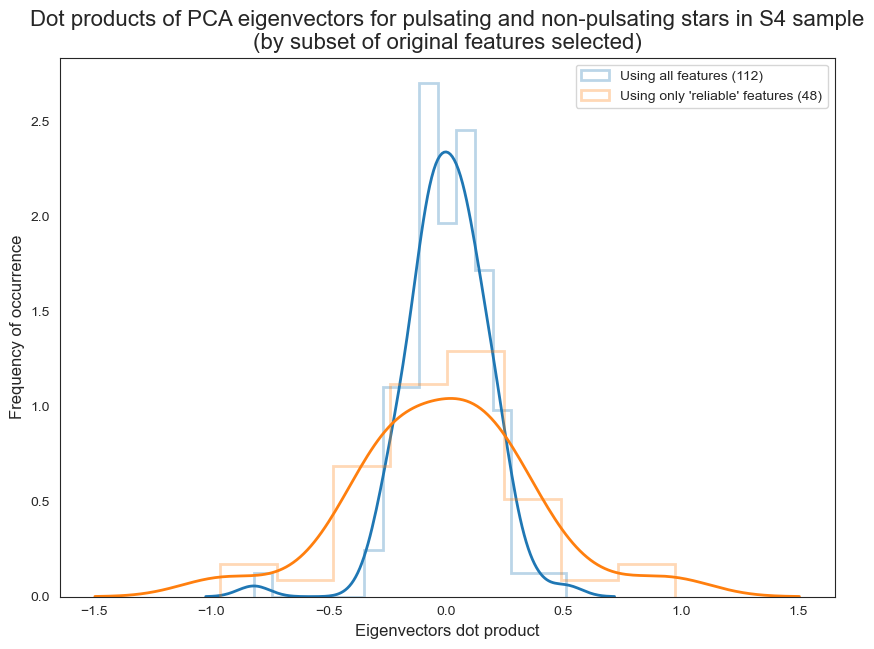

In [190]:
d_list = [dot_sc_cw_pnp.flatten(), dot_sc_cw_pnp_rel.flatten()]
d_labels = ["Using all features (%d)" %len(cs_f_list),
            "Using only 'reliable' features (%d)" %len(rel_features)]
varname = "Eigenvectors dot product"
fig_title = "Dot products of PCA eigenvectors for pulsating and non-pulsating stars in S4 sample\n" \
    "(by subset of original features selected)"
fig_filename = IMAGE_FOLDER + "ML_20PNP_18B_Dist_PCA_ResultComp_DiagonalDotProducts.jpg"
kde = True
hist = False
hist_fill = False
multi_compare_dist(d_list=d_list, d_labels=d_labels, varname=varname, fig_title=fig_title,
                   fig_filename=fig_filename,
                   kde=kde, hist=hist, hist_fill=hist_fill)

**OBSERVATION:** this is apparently a good result. However, the left part of the orange curve could be a bad result if the eigenvectors provoking such "extreme" negative values (between $-1.0$ and $0.5$) have a high rank in the PCA.

Let's see this issue, by setting the rank and drawing a scatter plot of dot product values against vector ranking in the S4 sample:

In [191]:
dot_sc_cw_pnp_rel.flatten()

array([-0.62398329, -0.278955  ,  0.43971185,  0.43646981,  0.06099819,
        0.30108573,  0.22833432, -0.23070816,  0.21882043,  0.00389271,
       -0.30477075, -0.22711726, -0.37532383,  0.14282373, -0.2557796 ,
        0.14100444, -0.29897385, -0.08911226,  0.00421875, -0.15514965,
        0.03568492,  0.13621952, -0.18163946, -0.20023228, -0.3726078 ,
        0.32868138,  0.23145015,  0.1802781 ,  0.35291951, -0.035121  ,
       -0.40366858, -0.14207936,  0.08618441,  0.64212045,  0.11352086,
        0.30561612, -0.46731725, -0.23676345, -0.13919938,  0.23104092,
       -0.20355696,  0.04723308,  0.03803916,  0.09520315, -0.951319  ,
        0.97409415, -0.96438046,  0.94031417])

In [192]:
dp_rank_pnp_rel = pd.DataFrame(
    data={'PCA component rank': pd.Series([i + 1 for i in range(0, len(dot_sc_cw_pnp_rel.flatten()))]),
          'Pulsating and Non-pulsating eigenvectors dot product': dot_sc_cw_pnp_rel.flatten()})
dp_rank_pnp_rel

PCA component rank  Pulsating and Non-pulsating eigenvectors dot product
0                    1                                          -0.623983   
1                    2                                          -0.278955   
2                    3                                           0.439712   
3                    4                                           0.436470   
4                    5                                           0.060998   
5                    6                                           0.301086   
6                    7                                           0.228334   
7                    8                                          -0.230708   
8                    9                                           0.218820   
9                   10                                           0.003893   
10                  11                                          -0.304771   
11                  12                                          -0.227117   
12                  13                                          -0.375324   
13                  14                                           0.142824   
14                  15                                          -0.255780   
15                  16                                           0.141004   
16                  17                                          -0.298974   
17                  18                                          -0.089112   
18                  19                                           0.004219   
19                  20                                          -0.155150   
20                  21                                           0.035685   
21                  22                                           0.136220   
22                  23                                          -0.181639   
23                  24                                          -0.200232   
24                  25                                          -0.372608   
25                  26                                           0.328681   
26                  27                                           0.231450   
27                  28                                           0.180278   
28                  29                                           0.352920   
29                  30                                          -0.035121   
30                  31                                          -0.403669   
31                  32                                          -0.142079   
32                  33                                           0.086184   
33                  34                                           0.642120   
34                  35                                           0.113521   
35                  36                                           0.305616   
36                  37                                          -0.467317   
37                  38                                          -0.236763   
38                  39                                          -0.139199   
39                  40                                           0.231041   
40                  41                                          -0.203557   
41                  42                                           0.047233   
42                  43                                           0.038039   
43                  44                                           0.095203   
44                  45                                          -0.951319   
45                  46                                           0.974094   
46                  47                                          -0.964380   
47                  48                                           0.940314

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.046


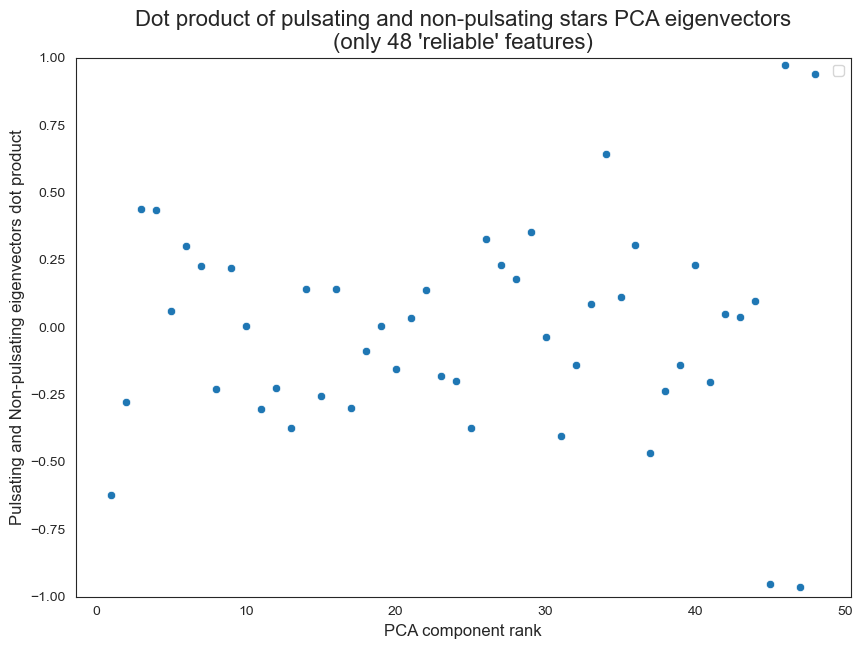

In [193]:
fig_title = "Dot product of pulsating and non-pulsating stars PCA eigenvectors\n(only %d 'reliable' features)" \
    %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_19PNP_PCA_Eigenvectors_Rank_vs_DotProduct_RelFeatures.jpg"
scatter_graph(data=dp_rank_pnp_rel, var_x='PCA component rank',
              var_y='Pulsating and Non-pulsating eigenvectors dot product',
              fig_title=fig_title, fig_filename=fig_filename)

Let's see with all features:

In [194]:
dp_rank_pnp = pd.DataFrame(
    data={'PCA component rank': pd.Series([i + 1 for i in range(0, len(dot_sc_cw_pnp.flatten()))]),
          'Pulsating and Non-pulsating eigenvectors dot product': dot_sc_cw_pnp.flatten()})
dp_rank_pnp

PCA component rank  Pulsating and Non-pulsating eigenvectors dot product
0                     1                                          -0.818753   
1                     2                                           0.513150   
2                     3                                           0.361783   
3                     4                                           0.229322   
4                     5                                          -0.126195   
..                  ...                                                ...   
99                  100                                           0.324516   
100                 101                                           0.093251   
101                 102                                           0.055295   
102                 103                                          -0.277987   
103                 104                                           0.087872   

[104 rows x 2 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.116


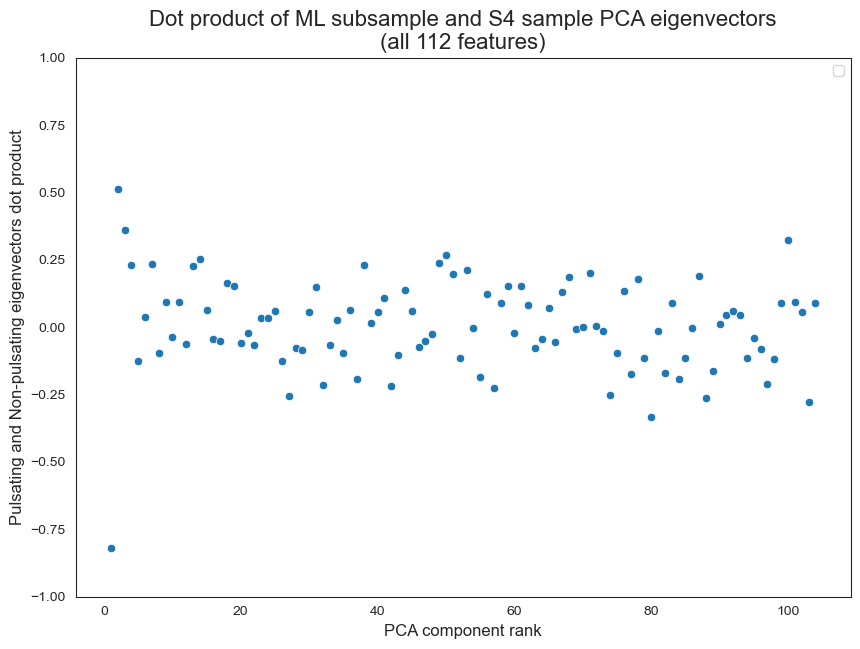

In [195]:
fig_title = "Dot product of ML subsample and S4 sample PCA eigenvectors\n(all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_20PNP_PCA_Eigenvectors_Rank_vs_DotProduct_AllFeatures.jpg"
scatter_graph(data=dp_rank_pnp, var_x='PCA component rank', var_y='Pulsating and Non-pulsating eigenvectors dot product',
              fig_title=fig_title, fig_filename=fig_filename)

**IMPORTANT CHECK:** Ensure that returned PCA components are normalized.

In [196]:
np.linalg.norm(pca_ml_sc.components_, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [197]:
np.linalg.norm(pca_ml_sc_rel.components_, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [198]:
np.linalg.norm(pca_ml_sc_unrel.components_, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Combined graphs ML subsample and S4 sample

### Combined variance explained graphs

#### All features

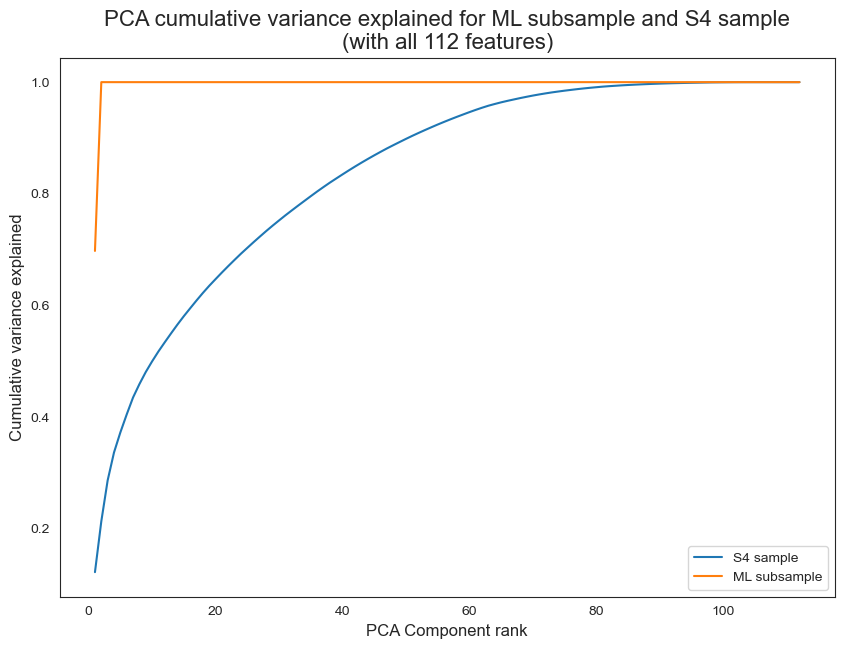

In [199]:
x_list = [np.arange(1, len(exp_var_s4_sc) + 1),
          np.arange(1, len(exp_var_ml_sc) + 1)]
y_list = [exp_var_s4_sc.cumsum(), exp_var_ml_sc.cumsum()]
dlabel_list = ["S4 sample", "ML subsample"]
xlabel = "PCA Component rank"
ylabel = "Cumulative variance explained"
fig_title = "PCA cumulative variance explained for ML subsample and S4 sample\n" \
    "(with all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_21_S4MLComp_AllFeat_CumVarianceExplained.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)


#### Only reliable features

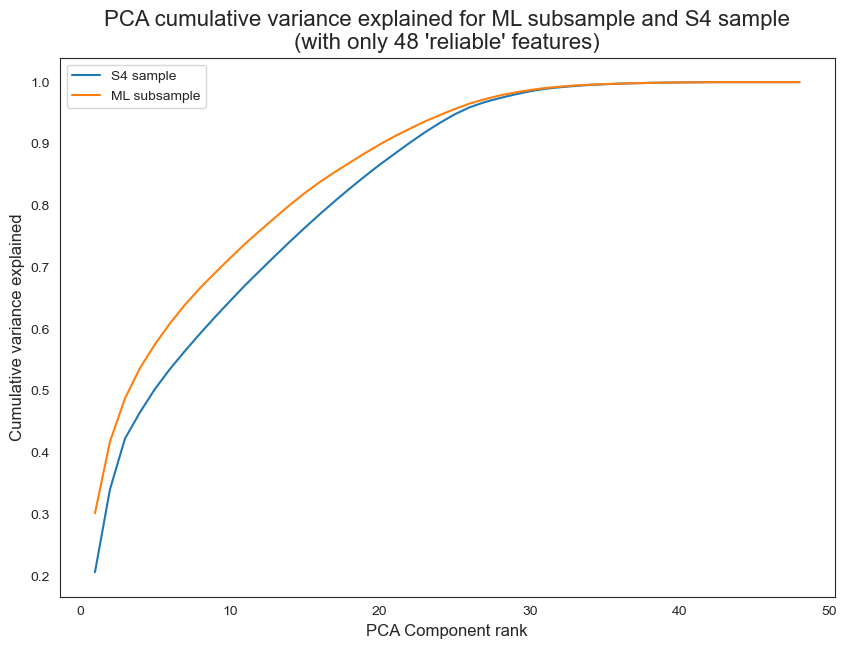

In [200]:
x_list = [np.arange(1, len(exp_var_s4_sc_rel) + 1),
          np.arange(1, len(exp_var_ml_sc_rel) + 1)]
y_list = [exp_var_s4_sc_rel.cumsum(), exp_var_ml_sc_rel.cumsum()]
dlabel_list = ["S4 sample", "ML subsample"]
xlabel = "PCA Component rank"
ylabel = "Cumulative variance explained"
fig_title = "PCA cumulative variance explained for ML subsample and S4 sample\n" \
    "(with only %d 'reliable' features)" %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_22_S4MLComp_RelFeat_CumVarianceExplained.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)


### Combined eigenvalues graphs

#### All features

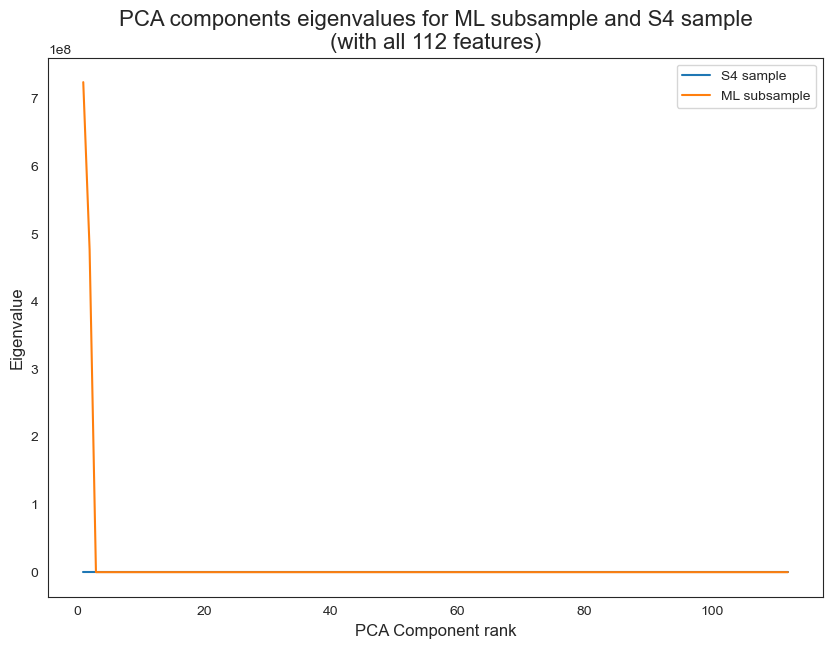

In [201]:
x_list = [np.arange(1, len(sv_s4_sc) + 1),
          np.arange(1, len(sv_ml_sc) + 1)]
y_list = [sv_s4_sc, sv_ml_sc]
dlabel_list = ["S4 sample", "ML subsample"]
xlabel = "PCA Component rank"
ylabel = "Eigenvalue"
fig_title = "PCA components eigenvalues for ML subsample and S4 sample\n" \
    "(with all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_23_S4MLComp_AllFeat_Eigenvalues.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

#### Only reliable features

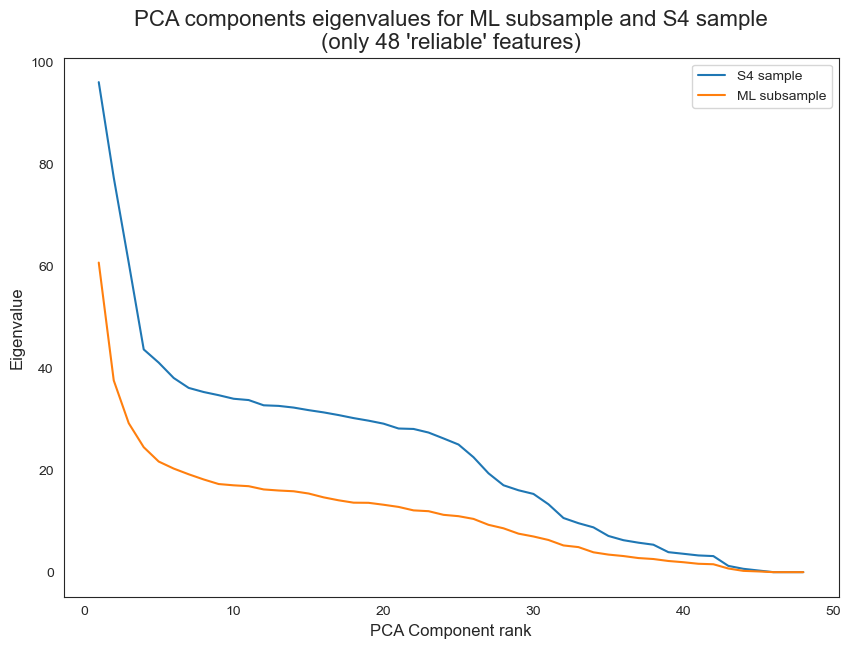

In [202]:
x_list = [np.arange(1, len(sv_s4_sc_rel) + 1),
          np.arange(1, len(sv_ml_sc_rel) + 1)]
y_list = [sv_s4_sc_rel, sv_ml_sc_rel]
dlabel_list = ["S4 sample", "ML subsample"]
xlabel = "PCA Component rank"
ylabel = "Eigenvalue"
fig_title = "PCA components eigenvalues for ML subsample and S4 sample\n" \
    "(only %d 'reliable' features)" %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_24_S4MLComp_RelFeat_Eigenvalues.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

### Combined components dot product vs rank

#### All features vs only reliable features

Pearson's correlation value for 'All 112 features': 0.035
Pearson's correlation value for 'Only 48 'reliable' features': -0.015


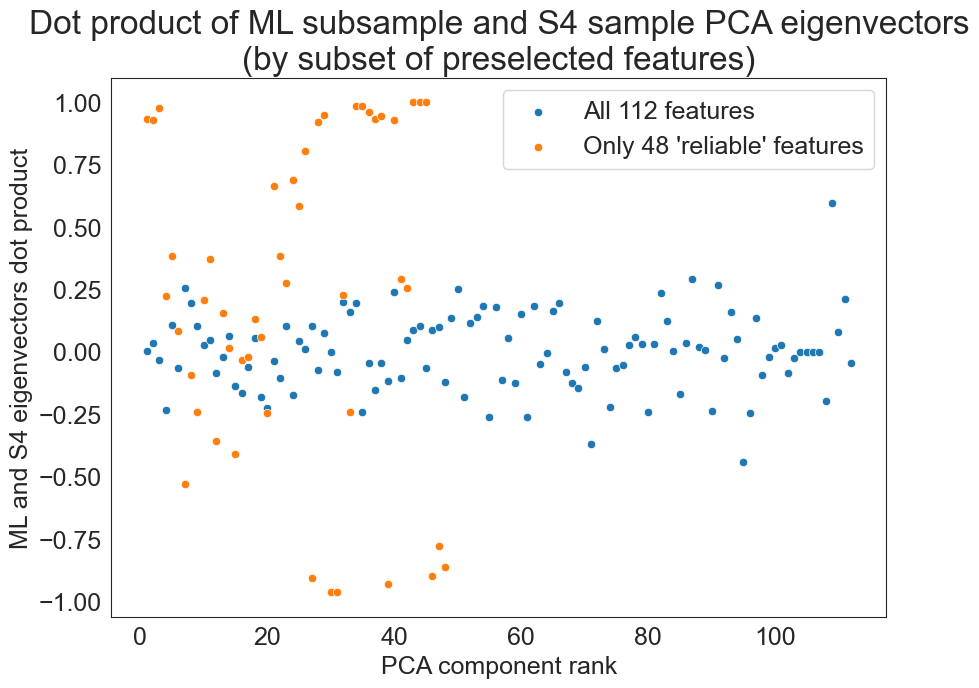

In [223]:
data_list = [dp_rank, dp_rank_rel]
var_x_list = ['PCA component rank', 'PCA component rank']
var_y_list = ['ML and S4 eigenvectors dot product', 'ML and S4 eigenvectors dot product']
dlabel_list = ["All %d features" %len(cs_f_list), "Only %d 'reliable' features" %len(rel_features)]
xlabel = 'PCA component rank'
ylabel = 'ML and S4 eigenvectors dot product'
fig_title = "Dot product of ML subsample and S4 sample PCA eigenvectors\n(by subset of preselected features)"
fig_filename = IMAGE_FOLDER + "ML_20_25_PCA_AllRelComp_Eigenvectors_Rank_vs_DotProduct.jpg"

multi_scatter_graph(data_list=data_list, var_x_list=var_x_list, var_y_list=var_y_list,
                    dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

## Combined graphs pulsating and non-pulsating stars

### Combined variance explained graphs

#### All features

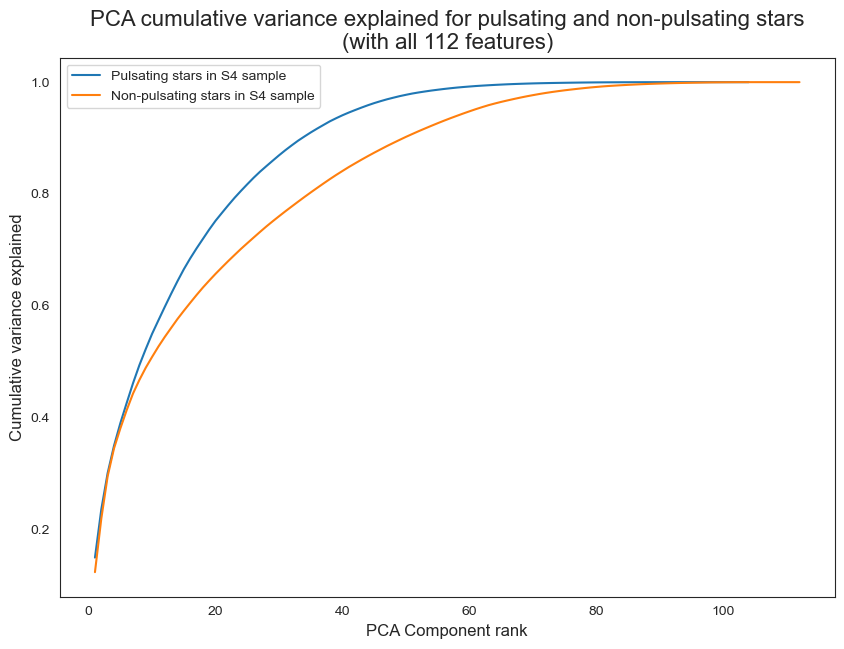

In [204]:
x_list = [np.arange(1, len(exp_var_s4p_sc) + 1),
          np.arange(1, len(exp_var_s4np_sc) + 1)]
y_list = [exp_var_s4p_sc.cumsum(), exp_var_s4np_sc.cumsum()]
dlabel_list = ["Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Cumulative variance explained"
fig_title = "PCA cumulative variance explained for pulsating and non-pulsating stars\n" \
    "(with all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_21PNP_S4MLComp_AllFeat_CumVarianceExplained.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)


#### Only reliable features

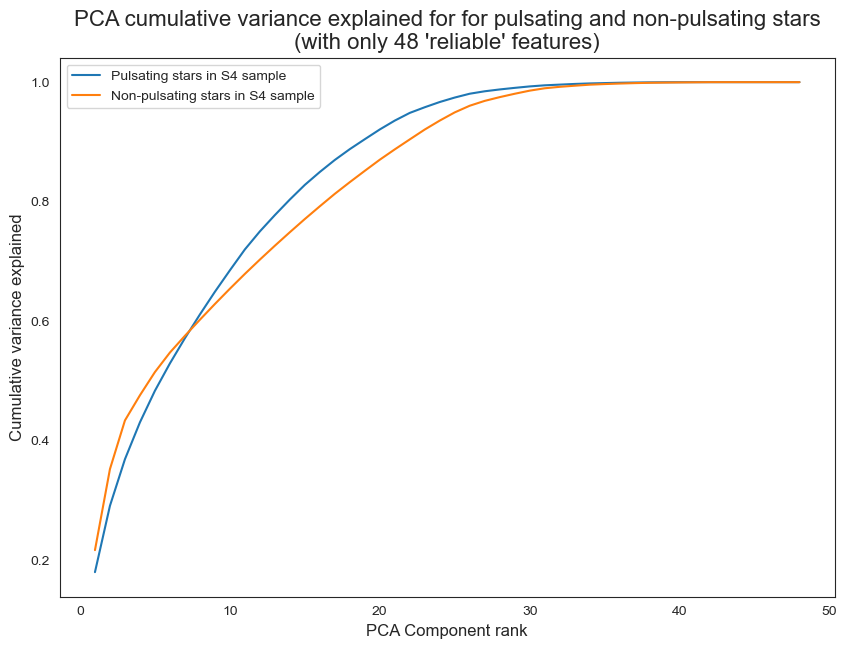

In [205]:
x_list = [np.arange(1, len(exp_var_s4p_sc_rel) + 1),
          np.arange(1, len(exp_var_s4np_sc_rel) + 1)]
y_list = [exp_var_s4p_sc_rel.cumsum(), exp_var_s4np_sc_rel.cumsum()]
dlabel_list = ["Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Cumulative variance explained"
fig_title = "PCA cumulative variance explained for for pulsating and non-pulsating stars\n" \
    "(with only %d 'reliable' features)" %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_22PNP_S4MLComp_RelFeat_CumVarianceExplained.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)


### Combined eigenvalues graphs

#### All features

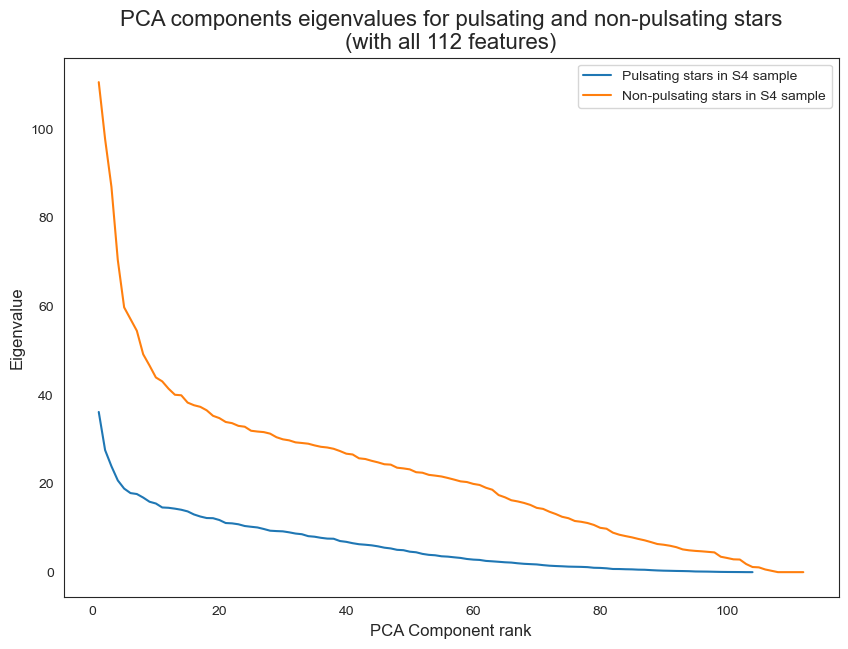

In [206]:
x_list = [np.arange(1, len(sv_s4p_sc) + 1),
          np.arange(1, len(sv_s4np_sc) + 1)]
y_list = [sv_s4p_sc, sv_s4np_sc]
dlabel_list = ["Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Eigenvalue"
fig_title = "PCA components eigenvalues for pulsating and non-pulsating stars\n" \
    "(with all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_23PNP_S4MLComp_AllFeat_Eigenvalues.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

#### Only reliable features

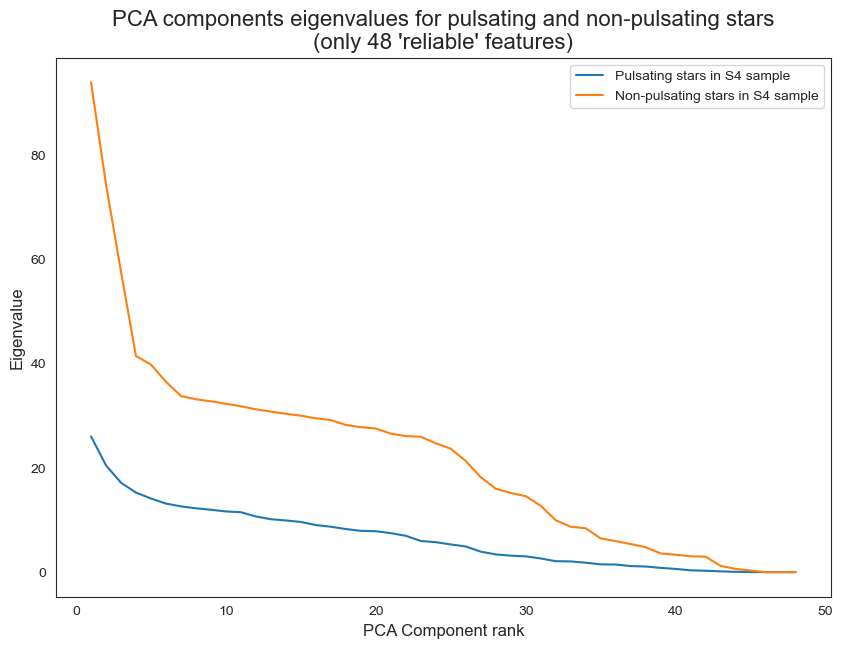

In [207]:
x_list = [np.arange(1, len(sv_s4p_sc_rel) + 1),
          np.arange(1, len(sv_s4np_sc_rel) + 1)]
y_list = [sv_s4p_sc_rel, sv_s4np_sc_rel]
dlabel_list = ["Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Eigenvalue"
fig_title = "PCA components eigenvalues for pulsating and non-pulsating stars\n" \
    "(only %d 'reliable' features)" %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_24PNP_S4MLComp_RelFeat_Eigenvalues.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

### Combined components dot product vs rank

#### All features vs only reliable features

Pearson's correlation value for 'All 112 features': -0.116
Pearson's correlation value for 'Only 48 'reliable' features': 0.046


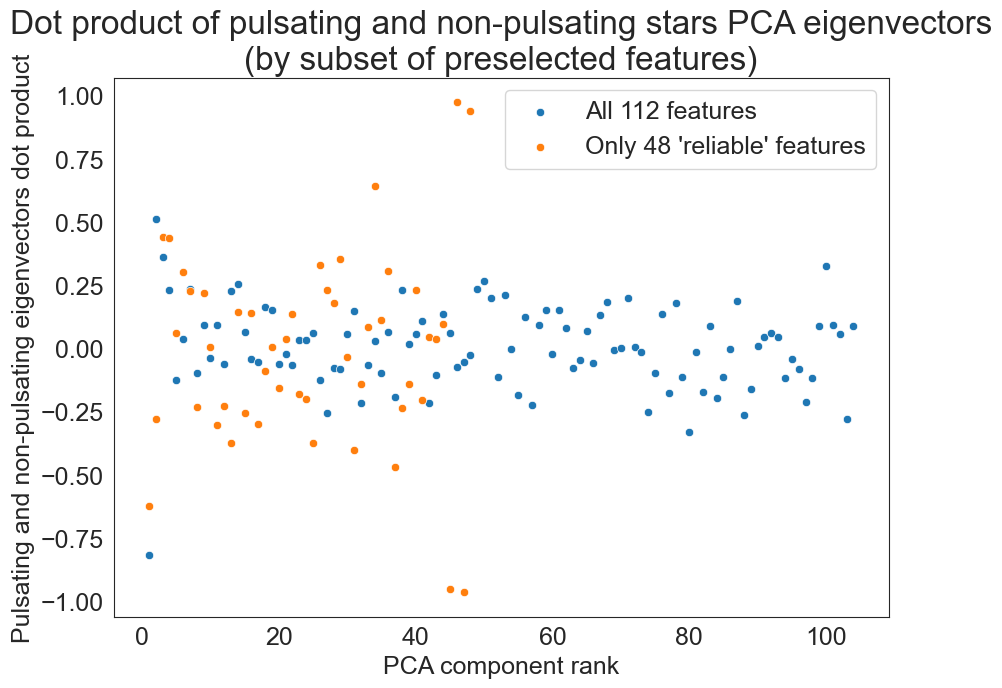

In [224]:
data_list = [dp_rank_pnp, dp_rank_pnp_rel]
var_x_list = ['PCA component rank', 'PCA component rank']
var_y_list = ['Pulsating and Non-pulsating eigenvectors dot product',
              'Pulsating and Non-pulsating eigenvectors dot product']
dlabel_list = ["All %d features" %len(cs_f_list), "Only %d 'reliable' features" %len(rel_features)]
xlabel = 'PCA component rank'
ylabel = 'Pulsating and non-pulsating eigenvectors dot product'
fig_title = "Dot product of pulsating and non-pulsating stars PCA eigenvectors\n(by subset of preselected features)"
fig_filename = IMAGE_FOLDER + "ML_20_25PNP_PCA_AllRelComp_Eigenvectors_Rank_vs_DotProduct.jpg"

multi_scatter_graph(data_list=data_list, var_x_list=var_x_list, var_y_list=var_y_list,
                    dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

## Combined graphs: ML, S4, pulsating and non-pulsating stars

### Combined variance explained graphs

#### All features

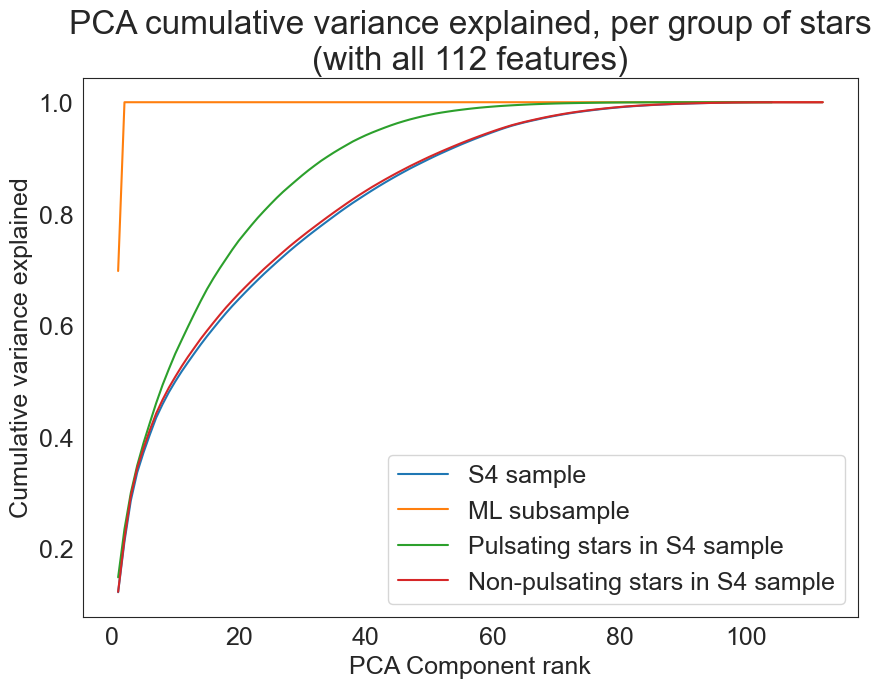

In [216]:
x_list = [np.arange(1, len(exp_var_s4_sc) + 1), np.arange(1, len(exp_var_ml_sc) + 1),
          np.arange(1, len(exp_var_s4p_sc) + 1), np.arange(1, len(exp_var_s4np_sc) + 1)]
y_list = [exp_var_s4_sc.cumsum(), exp_var_ml_sc.cumsum(),
          exp_var_s4p_sc.cumsum(), exp_var_s4np_sc.cumsum()]
dlabel_list = ["S4 sample", "ML subsample",
               "Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Cumulative variance explained"
fig_title = "PCA cumulative variance explained, per group of stars\n" \
    "(with all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_21ALL_S4MLPNPComp_AllFeat_CumVarianceExplained.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)


#### Only reliable features

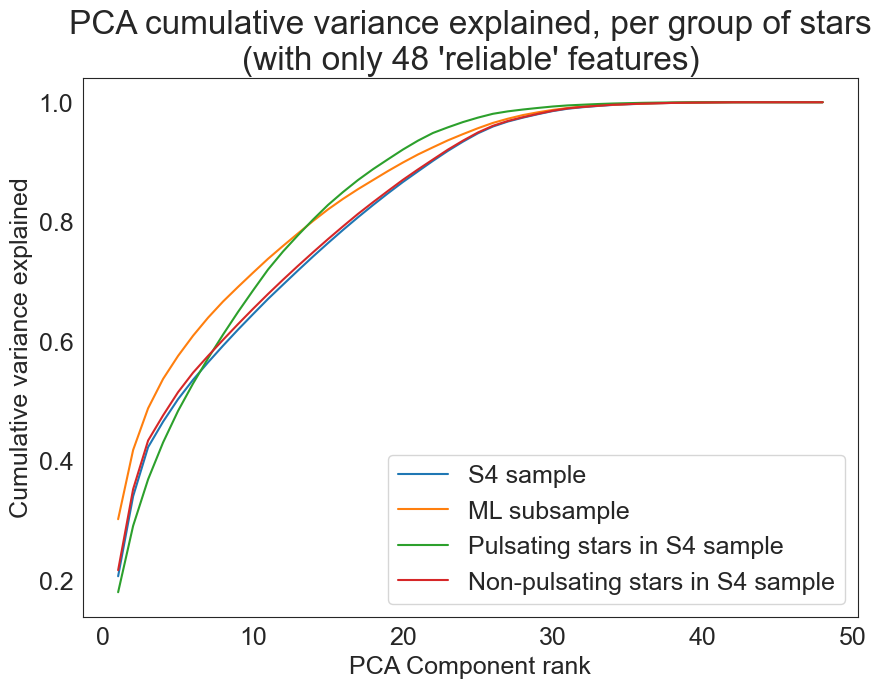

In [217]:
x_list = [np.arange(1, len(exp_var_s4_sc_rel) + 1), np.arange(1, len(exp_var_ml_sc_rel) + 1),
          np.arange(1, len(exp_var_s4p_sc_rel) + 1), np.arange(1, len(exp_var_s4np_sc_rel) + 1)]
y_list = [exp_var_s4_sc_rel.cumsum(), exp_var_ml_sc_rel.cumsum(),
          exp_var_s4p_sc_rel.cumsum(), exp_var_s4np_sc_rel.cumsum()]
dlabel_list = ["S4 sample", "ML subsample",
               "Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Cumulative variance explained"
fig_title = "PCA cumulative variance explained, per group of stars\n" \
    "(with only %d 'reliable' features)" %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_22ALL_S4MLPNPComp_RelFeat_CumVarianceExplained.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)


### Combined eigenvalues graphs

#### All features

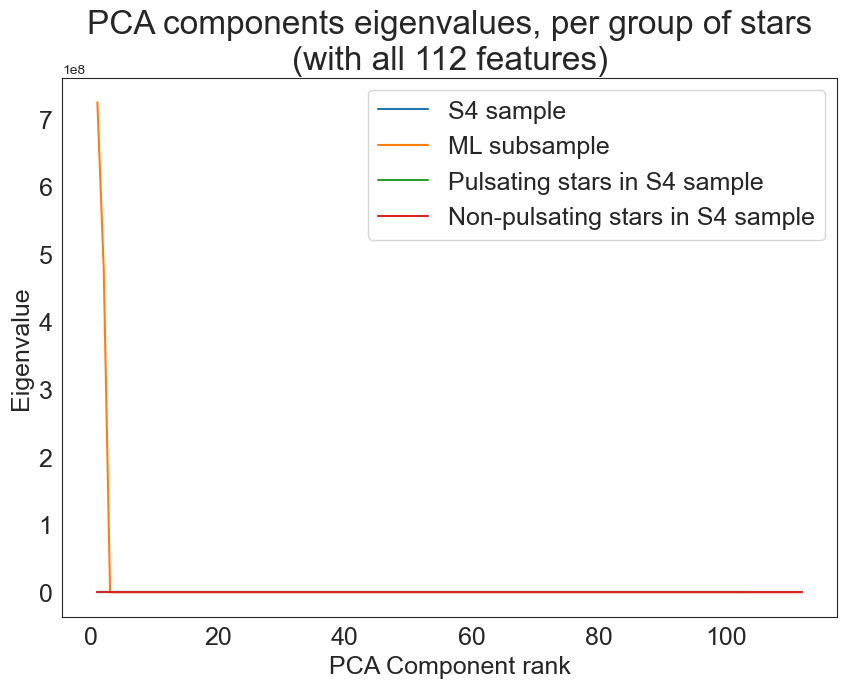

In [218]:
x_list = [np.arange(1, len(sv_s4_sc) + 1), np.arange(1, len(sv_ml_sc) + 1),
          np.arange(1, len(sv_s4p_sc) + 1), np.arange(1, len(sv_s4np_sc) + 1)]
y_list = [sv_s4_sc, sv_ml_sc,
          sv_s4p_sc, sv_s4np_sc]
dlabel_list = ["S4 sample", "ML subsample",
               "Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Eigenvalue"
fig_title = "PCA components eigenvalues, per group of stars\n" \
    "(with all %d features)" %len(cs_f_list)
fig_filename = IMAGE_FOLDER + "ML_20_23ALL_S4MLPNPComp_AllFeat_Eigenvalues.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

#### Only reliable features

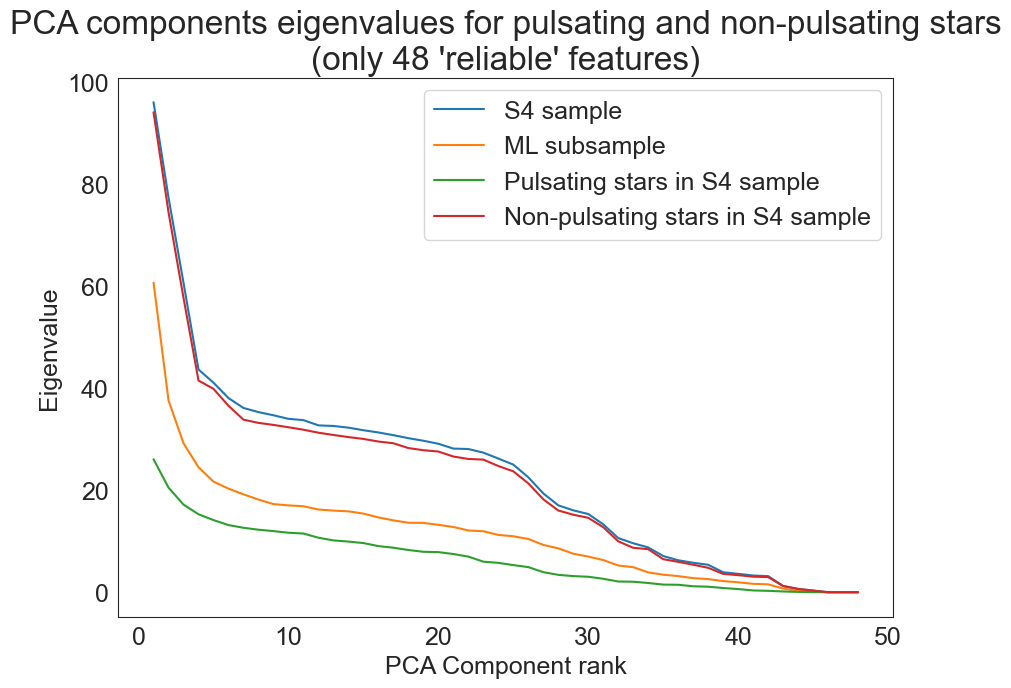

In [219]:
x_list = [np.arange(1, len(sv_s4_sc_rel) + 1), np.arange(1, len(sv_ml_sc_rel) + 1),
          np.arange(1, len(sv_s4p_sc_rel) + 1), np.arange(1, len(sv_s4np_sc_rel) + 1)]
y_list = [sv_s4_sc_rel, sv_ml_sc_rel,
          sv_s4p_sc_rel, sv_s4np_sc_rel]
dlabel_list = ["S4 sample", "ML subsample",
               "Pulsating stars in S4 sample", "Non-pulsating stars in S4 sample"]
xlabel = "PCA Component rank"
ylabel = "Eigenvalue"
fig_title = "PCA components eigenvalues for pulsating and non-pulsating stars\n" \
    "(only %d 'reliable' features)" %len(rel_features)
fig_filename = IMAGE_FOLDER + "ML_20_24ALL_S4MLPNPComp_RelFeat_Eigenvalues.jpg"

multi_draw_lineplot(x_list=x_list, y_list=y_list, dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

### Combined components dot product vs rank

#### All features vs only reliable features

Pearson's correlation value for 'ML/S4, all 112 features': 0.035
Pearson's correlation value for 'ML/S4, only 48 'reliable' features': -0.015
Pearson's correlation value for 'P/NP, all 112 features': -0.116
Pearson's correlation value for 'P/NP, only 48 'reliable' features': 0.046


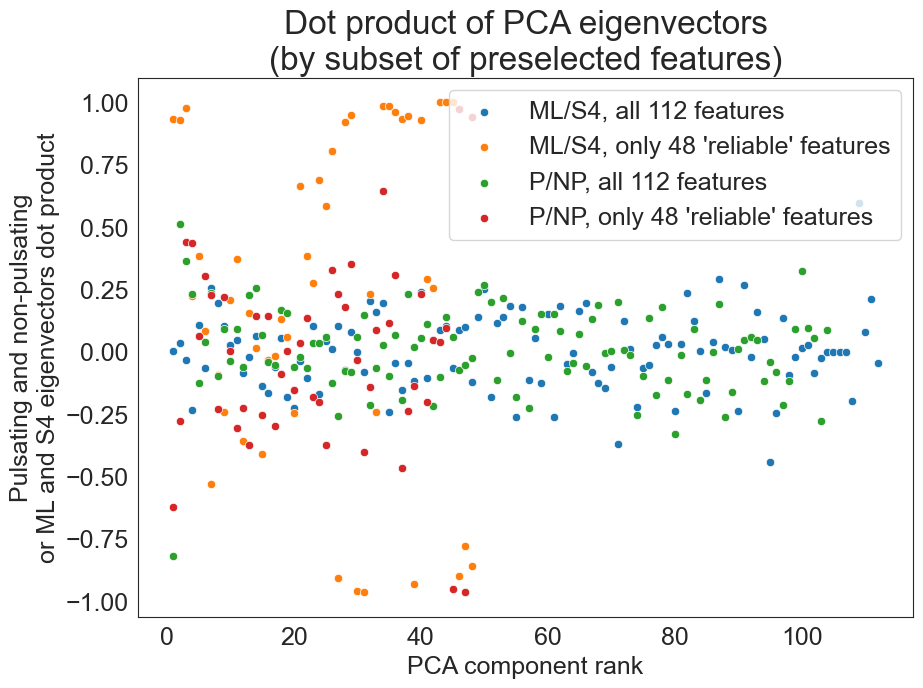

In [221]:
data_list = [dp_rank, dp_rank_rel,
             dp_rank_pnp, dp_rank_pnp_rel]
var_x_list = ['PCA component rank', 'PCA component rank',
              'PCA component rank', 'PCA component rank']
var_y_list = ['ML and S4 eigenvectors dot product',
              'ML and S4 eigenvectors dot product',
              'Pulsating and Non-pulsating eigenvectors dot product',
              'Pulsating and Non-pulsating eigenvectors dot product']
dlabel_list = ["ML/S4, all %d features" %len(cs_f_list), "ML/S4, only %d 'reliable' features" %len(rel_features),
               "P/NP, all %d features" %len(cs_f_list), "P/NP, only %d 'reliable' features" %len(rel_features)]
xlabel = 'PCA component rank'
ylabel = 'Pulsating and non-pulsating\nor ML and S4 eigenvectors dot product'
fig_title = "Dot product of PCA eigenvectors\n(by subset of preselected features)"
fig_filename = IMAGE_FOLDER + "ML_20_25ALL_PCA_S4MLPNPAllRelComp_Eigenvectors_Rank_vs_DotProduct.jpg"

multi_scatter_graph(data_list=data_list, var_x_list=var_x_list, var_y_list=var_y_list,
                    dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

#### Only reliable features

Pearson's correlation value for 'ML/S4, only 48 'reliable' features': -0.015
Pearson's correlation value for 'P/NP, only 48 'reliable' features': 0.046


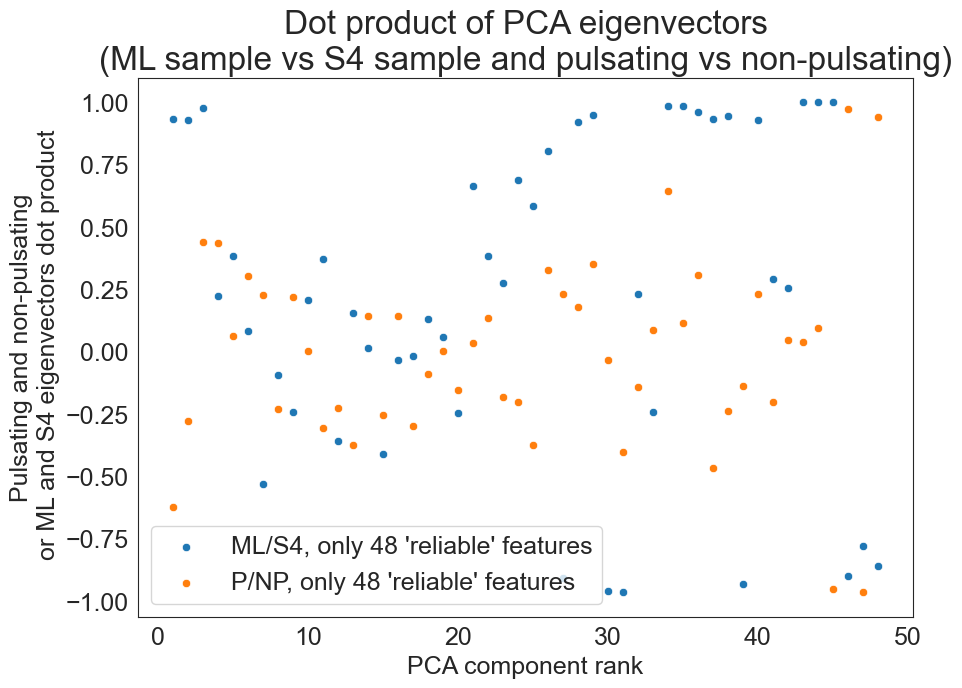

In [222]:
data_list = [dp_rank_rel, dp_rank_pnp_rel]
var_x_list = ['PCA component rank', 'PCA component rank']
var_y_list = ['ML and S4 eigenvectors dot product',
              'Pulsating and Non-pulsating eigenvectors dot product']
dlabel_list = ["ML/S4, only %d 'reliable' features" %len(rel_features),
               "P/NP, only %d 'reliable' features" %len(rel_features)]
xlabel = 'PCA component rank'
ylabel = 'Pulsating and non-pulsating\n or ML and S4 eigenvectors dot product'
fig_title = "Dot product of PCA eigenvectors\n(ML sample vs S4 sample and pulsating vs non-pulsating)"
fig_filename = IMAGE_FOLDER + "ML_20_26ALL_PCA_S4MLPNPRelComp_Eigenvectors_Rank_vs_DotProduct.jpg"

multi_scatter_graph(data_list=data_list, var_x_list=var_x_list, var_y_list=var_y_list,
                    dlabel_list=dlabel_list,
                    xlabel=xlabel, ylabel=ylabel, fig_title=fig_title,
                    fig_filename=fig_filename)

## Summary

**RESULTS:**

- We have reviewed the pair-wise correlations of features: according to that, it is expected that it won't be worth applying PCA.
- PCA results for S4 sample, using all the features, confirm that PCA should not be applied: dimensionality reduction to catch $80\%$ of the variance only reduces the number of features by half, at most.
- PCA results for ML subsample were weird: just the first two components would be needed, and a set of "offending" features were identified (i.e. those having a very high variance). This is explained by the application of PCA to only "reliable" / only "unreliable" features (as defined, depending on the similarity of distributions between ML subsample and S4 sample): for only "reliable" features, the PCA results are very similar for ML subsample and S4 sample, and very similar to the S4 sample case when all the features are taken into account. However, when taking only the "unreliable" features, the PCA for the ML sample suffers exactly the same effect as when taking the full feature set, and the same "offending" features were identified.
- Dot product between PCA components for ML subsample and S4 sample confirm that it is better to use only the $48$ "reliable" features, because that increases the statistical similarity between ML subsample and S4 sample.

**CONCLUSIONS:**

- The "unreliable" features (or at least some of them) are introducing a high distortion in the ML subsample, compared to the S4 sample, as comparative PCA demonstrates.
- In any case, PCA does not seem adequeate for our case, as as much as half the dimensions are to be kept to explain $80\%$ of the variance. Other key factors against PCA in this case is that we don't have a very large number of records or a very large number of features, and that usually PCA makes interpretation a little bit harder on an individual-feature basis.
- The PCA results obtained seem also to **encourage the use of only the $48$ "reliable" features** when it comes to application of the ML model to the real CARMENES data.
- Another option: maybe we should also try with a `RobustScaler`, to see if just the outliers are the source of such discrepancies in PCA? Already tried: the problem with `RobustScaler` is that mean and standard deviation are not set to 0 and 1 respectively, so that scaler impacts PCA results.
